In [1]:
import torch
import torch.nn as nn

class ResBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.upsample(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),   # [64,16,16]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # [128,8,8]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # [128,8,8]
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            ResBlockUp(128, 64),      # [64,16,16]
            ResBlockUp(64, 32),       # [32,32,32]
            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # Final color output
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # 1 (gray) + 3 (color)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # [256, 4, 4]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, gray, color):
        x = torch.cat([gray, color], dim=1)  # Concatenate on channel dimension
        return self.model(x)



In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, ToPILImage, Grayscale

# Custom Dataset that returns: grayscale image, color image
class CIFAR10GrayColor(Dataset):
    def __init__(self, train=True):
        self.dataset = datasets.CIFAR10(
            root='./data',
            train=train,
            download=True,
            transform=transforms.ToTensor()
        )
        self.to_gray = transforms.Grayscale(num_output_channels=1)
        self.to_pil = ToPILImage()
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        color_img, _ = self.dataset[idx]  # [3,32,32]
        pil_img = self.to_pil(color_img)  # Convert back to PIL
        gray_img = self.to_gray(pil_img)  # [1,32,32]
        gray_img = self.to_tensor(gray_img)

        return gray_img, color_img

# Create train/test dataloaders
train_dataset = CIFAR10GrayColor(train=True)
test_dataset = CIFAR10GrayColor(train=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example batch
gray_batch, color_batch = next(iter(train_loader))
print("Grayscale batch shape:", gray_batch.shape)  # [64, 1, 32, 32]
print("Color batch shape:", color_batch.shape)     # [64, 3, 32, 32]


100%|██████████| 170M/170M [00:04<00:00, 38.4MB/s]


Grayscale batch shape: torch.Size([64, 1, 32, 32])
Color batch shape: torch.Size([64, 3, 32, 32])


Epoch [51/100] Progress: 100.00%

=== Epoch [1/50] Summary ===
Discriminator Loss: 0.2954
Generator GAN Loss: 1.0740
Generator L1 Loss : 0.0807
Generator Total Loss (GAN + L1): 9.1403


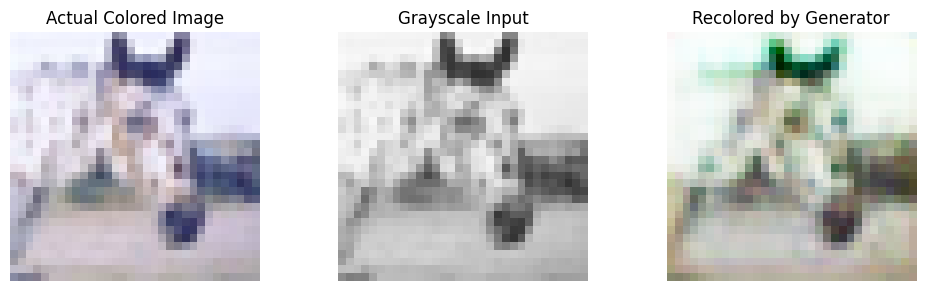

Epoch [52/100] Progress: 100.00%

=== Epoch [2/50] Summary ===
Discriminator Loss: 0.2837
Generator GAN Loss: 1.1316
Generator L1 Loss : 0.0696
Generator Total Loss (GAN + L1): 8.0964


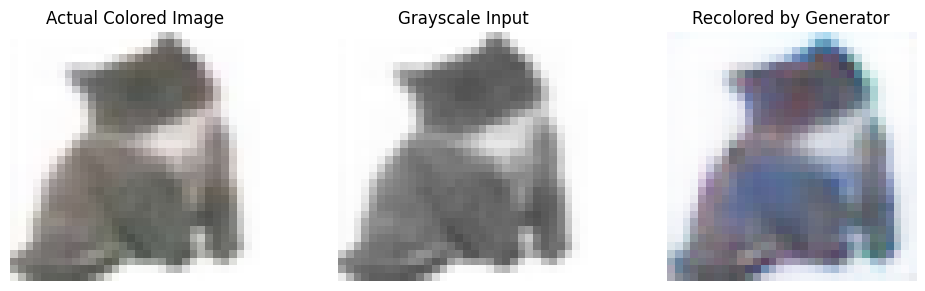

Epoch [53/100] Progress: 100.00%

=== Epoch [3/50] Summary ===
Discriminator Loss: 0.1664
Generator GAN Loss: 2.4027
Generator L1 Loss : 0.0701
Generator Total Loss (GAN + L1): 9.4163


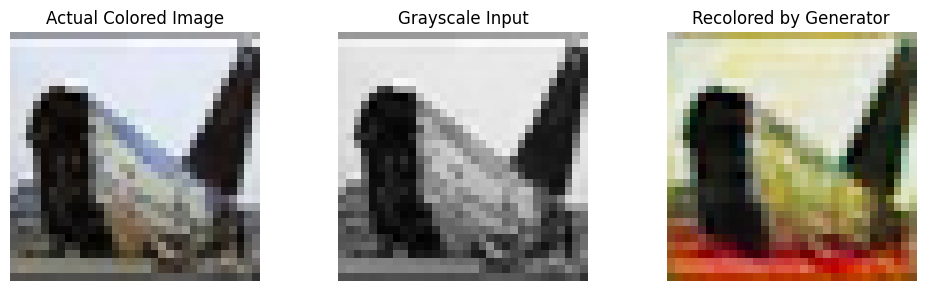

Epoch [54/100] Progress: 100.00%

=== Epoch [4/50] Summary ===
Discriminator Loss: 0.1039
Generator GAN Loss: 4.1272
Generator L1 Loss : 0.0686
Generator Total Loss (GAN + L1): 10.9905


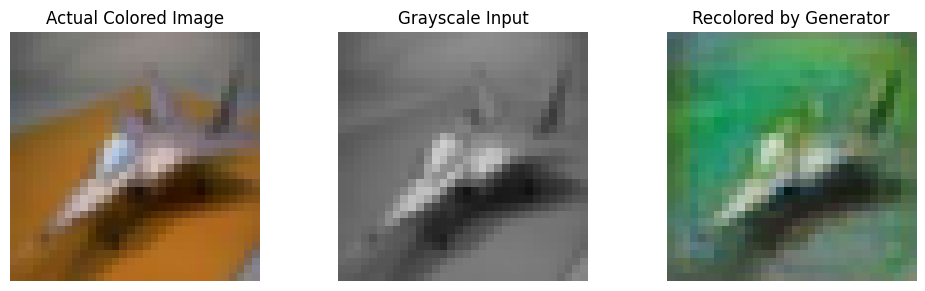

Epoch [55/100] Progress: 100.00%

=== Epoch [5/50] Summary ===
Discriminator Loss: 0.1181
Generator GAN Loss: 4.2311
Generator L1 Loss : 0.0671
Generator Total Loss (GAN + L1): 10.9413


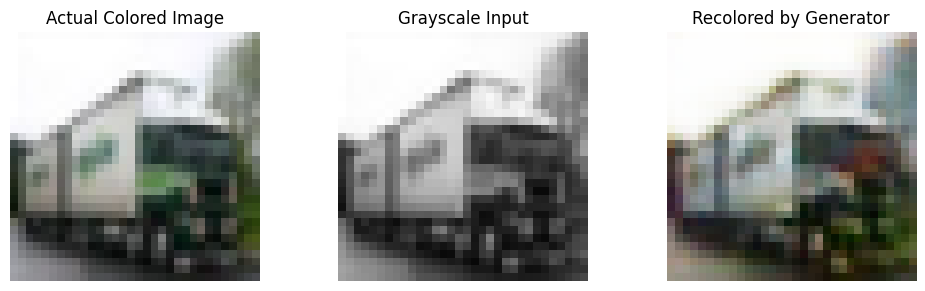

Epoch [56/100] Progress: 100.00%

=== Epoch [6/50] Summary ===
Discriminator Loss: 0.0943
Generator GAN Loss: 4.7398
Generator L1 Loss : 0.0663
Generator Total Loss (GAN + L1): 11.3684


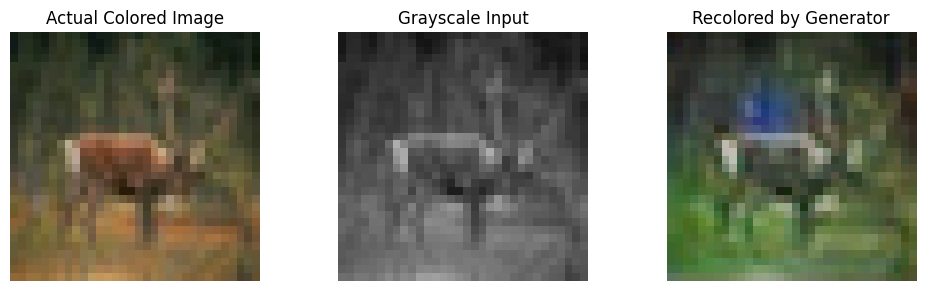

Epoch [57/100] Progress: 100.00%

=== Epoch [7/50] Summary ===
Discriminator Loss: 0.0833
Generator GAN Loss: 5.7943
Generator L1 Loss : 0.0634
Generator Total Loss (GAN + L1): 12.1373


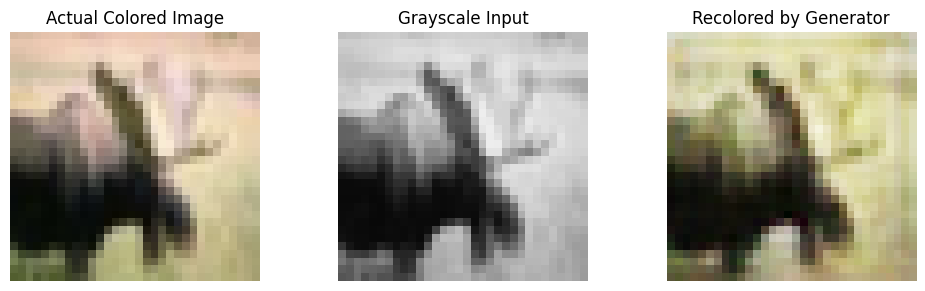

Epoch [58/100] Progress: 100.00%

=== Epoch [8/50] Summary ===
Discriminator Loss: 0.1172
Generator GAN Loss: 4.5804
Generator L1 Loss : 0.0630
Generator Total Loss (GAN + L1): 10.8768


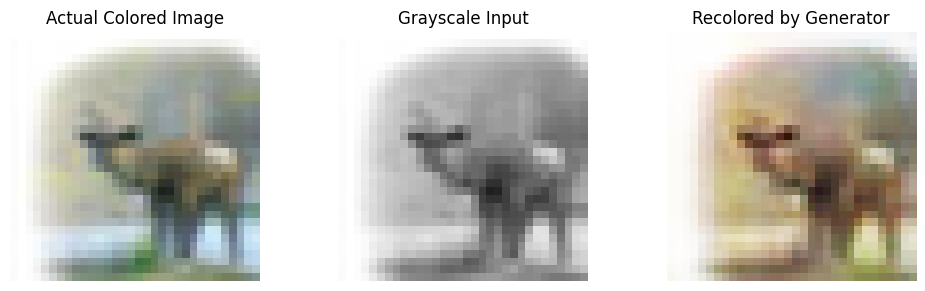

Epoch [59/100] Progress: 100.00%

=== Epoch [9/50] Summary ===
Discriminator Loss: 0.0908
Generator GAN Loss: 5.1221
Generator L1 Loss : 0.0649
Generator Total Loss (GAN + L1): 11.6078


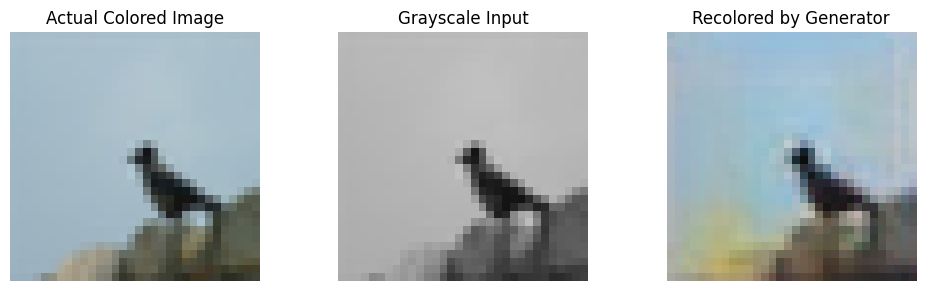

Epoch [60/100] Progress: 100.00%

=== Epoch [10/50] Summary ===
Discriminator Loss: 0.1157
Generator GAN Loss: 5.3793
Generator L1 Loss : 0.0616
Generator Total Loss (GAN + L1): 11.5431


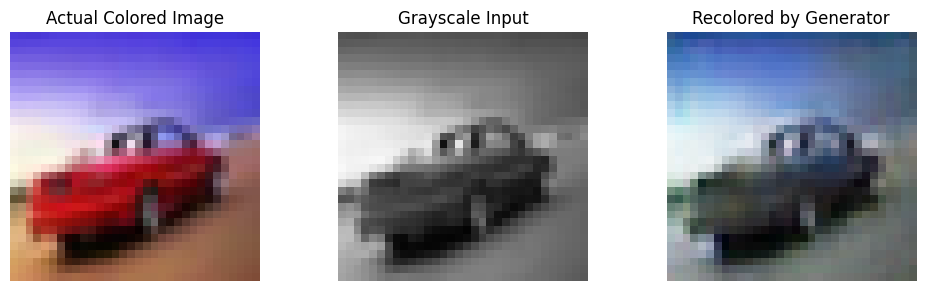

Epoch [61/100] Progress: 100.00%

=== Epoch [11/50] Summary ===
Discriminator Loss: 0.1049
Generator GAN Loss: 4.2520
Generator L1 Loss : 0.0660
Generator Total Loss (GAN + L1): 10.8474


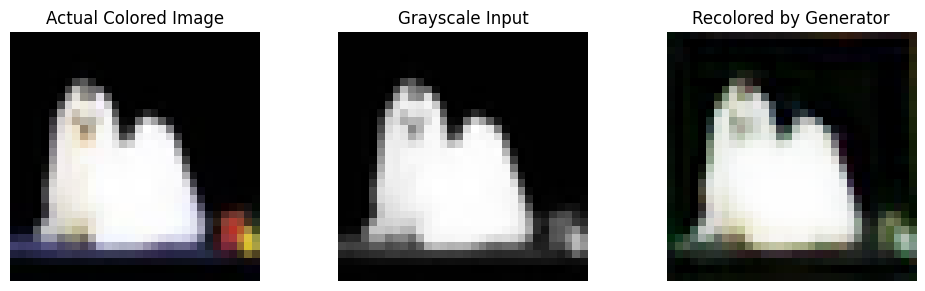

Epoch [62/100] Progress: 100.00%

=== Epoch [12/50] Summary ===
Discriminator Loss: 0.0839
Generator GAN Loss: 5.7058
Generator L1 Loss : 0.0621
Generator Total Loss (GAN + L1): 11.9181


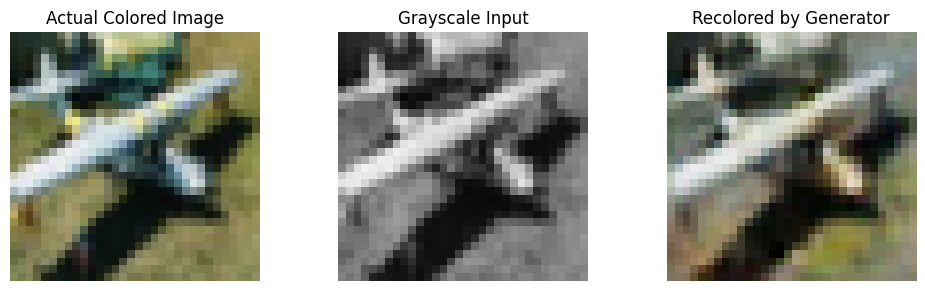

Epoch [63/100] Progress: 100.00%

=== Epoch [13/50] Summary ===
Discriminator Loss: 0.0823
Generator GAN Loss: 6.7202
Generator L1 Loss : 0.0593
Generator Total Loss (GAN + L1): 12.6513


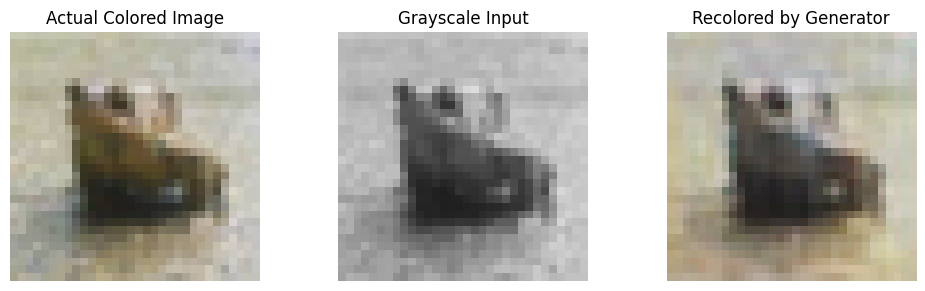

Epoch [64/100] Progress: 100.00%

=== Epoch [14/50] Summary ===
Discriminator Loss: 0.1061
Generator GAN Loss: 6.2957
Generator L1 Loss : 0.0579
Generator Total Loss (GAN + L1): 12.0886


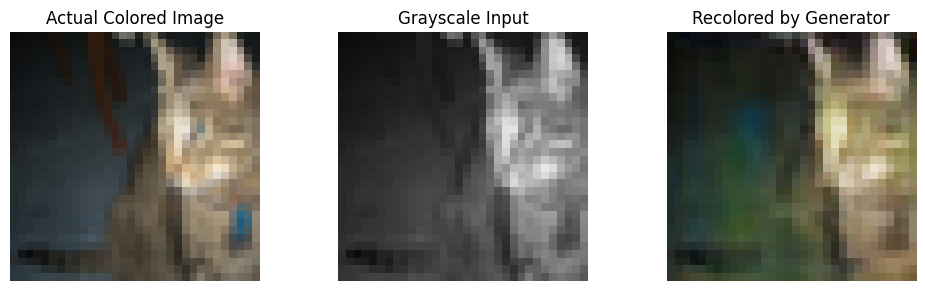

Epoch [65/100] Progress: 100.00%

=== Epoch [15/50] Summary ===
Discriminator Loss: 0.2921
Generator GAN Loss: 1.1898
Generator L1 Loss : 0.0627
Generator Total Loss (GAN + L1): 7.4588


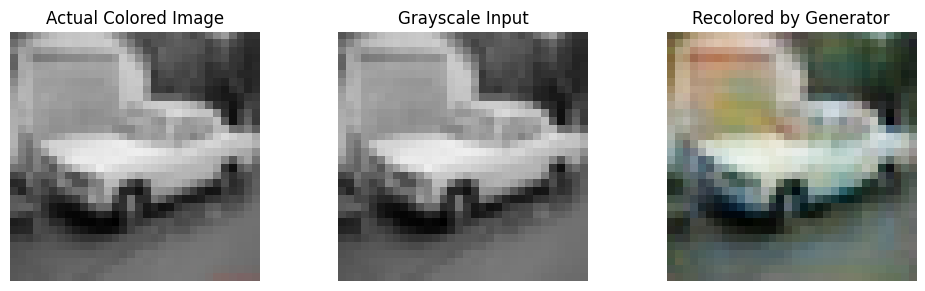

Epoch [66/100] Progress: 100.00%

=== Epoch [16/50] Summary ===
Discriminator Loss: 0.1955
Generator GAN Loss: 2.4706
Generator L1 Loss : 0.0659
Generator Total Loss (GAN + L1): 9.0562


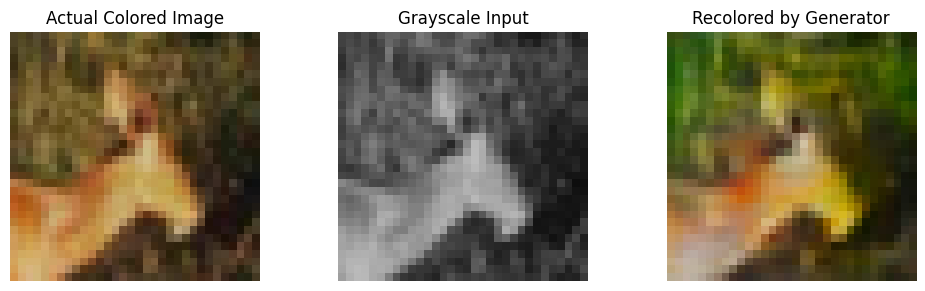

Epoch [67/100] Progress: 100.00%

=== Epoch [17/50] Summary ===
Discriminator Loss: 0.1862
Generator GAN Loss: 2.5395
Generator L1 Loss : 0.0663
Generator Total Loss (GAN + L1): 9.1726


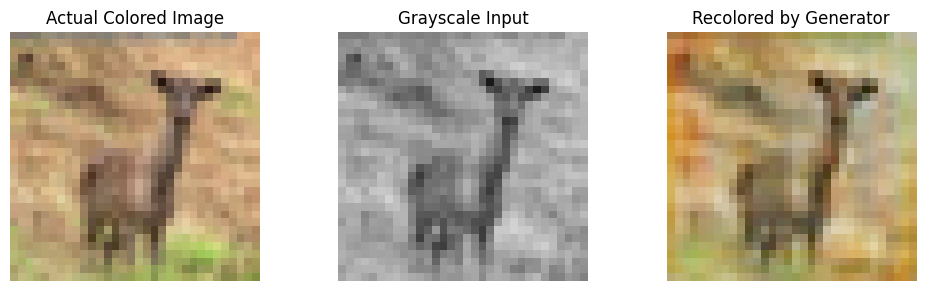

Epoch [68/100] Progress: 100.00%

=== Epoch [18/50] Summary ===
Discriminator Loss: 0.0831
Generator GAN Loss: 6.0669
Generator L1 Loss : 0.0681
Generator Total Loss (GAN + L1): 12.8730


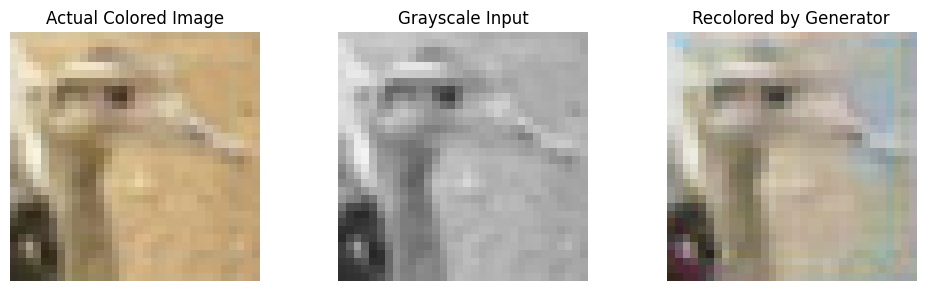

Epoch [69/100] Progress: 100.00%

=== Epoch [19/50] Summary ===
Discriminator Loss: 0.1466
Generator GAN Loss: 4.1889
Generator L1 Loss : 0.0658
Generator Total Loss (GAN + L1): 10.7705


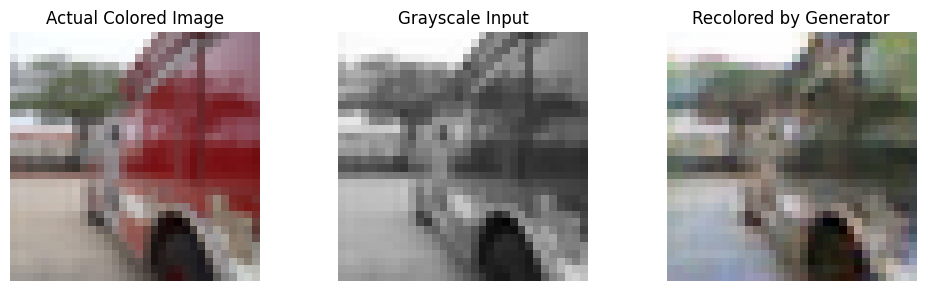

Epoch [70/100] Progress: 100.00%

=== Epoch [20/50] Summary ===
Discriminator Loss: 0.1060
Generator GAN Loss: 4.3710
Generator L1 Loss : 0.0673
Generator Total Loss (GAN + L1): 11.0968


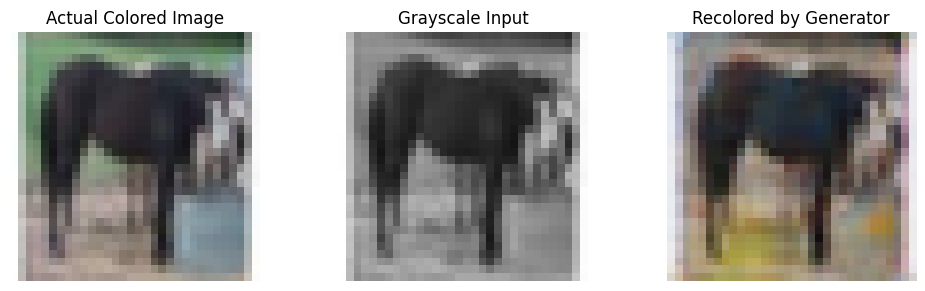

Epoch [71/100] Progress: 100.00%

=== Epoch [21/50] Summary ===
Discriminator Loss: 0.0866
Generator GAN Loss: 5.7727
Generator L1 Loss : 0.0621
Generator Total Loss (GAN + L1): 11.9862


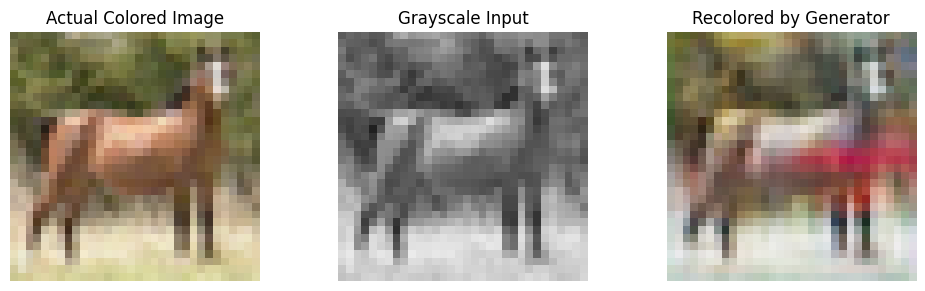

Epoch [72/100] Progress: 100.00%

=== Epoch [22/50] Summary ===
Discriminator Loss: 0.0829
Generator GAN Loss: 6.2044
Generator L1 Loss : 0.0611
Generator Total Loss (GAN + L1): 12.3188


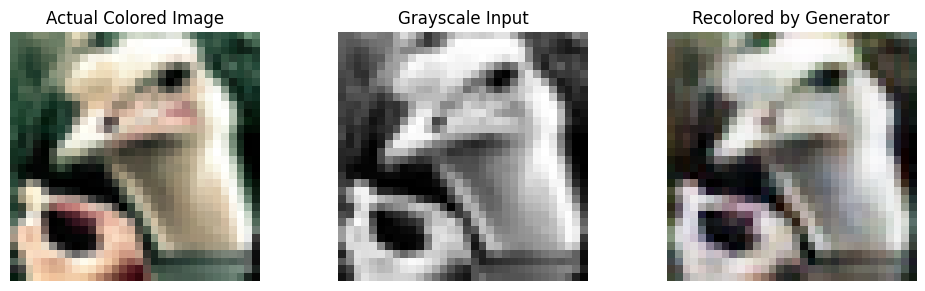

Epoch [73/100] Progress: 100.00%

=== Epoch [23/50] Summary ===
Discriminator Loss: 0.1874
Generator GAN Loss: 4.0665
Generator L1 Loss : 0.0606
Generator Total Loss (GAN + L1): 10.1248


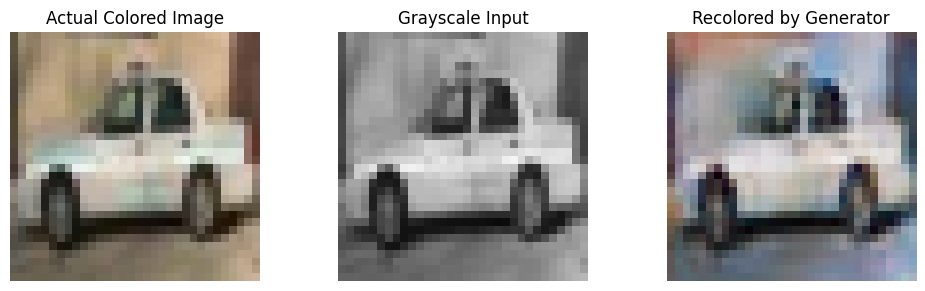

Epoch [74/100] Progress: 100.00%

=== Epoch [24/50] Summary ===
Discriminator Loss: 0.2632
Generator GAN Loss: 1.3519
Generator L1 Loss : 0.0650
Generator Total Loss (GAN + L1): 7.8535


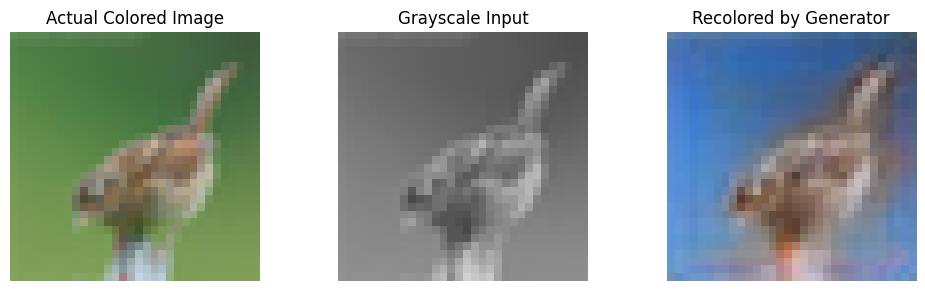

Epoch [75/100] Progress: 100.00%

=== Epoch [25/50] Summary ===
Discriminator Loss: 0.1334
Generator GAN Loss: 3.3297
Generator L1 Loss : 0.0671
Generator Total Loss (GAN + L1): 10.0359


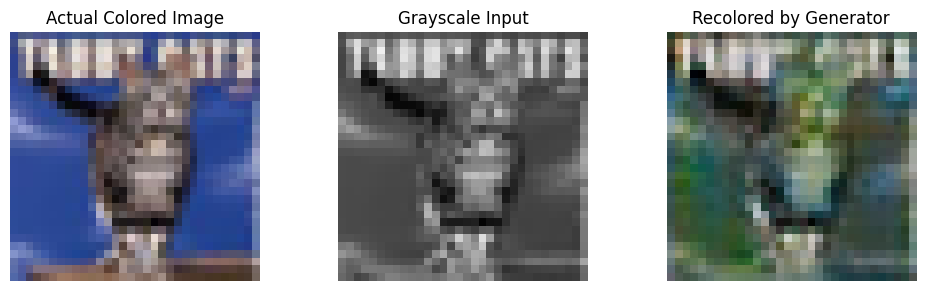

Epoch [76/100] Progress: 100.00%

=== Epoch [26/50] Summary ===
Discriminator Loss: 0.0913
Generator GAN Loss: 5.0062
Generator L1 Loss : 0.0691
Generator Total Loss (GAN + L1): 11.9135


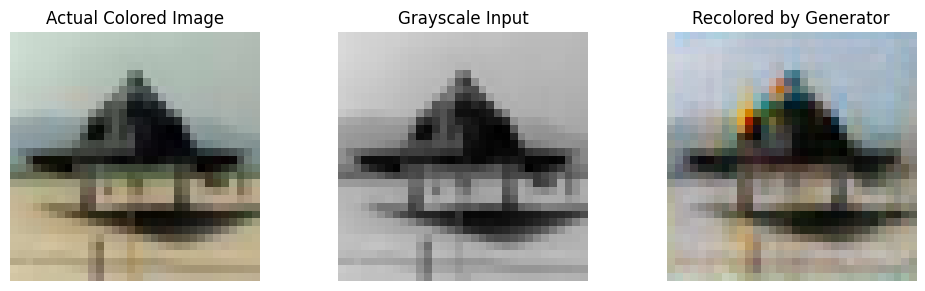

Epoch [77/100] Progress: 100.00%

=== Epoch [27/50] Summary ===
Discriminator Loss: 0.0831
Generator GAN Loss: 6.3652
Generator L1 Loss : 0.0617
Generator Total Loss (GAN + L1): 12.5319


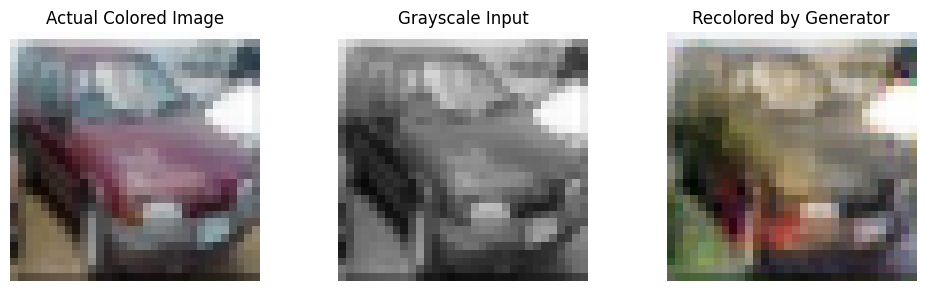

Epoch [78/100] Progress: 100.00%

=== Epoch [28/50] Summary ===
Discriminator Loss: 0.1286
Generator GAN Loss: 3.9531
Generator L1 Loss : 0.0650
Generator Total Loss (GAN + L1): 10.4573


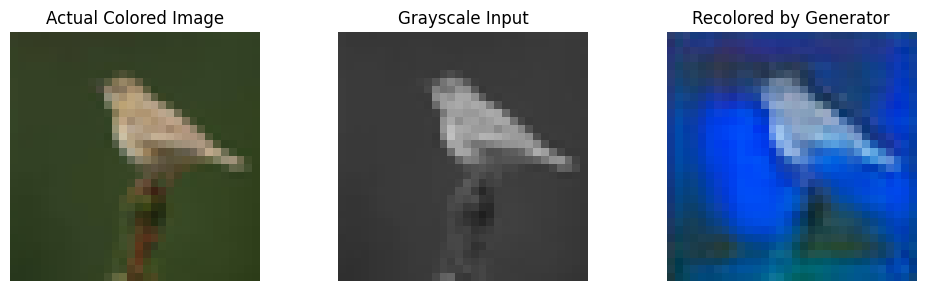

Epoch [79/100] Progress: 100.00%

=== Epoch [29/50] Summary ===
Discriminator Loss: 0.1017
Generator GAN Loss: 4.4218
Generator L1 Loss : 0.0658
Generator Total Loss (GAN + L1): 11.0032


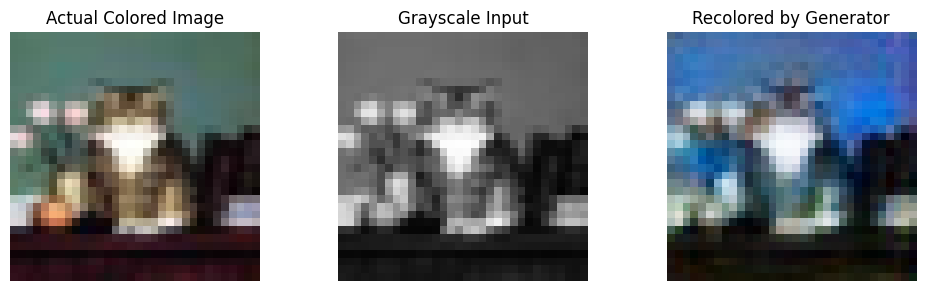

Epoch [80/100] Progress: 100.00%

=== Epoch [30/50] Summary ===
Discriminator Loss: 0.1162
Generator GAN Loss: 4.7507
Generator L1 Loss : 0.0649
Generator Total Loss (GAN + L1): 11.2446


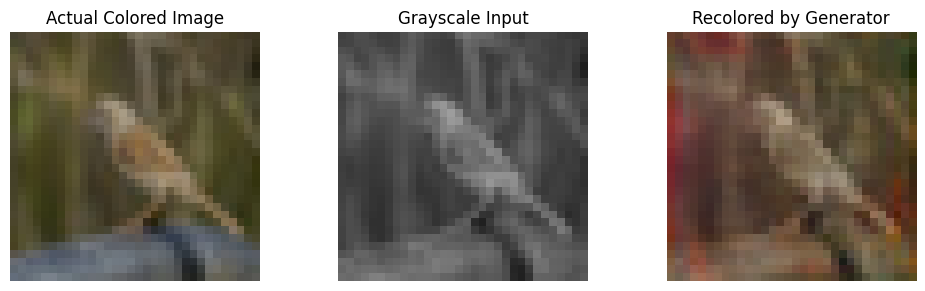

Epoch [81/100] Progress: 100.00%

=== Epoch [31/50] Summary ===
Discriminator Loss: 0.0888
Generator GAN Loss: 4.9315
Generator L1 Loss : 0.0654
Generator Total Loss (GAN + L1): 11.4730


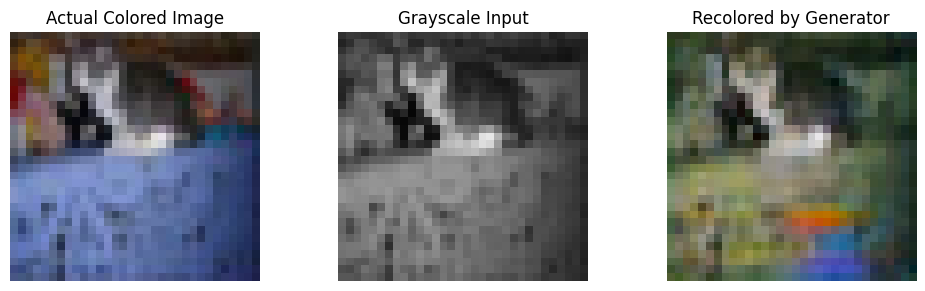

Epoch [82/100] Progress: 100.00%

=== Epoch [32/50] Summary ===
Discriminator Loss: 0.0828
Generator GAN Loss: 6.4396
Generator L1 Loss : 0.0628
Generator Total Loss (GAN + L1): 12.7150


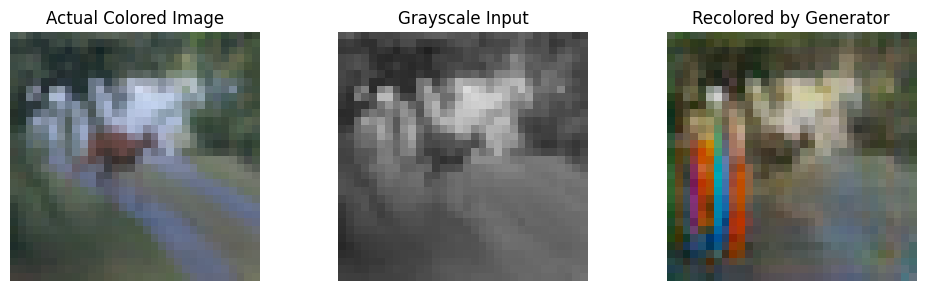

Epoch [83/100] Progress: 100.00%

=== Epoch [33/50] Summary ===
Discriminator Loss: 0.0989
Generator GAN Loss: 5.2993
Generator L1 Loss : 0.0673
Generator Total Loss (GAN + L1): 12.0251


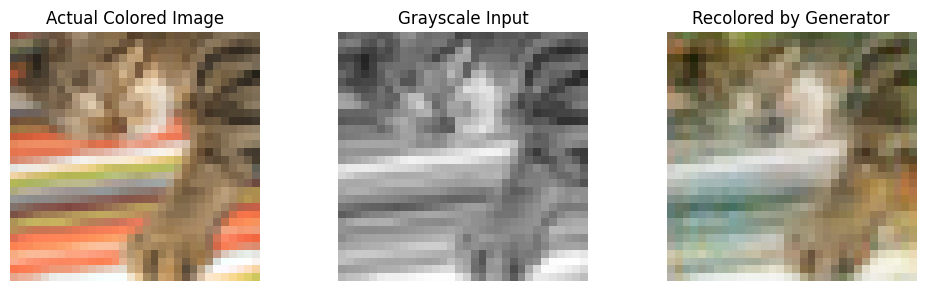

Epoch [84/100] Progress: 100.00%

=== Epoch [34/50] Summary ===
Discriminator Loss: 0.0823
Generator GAN Loss: 6.6995
Generator L1 Loss : 0.0648
Generator Total Loss (GAN + L1): 13.1820


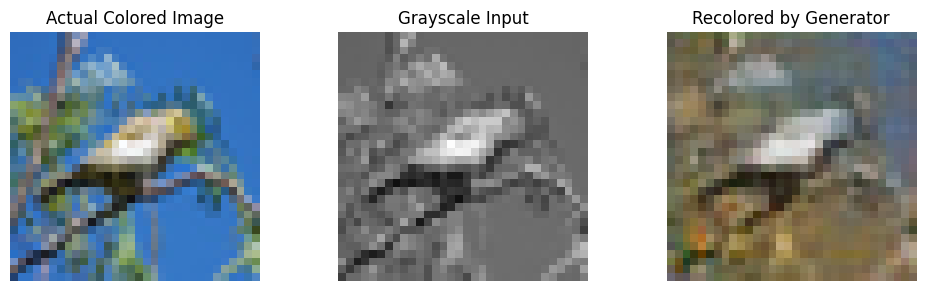

Epoch [85/100] Progress: 100.00%

=== Epoch [35/50] Summary ===
Discriminator Loss: 0.1713
Generator GAN Loss: 3.2829
Generator L1 Loss : 0.0648
Generator Total Loss (GAN + L1): 9.7597


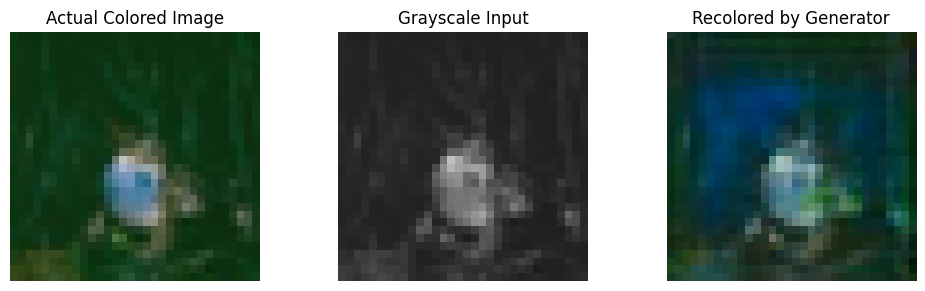

Epoch [86/100] Progress: 100.00%

=== Epoch [36/50] Summary ===
Discriminator Loss: 0.0915
Generator GAN Loss: 4.5400
Generator L1 Loss : 0.0670
Generator Total Loss (GAN + L1): 11.2373


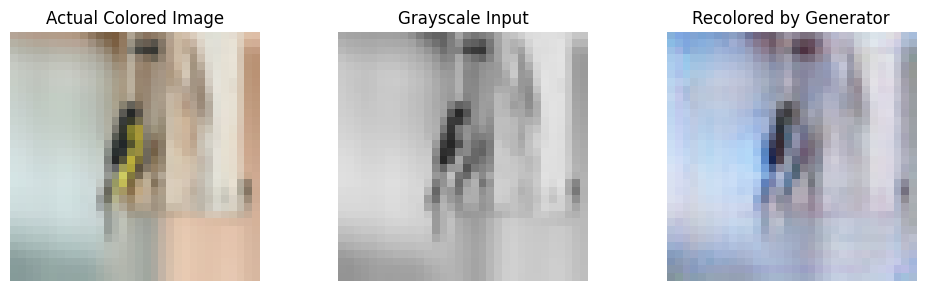

Epoch [87/100] Progress: 100.00%

=== Epoch [37/50] Summary ===
Discriminator Loss: 0.0849
Generator GAN Loss: 5.4895
Generator L1 Loss : 0.0650
Generator Total Loss (GAN + L1): 11.9846


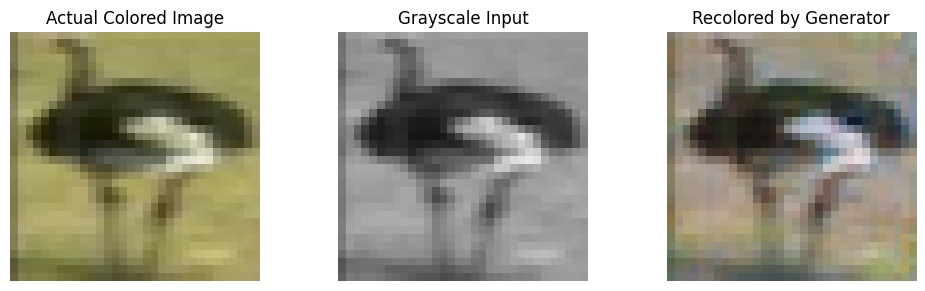

Epoch [88/100] Progress: 100.00%

=== Epoch [38/50] Summary ===
Discriminator Loss: 0.0836
Generator GAN Loss: 5.9807
Generator L1 Loss : 0.0634
Generator Total Loss (GAN + L1): 12.3214


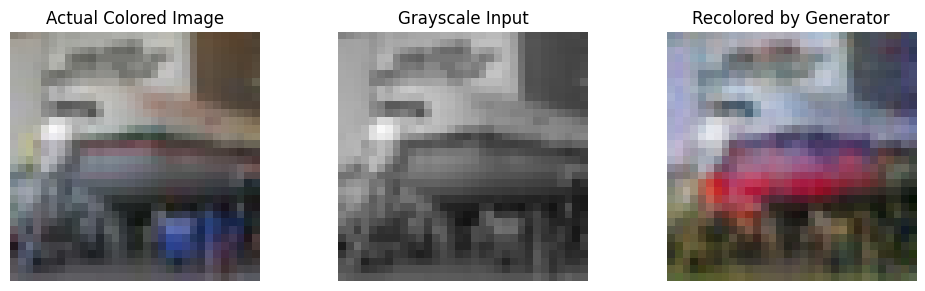

Epoch [89/100] Progress: 100.00%

=== Epoch [39/50] Summary ===
Discriminator Loss: 0.1117
Generator GAN Loss: 5.1620
Generator L1 Loss : 0.0635
Generator Total Loss (GAN + L1): 11.5124


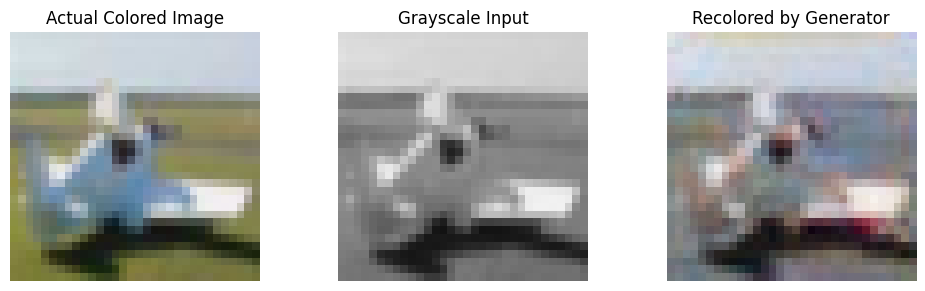

Epoch [90/100] Progress: 100.00%

=== Epoch [40/50] Summary ===
Discriminator Loss: 0.0936
Generator GAN Loss: 4.9833
Generator L1 Loss : 0.0675
Generator Total Loss (GAN + L1): 11.7319


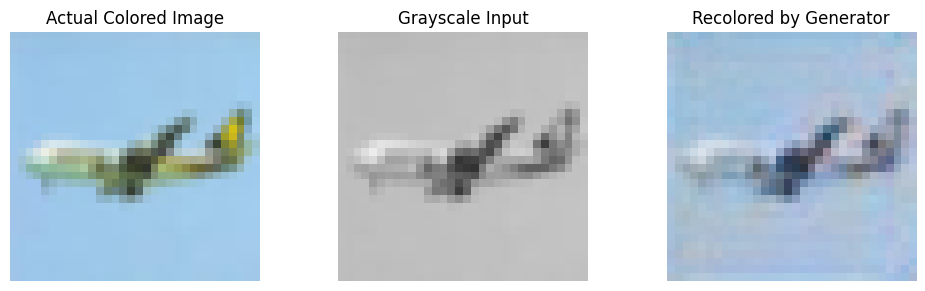

Epoch [91/100] Progress: 100.00%

=== Epoch [41/50] Summary ===
Discriminator Loss: 0.0829
Generator GAN Loss: 6.2331
Generator L1 Loss : 0.0637
Generator Total Loss (GAN + L1): 12.5985


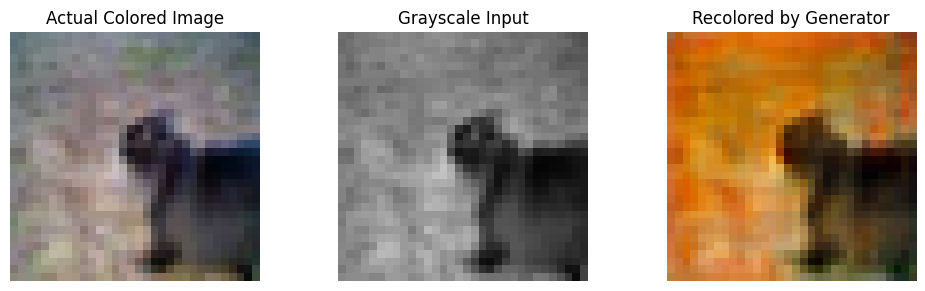

Epoch [92/100] Progress: 100.00%

=== Epoch [42/50] Summary ===
Discriminator Loss: 0.0913
Generator GAN Loss: 6.5643
Generator L1 Loss : 0.0622
Generator Total Loss (GAN + L1): 12.7814


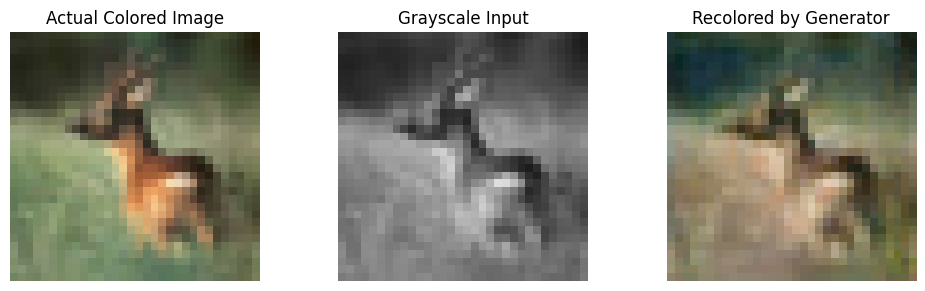

Epoch [93/100] Progress: 100.00%

=== Epoch [43/50] Summary ===
Discriminator Loss: 0.1302
Generator GAN Loss: 3.4053
Generator L1 Loss : 0.0657
Generator Total Loss (GAN + L1): 9.9770


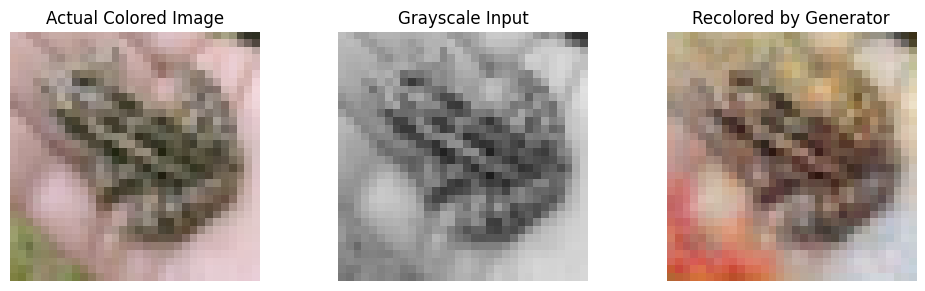

Epoch [94/100] Progress: 100.00%

=== Epoch [44/50] Summary ===
Discriminator Loss: 0.0833
Generator GAN Loss: 6.1204
Generator L1 Loss : 0.0634
Generator Total Loss (GAN + L1): 12.4644


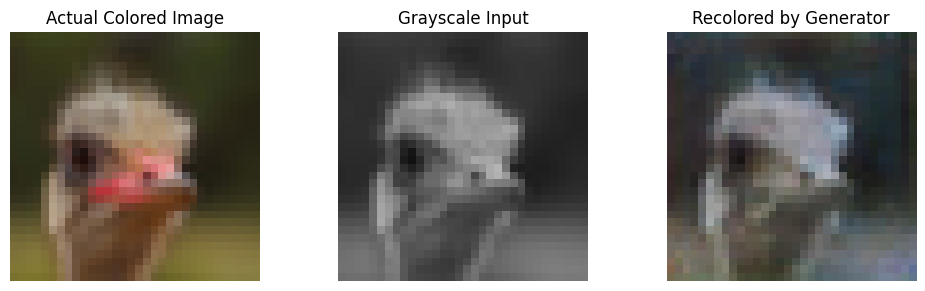

Epoch [95/100] Progress: 100.00%

=== Epoch [45/50] Summary ===
Discriminator Loss: 0.0824
Generator GAN Loss: 6.8041
Generator L1 Loss : 0.0604
Generator Total Loss (GAN + L1): 12.8409


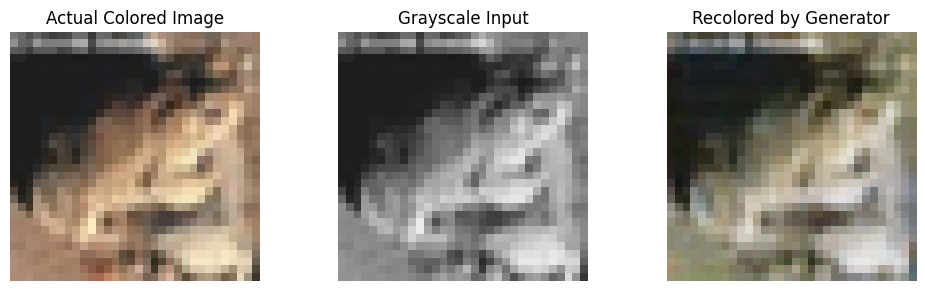

Epoch [96/100] Progress: 100.00%

=== Epoch [46/50] Summary ===
Discriminator Loss: 0.0821
Generator GAN Loss: 7.0052
Generator L1 Loss : 0.0593
Generator Total Loss (GAN + L1): 12.9348


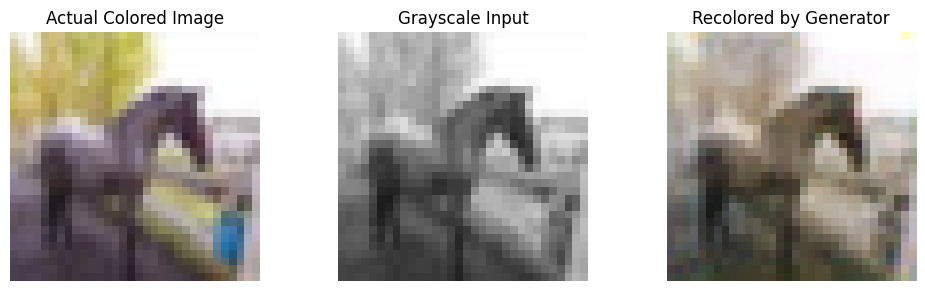

Epoch [97/100] Progress: 100.00%

=== Epoch [47/50] Summary ===
Discriminator Loss: 0.1004
Generator GAN Loss: 6.7090
Generator L1 Loss : 0.0575
Generator Total Loss (GAN + L1): 12.4635


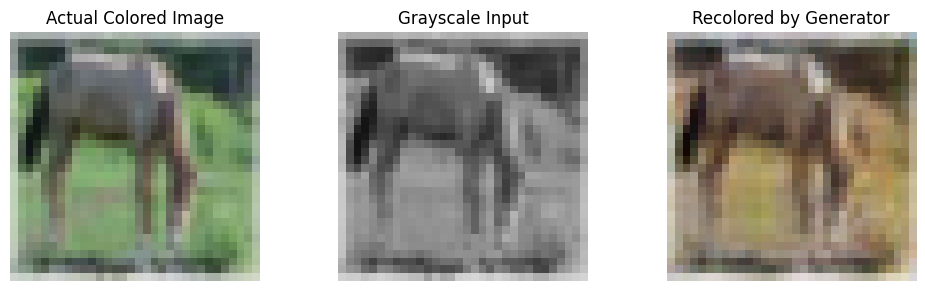

Epoch [98/100] Progress: 100.00%

=== Epoch [48/50] Summary ===
Discriminator Loss: 0.2320
Generator GAN Loss: 1.5765
Generator L1 Loss : 0.0644
Generator Total Loss (GAN + L1): 8.0142


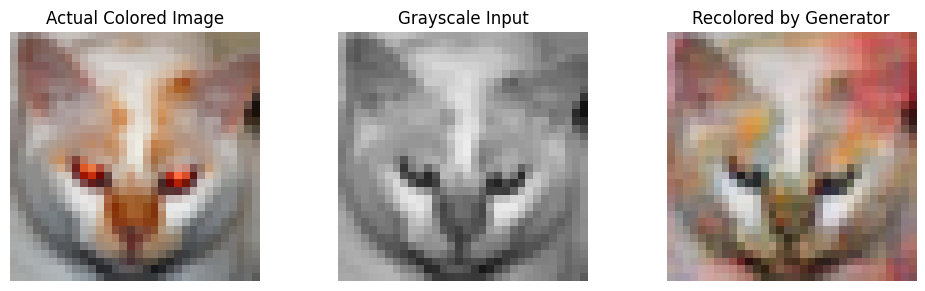

Epoch [99/100] Progress: 100.00%

=== Epoch [49/50] Summary ===
Discriminator Loss: 0.1245
Generator GAN Loss: 3.1471
Generator L1 Loss : 0.0700
Generator Total Loss (GAN + L1): 10.1515


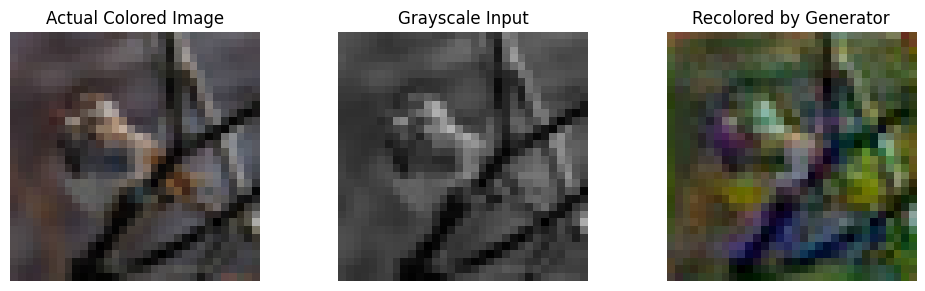

Epoch [100/100] Progress: 100.00%

=== Epoch [50/50] Summary ===
Discriminator Loss: 0.0976
Generator GAN Loss: 4.1401
Generator L1 Loss : 0.0710
Generator Total Loss (GAN + L1): 11.2356


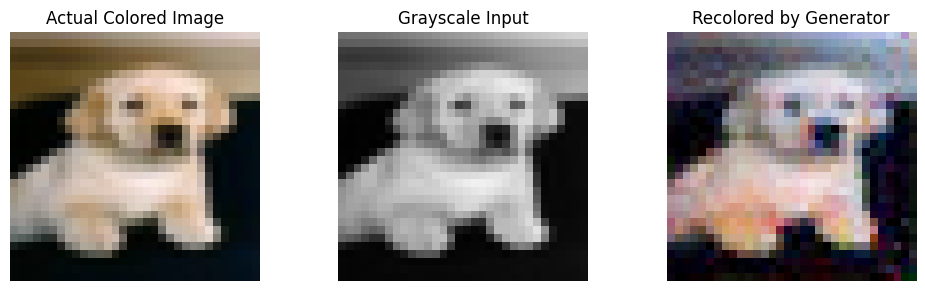

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 50
criterion_gan = nn.BCELoss()   #uncomment if running from scratch
criterion_l1 = nn.L1Loss()

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
lambda_l1 = 100

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

for epoch in range(num_epochs):
    g_gan_loss_epoch = 0.0
    g_l1_loss_epoch = 0.0
    g_total_loss_epoch = 0.0
    d_loss_epoch = 0.0

    for batch_idx, (gray, color) in enumerate(train_loader):
        gray = gray.to(device)
        color = color.to(device)

        real_labels = torch.full((gray.size(0), 1), 0.9, device=device)  # Label smoothing
        fake_labels = torch.zeros((gray.size(0), 1), device=device)

        # --- Train Discriminator every alternate step ---
        if batch_idx % 2 == 0:
            optimizer_d.zero_grad()
            with torch.no_grad():
                fake_color = generator(gray)

            real_output = discriminator(gray, color)
            fake_output = discriminator(gray, fake_color)

            d_loss_real = criterion_gan(real_output, real_labels)
            d_loss_fake = criterion_gan(fake_output, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_d.step()
        else:
            d_loss = torch.tensor(0.0)

        # --- Train Generator (twice per batch) ---
        g_gan_loss = g_l1_loss = g_total_loss = 0.0
        for _ in range(2):
            optimizer_g.zero_grad()
            fake_color = generator(gray)
            output = discriminator(gray, fake_color)

            g_gan = criterion_gan(output, real_labels)
            g_l1 = criterion_l1(fake_color, color)
            g_total = g_gan + lambda_l1 * g_l1

            g_total.backward()
            optimizer_g.step()

            g_gan_loss += g_gan.item()
            g_l1_loss += g_l1.item()
            g_total_loss += g_total.item()

        g_gan_loss_epoch += g_gan_loss / 2
        g_l1_loss_epoch += g_l1_loss / 2
        g_total_loss_epoch += g_total_loss / 2
        d_loss_epoch += d_loss.item()

        # --- Print percentage progress ---
        percent = 100 * (batch_idx + 1) / len(train_loader)
        print(f"\rEpoch [{epoch+51}/{num_epochs+50}] Progress: {percent:.2f}%", end='', flush=True)

    # --- Epoch Summary ---
    avg_d = d_loss_epoch / len(train_loader)
    avg_gg = g_gan_loss_epoch / len(train_loader)
    avg_l1 = g_l1_loss_epoch / len(train_loader)
    avg_gtotal = g_total_loss_epoch / len(train_loader)

    print(f"\n\n=== Epoch [{epoch+1}/{num_epochs}] Summary ===")
    print(f"Discriminator Loss: {avg_d:.4f}")
    print(f"Generator GAN Loss: {avg_gg:.4f}")
    print(f"Generator L1 Loss : {avg_l1:.4f}")
    print(f"Generator Total Loss (GAN + L1): {avg_gtotal:.4f}")
    print("=============================================")

    # --- Visualize Samples ---
    generator.eval()
    with torch.no_grad():
        sample_gray = gray[0].unsqueeze(0).to(device)
        sample_real_color = color[0].cpu()
        sample_fake_color = generator(sample_gray).squeeze(0).cpu()

        sample_gray_show = sample_gray.squeeze(0).repeat(3, 1, 1).cpu()

        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(sample_real_color.permute(1, 2, 0))
        axs[0].set_title("Actual Colored Image")
        axs[0].axis('off')

        axs[1].imshow(sample_gray_show.permute(1, 2, 0), cmap='gray')
        axs[1].set_title("Grayscale Input")
        axs[1].axis('off')

        axs[2].imshow(sample_fake_color.permute(1, 2, 0).clip(0, 1))
        axs[2].set_title("Recolored by Generator")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()
    generator.train()


In [7]:
import torch
import random
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import torch

def visualize_recolor_samples(generator, train_loader, test_loader, use_train=True, num_samples=4, device=None):
    generator.eval()

    loader = train_loader if use_train else test_loader
    data_iter = iter(loader)

    try:
        gray_imgs, color_imgs = next(data_iter)
    except StopIteration:
        print("Empty loader!")
        return

    # Take only the first few samples
    gray_imgs = gray_imgs[:num_samples].to(device)
    color_imgs = color_imgs[:num_samples].to(device)

    # Ensure grayscale input has correct shape: [B, 1, H, W]
    if gray_imgs.ndim == 3:
        gray_imgs = gray_imgs.unsqueeze(1)  # add channel dimension if missing

    with torch.no_grad():
        fake_color_imgs = generator(gray_imgs).cpu()

    gray_imgs = gray_imgs.cpu()
    color_imgs = color_imgs.cpu()

    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(color_imgs[i].permute(1, 2, 0).clip(0, 1))
        axs[0].set_title("Actual Colored Image")
        axs[0].axis('off')

        axs[1].imshow(gray_imgs[i][0], cmap='gray')
        axs[1].set_title("Grayscale Input")
        axs[1].axis('off')

        axs[2].imshow(fake_color_imgs[i].permute(1, 2, 0).clip(0, 1))
        axs[2].set_title("Recolored by Generator")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    generator.train()



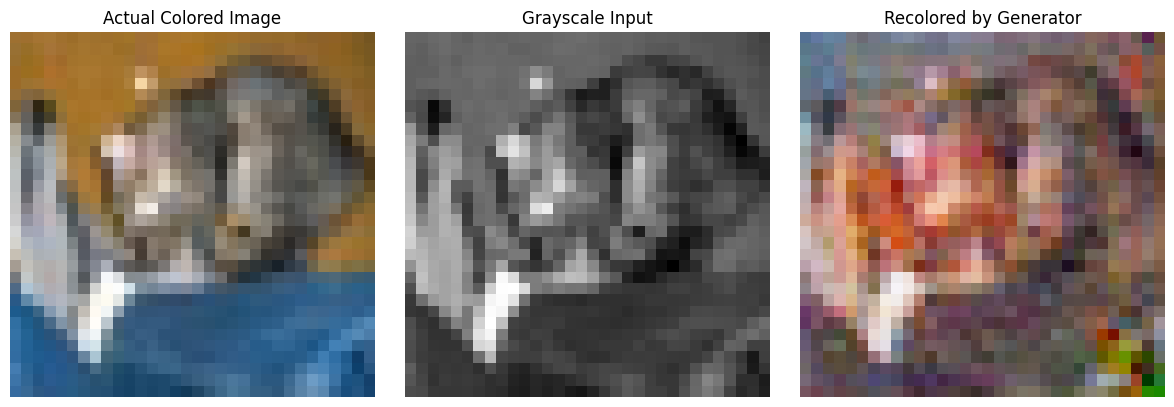

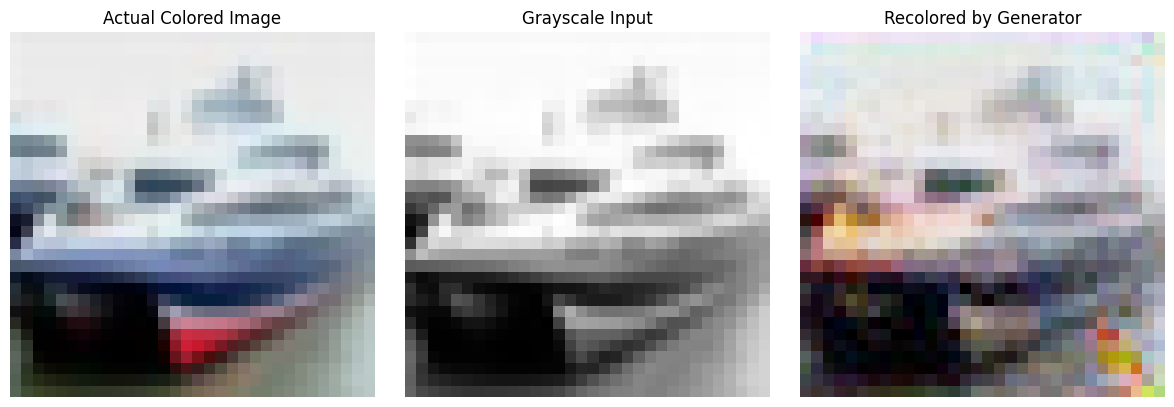

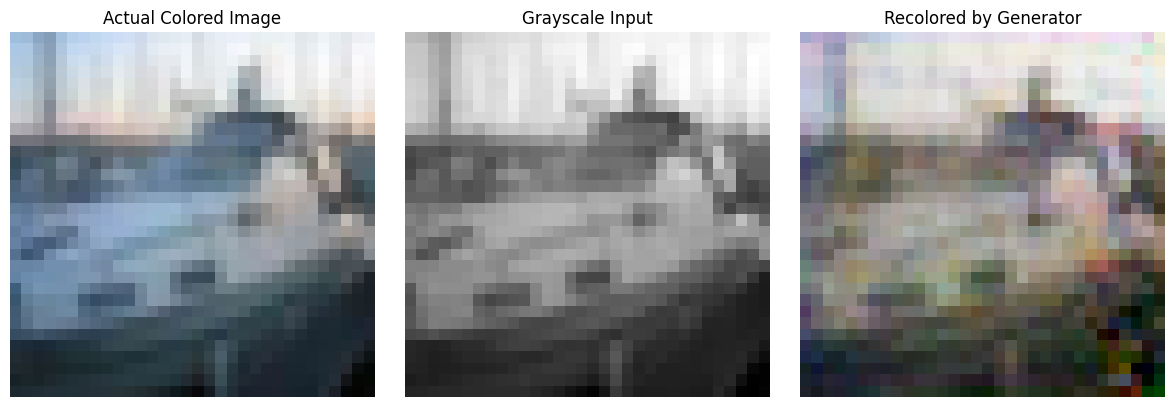

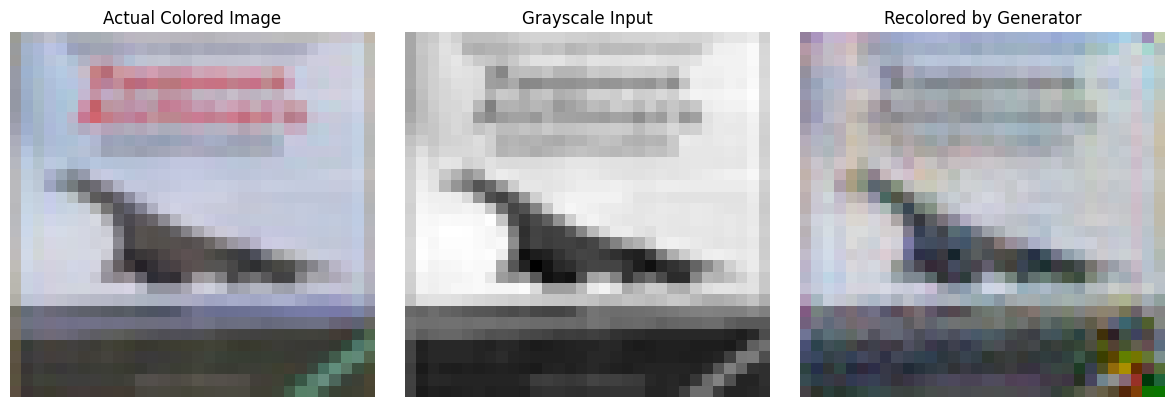

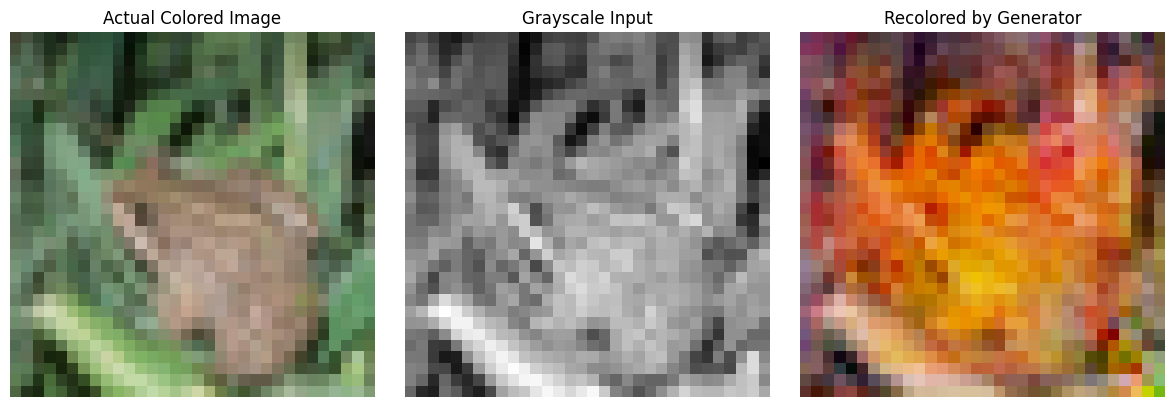

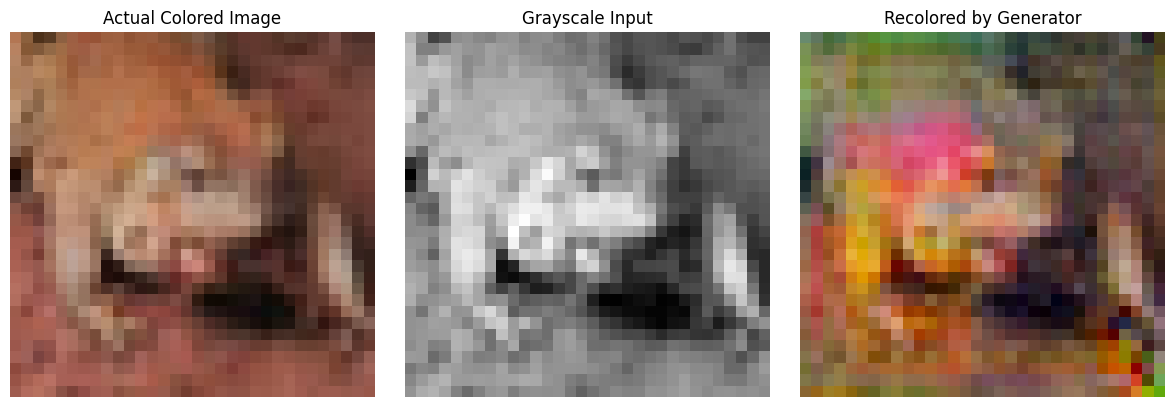

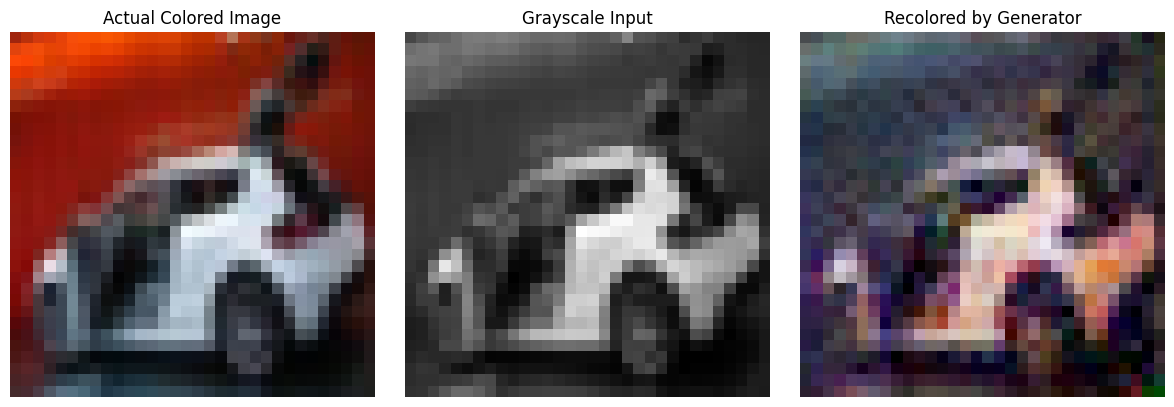

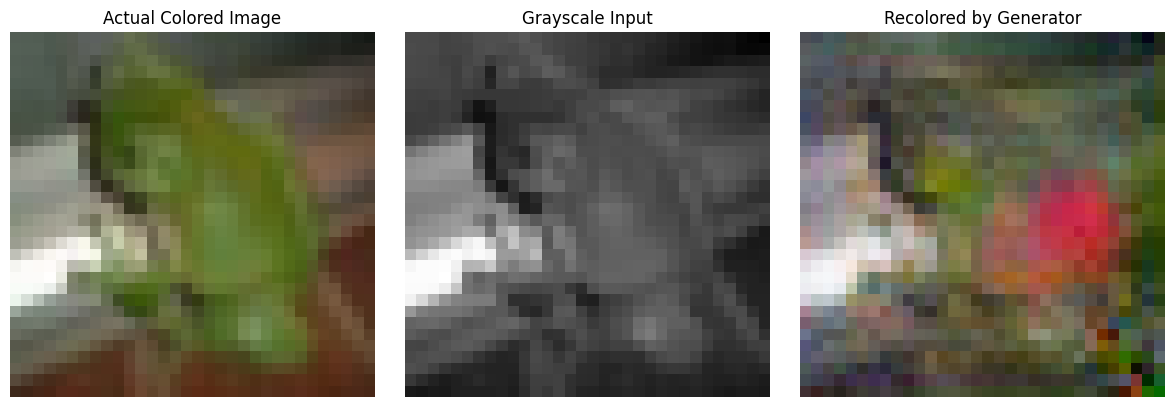

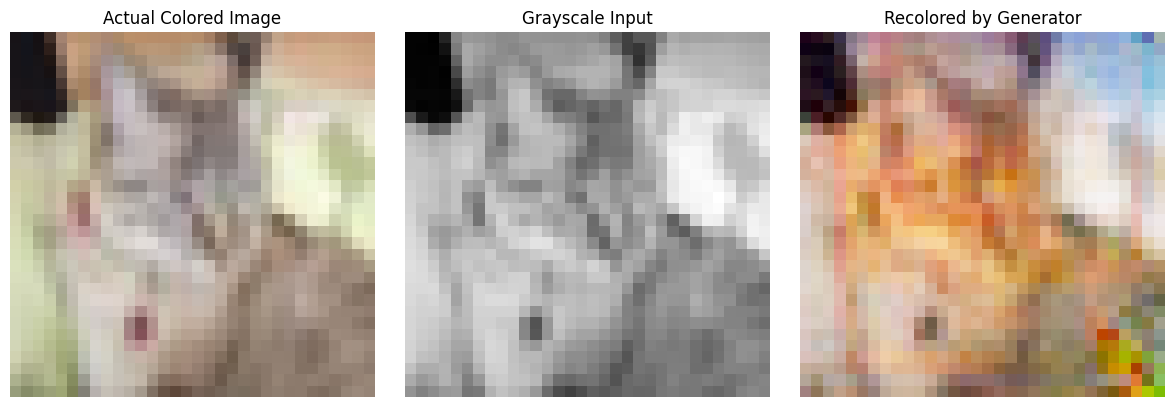

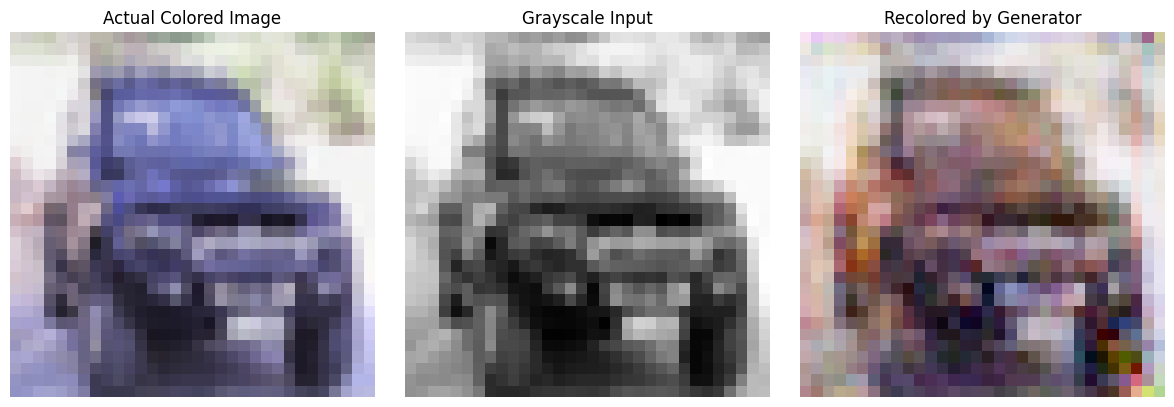

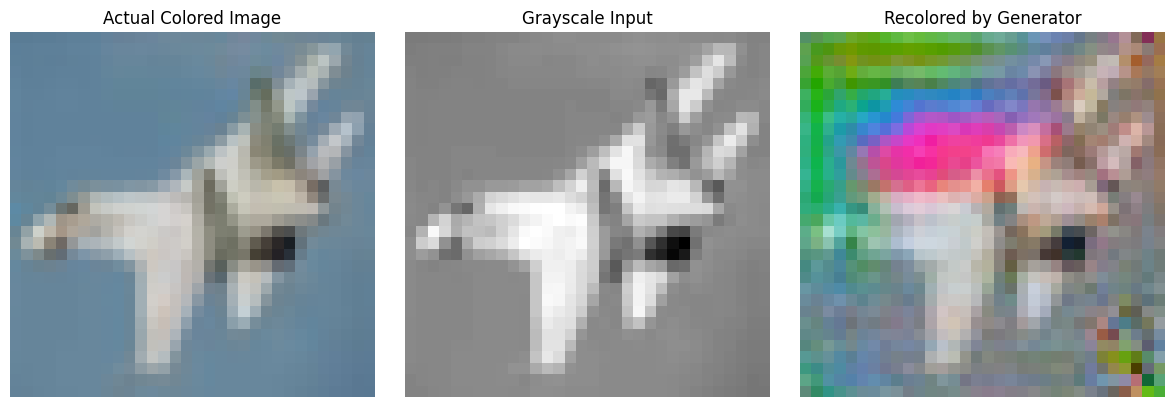

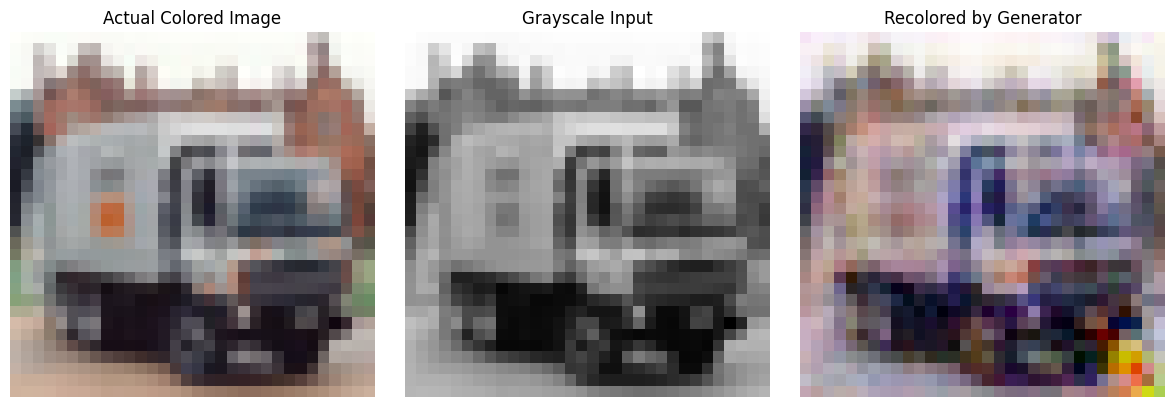

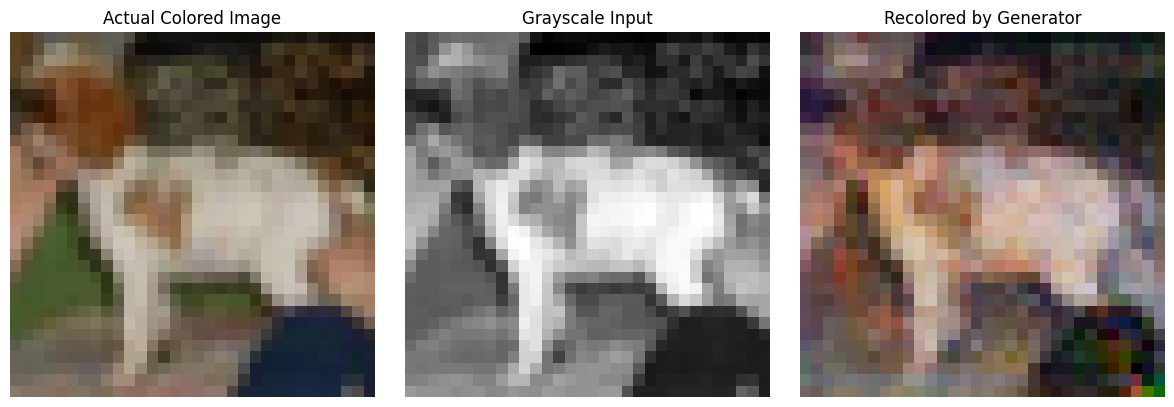

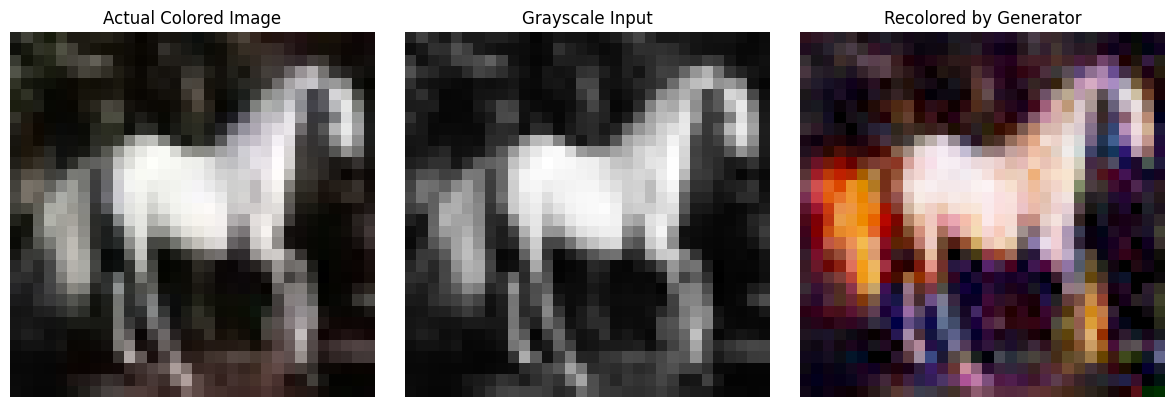

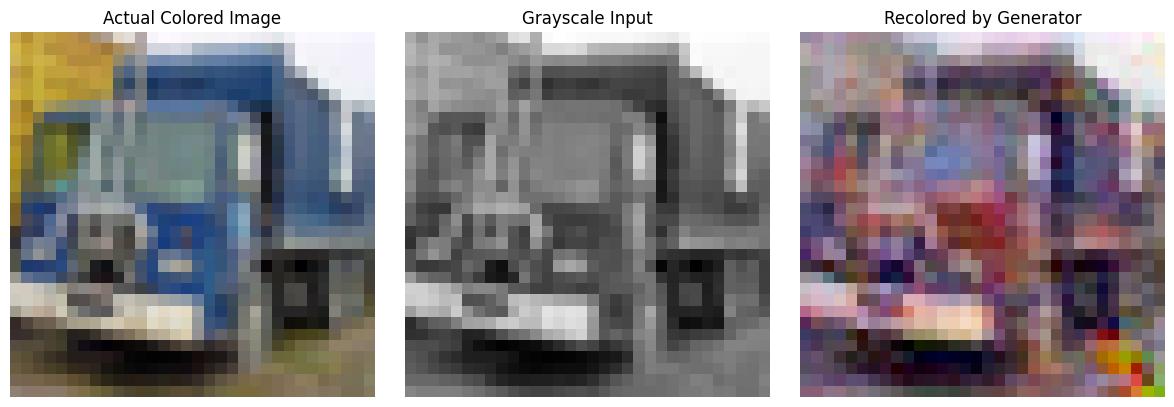

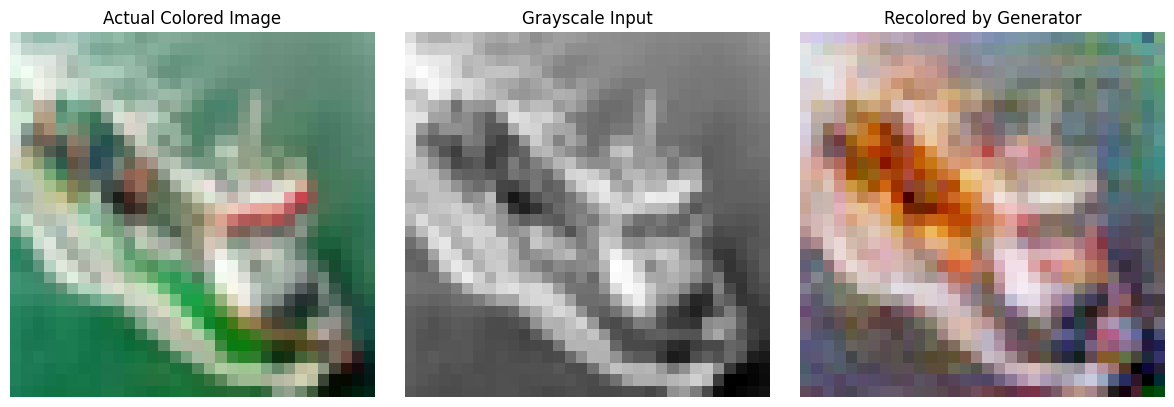

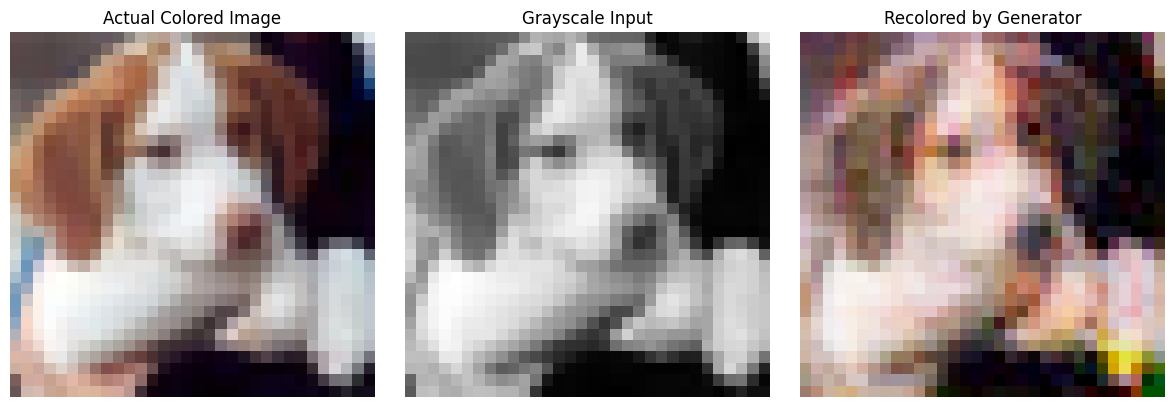

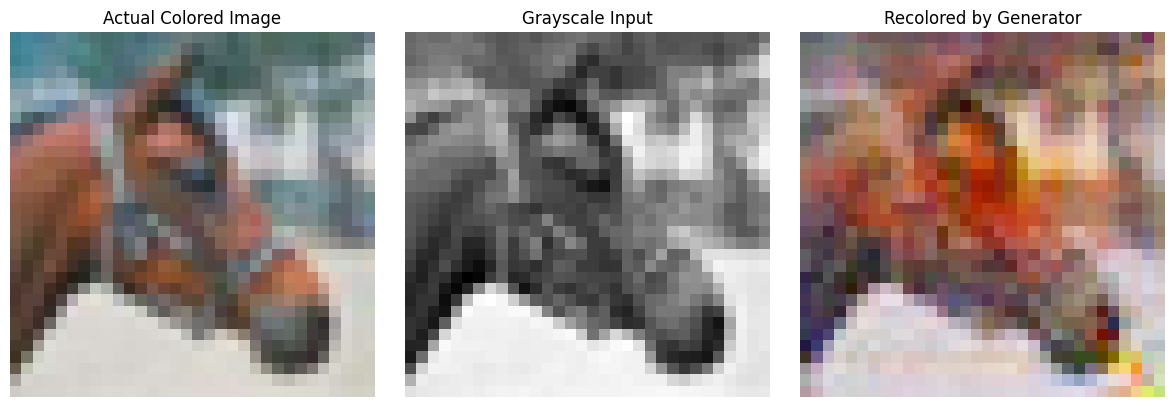

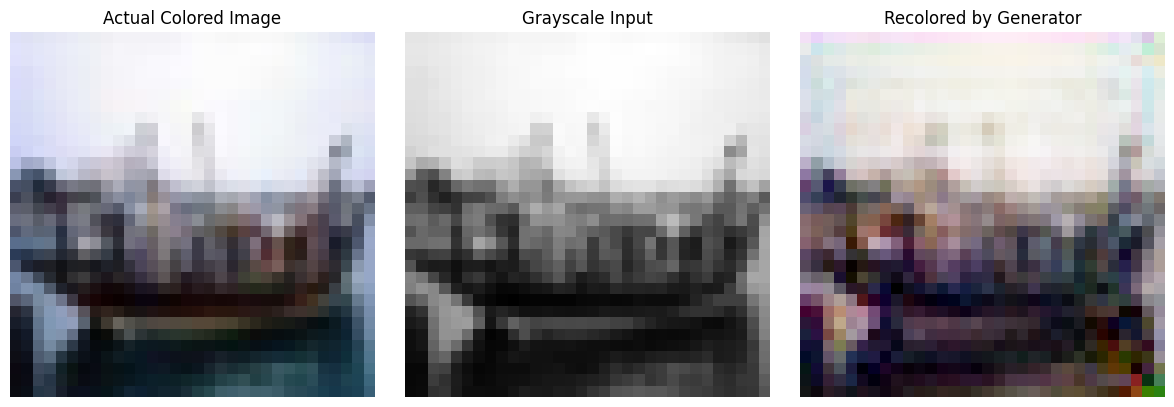

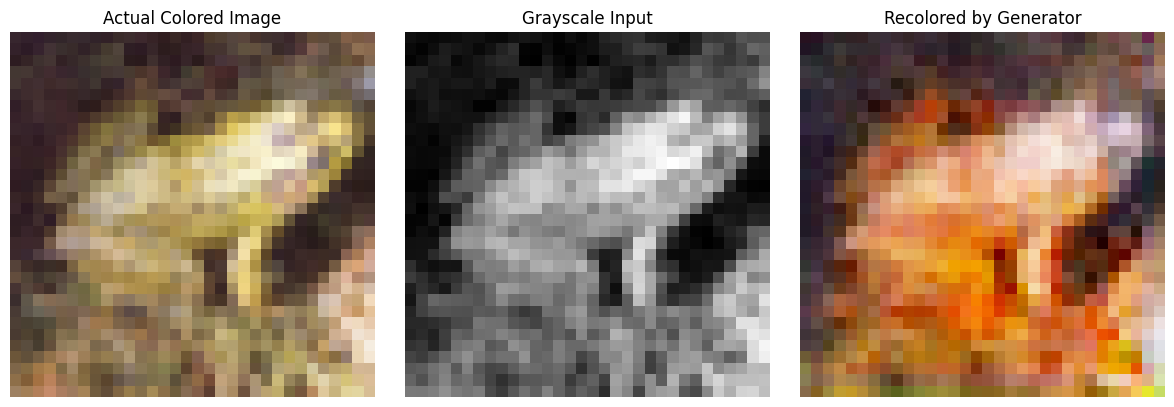

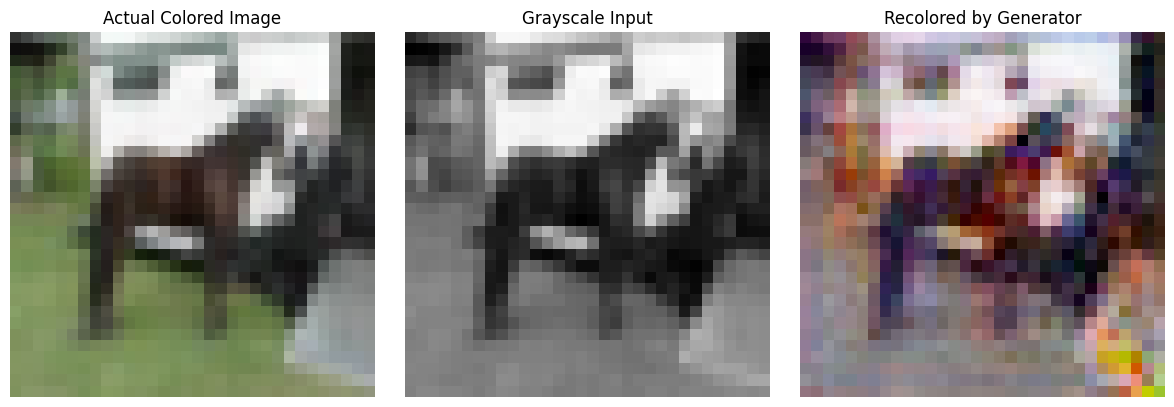

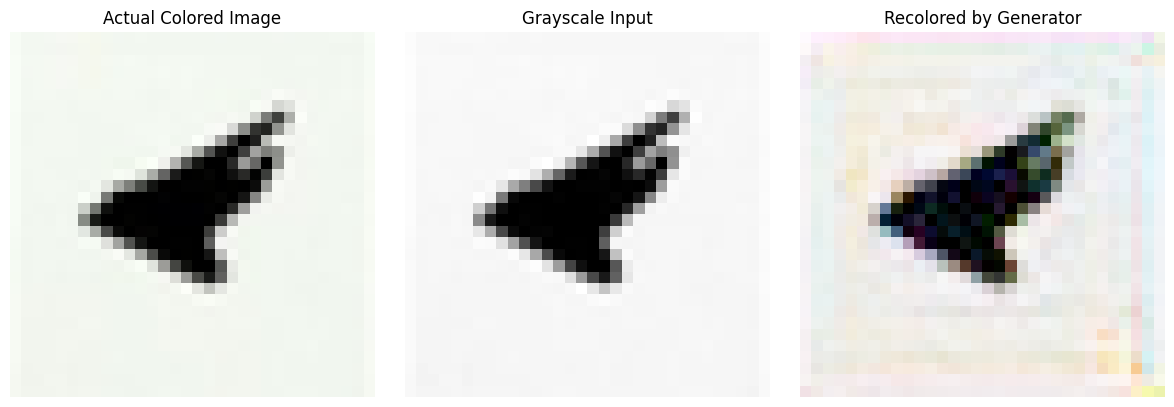

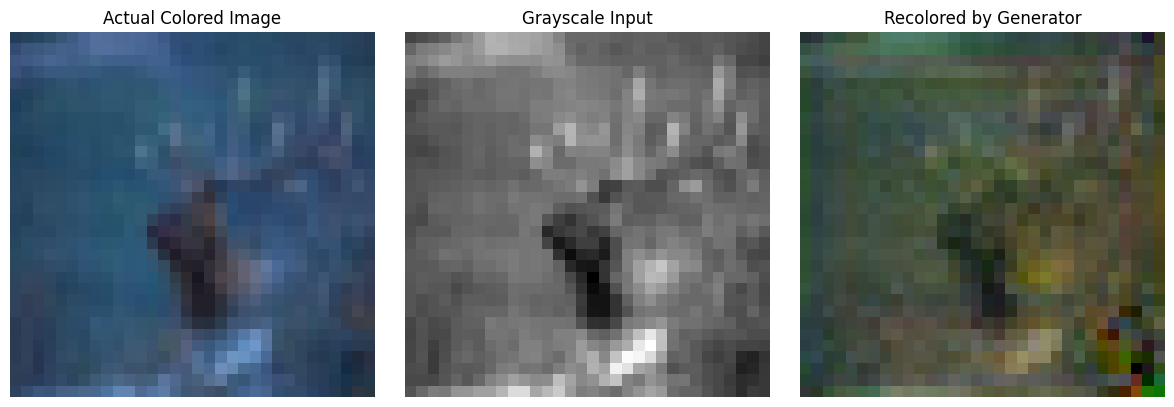

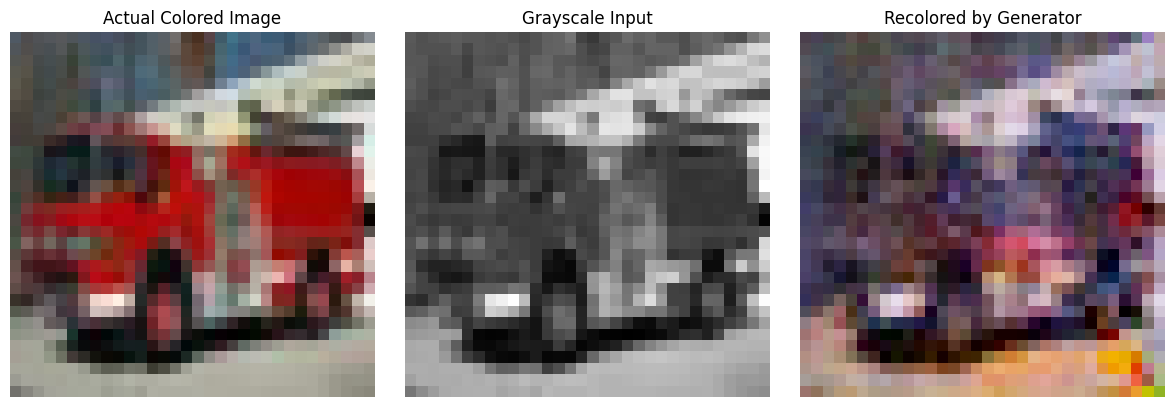

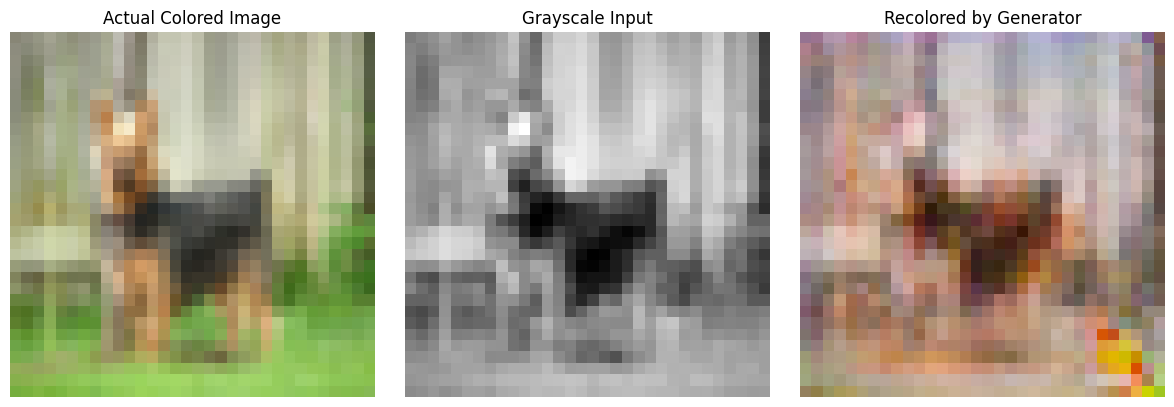

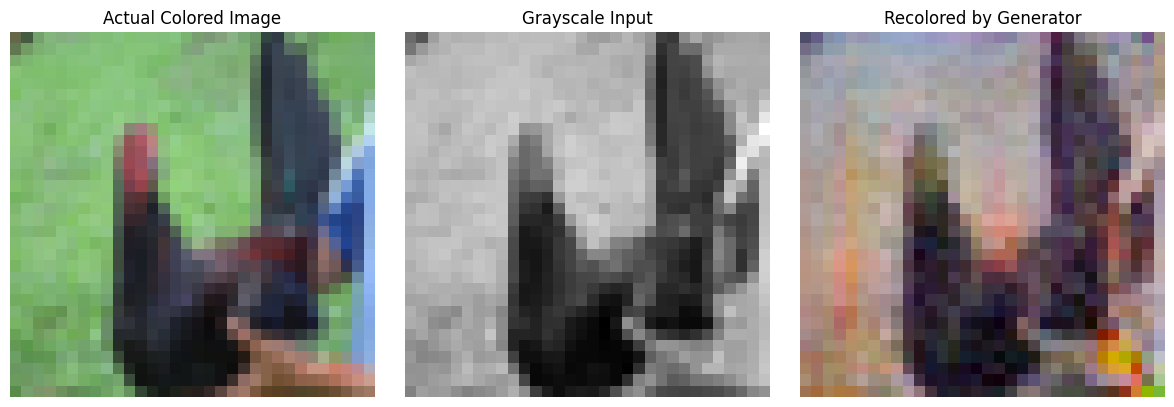

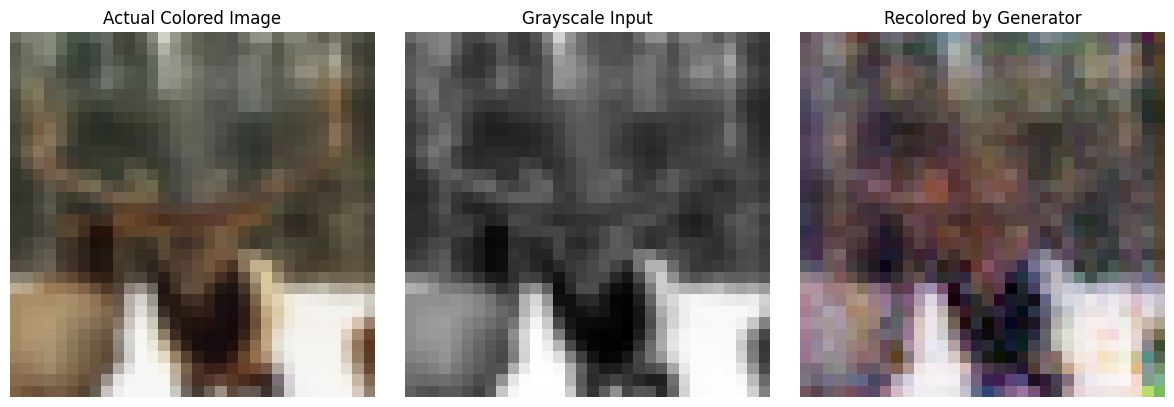

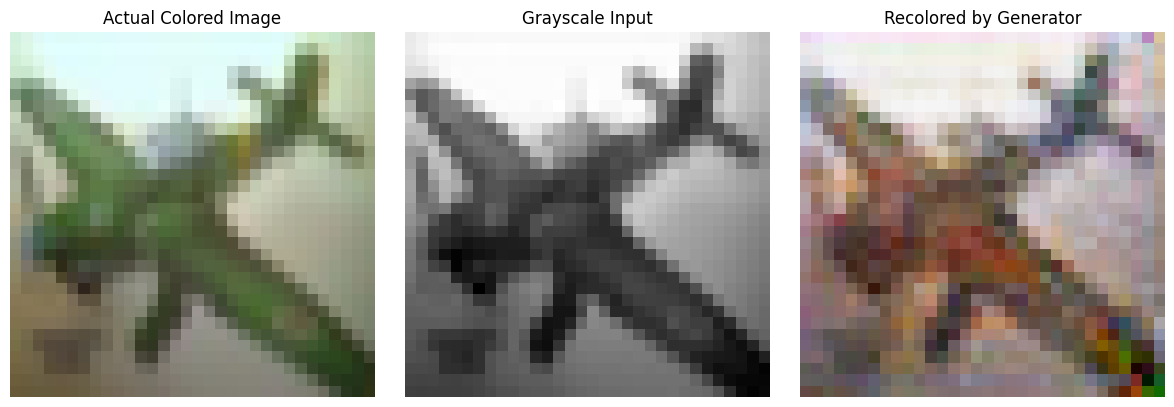

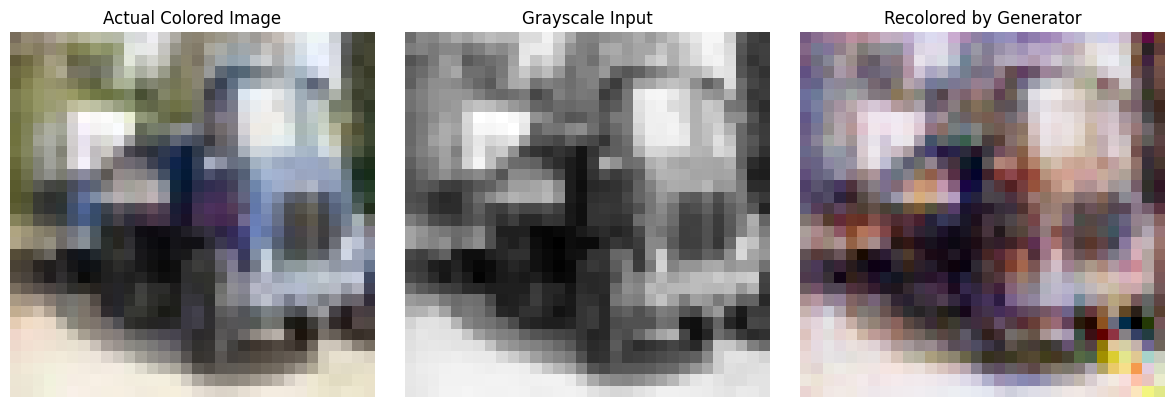

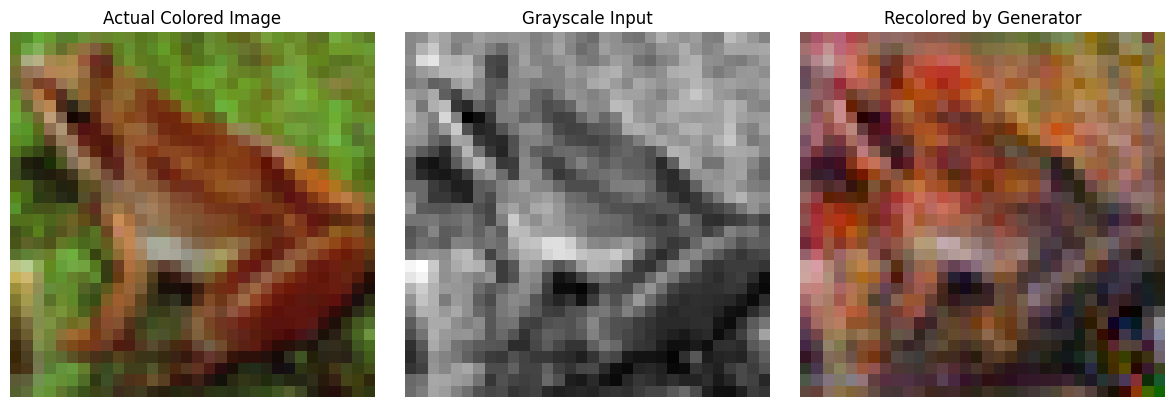

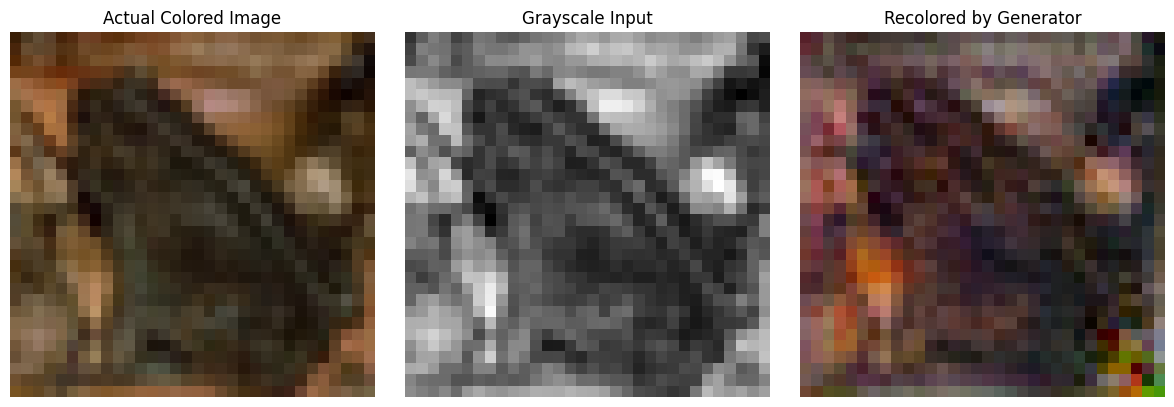

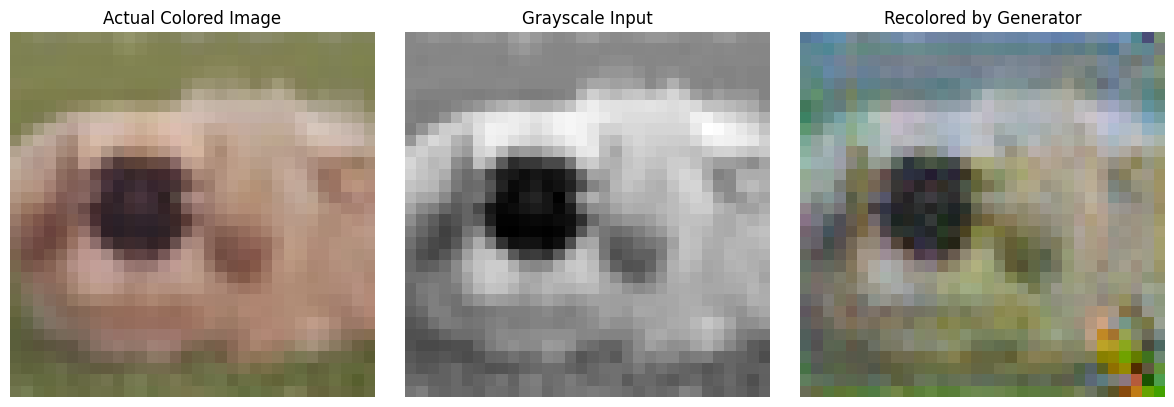

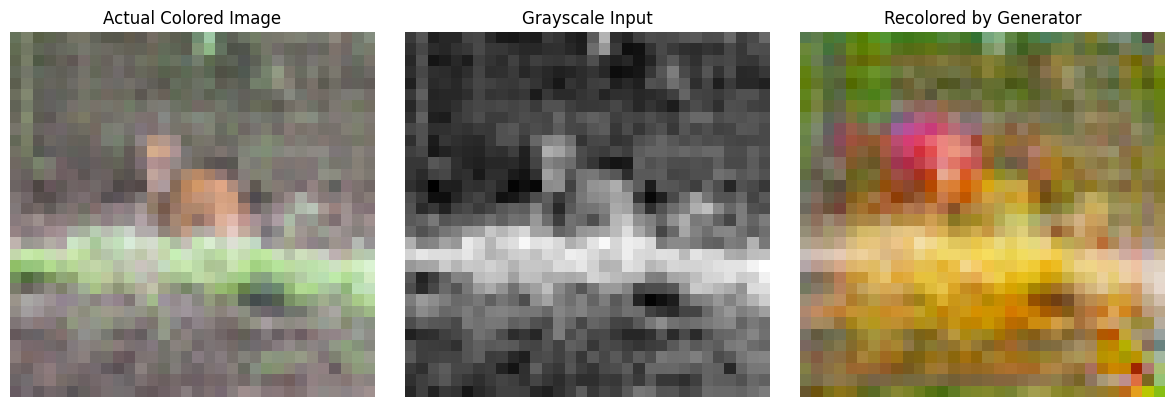

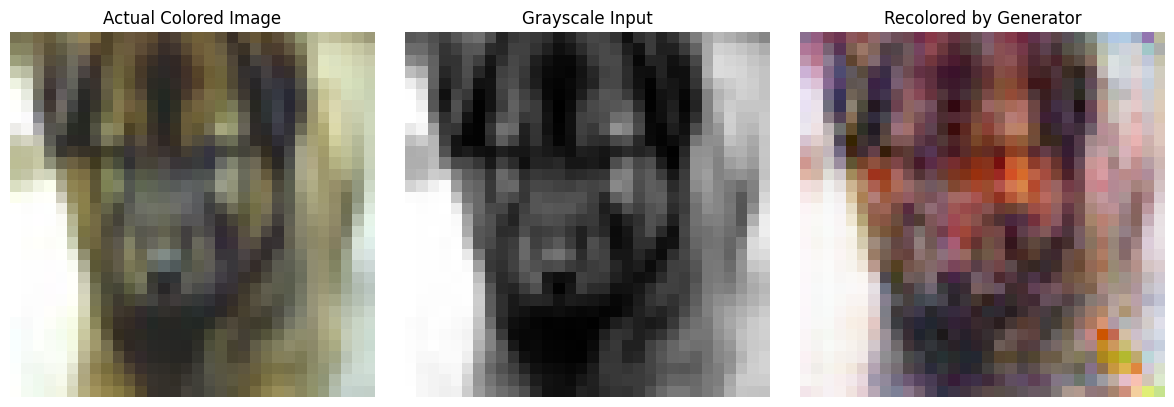

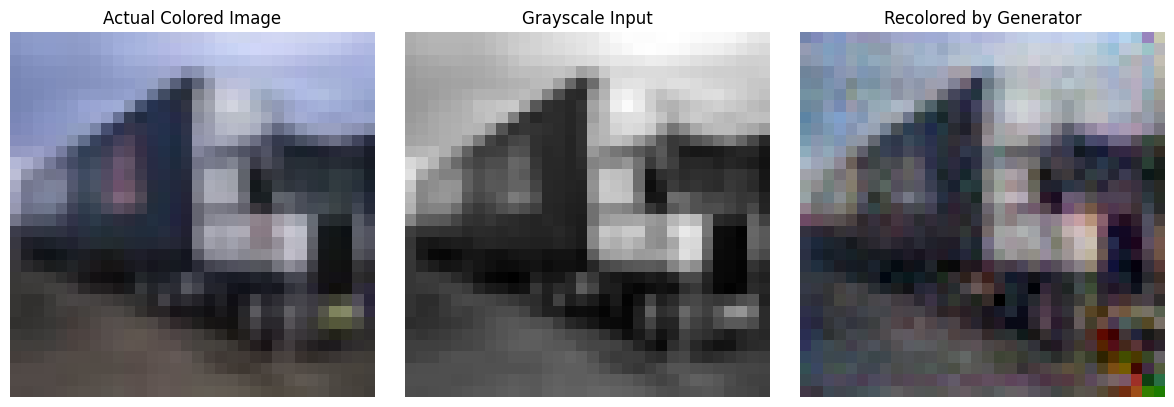

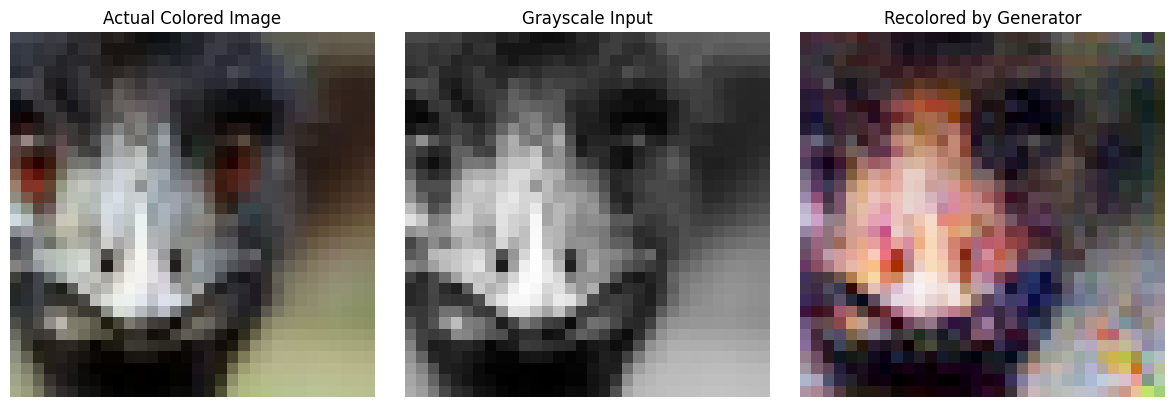

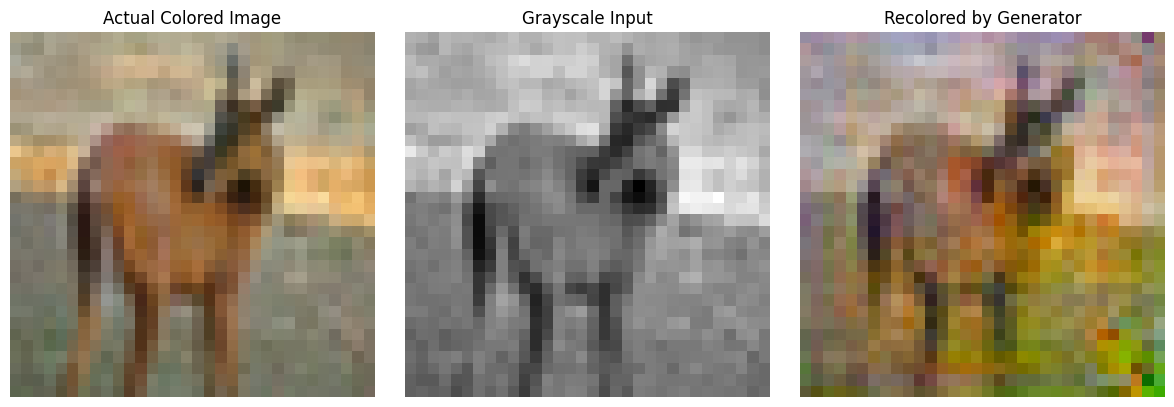

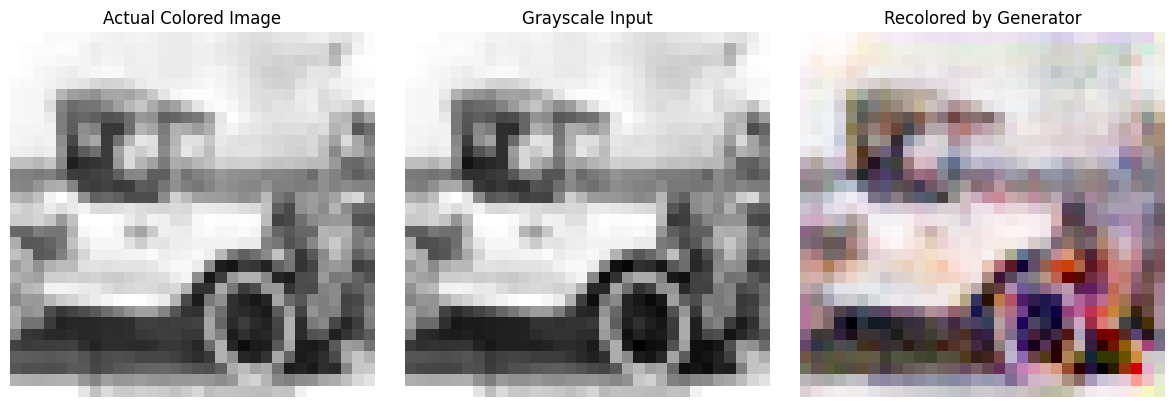

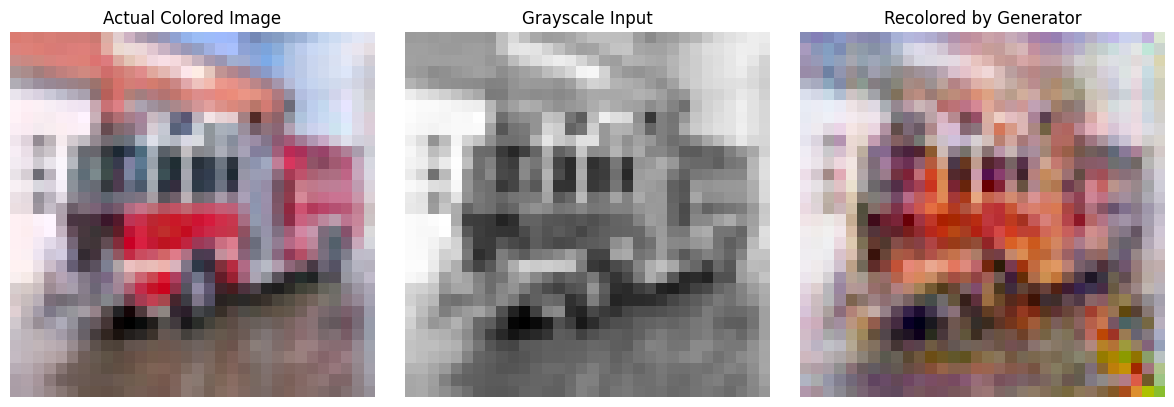

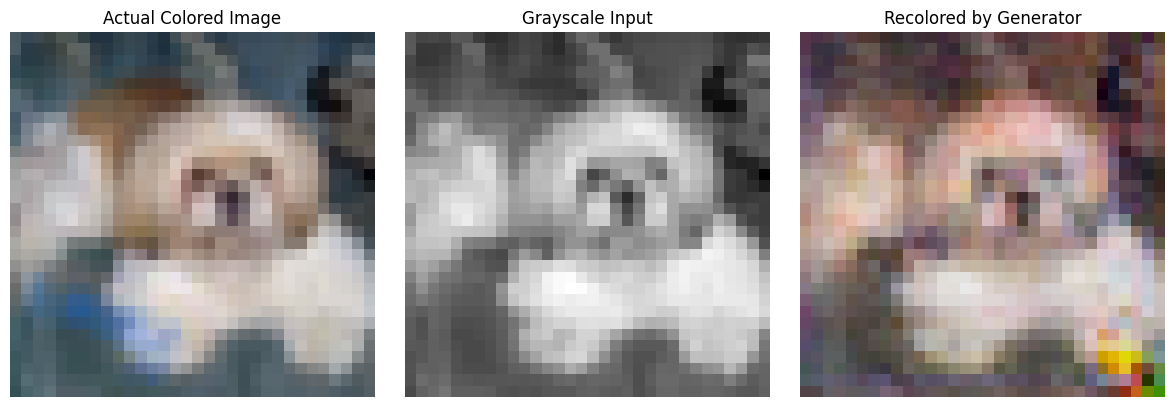

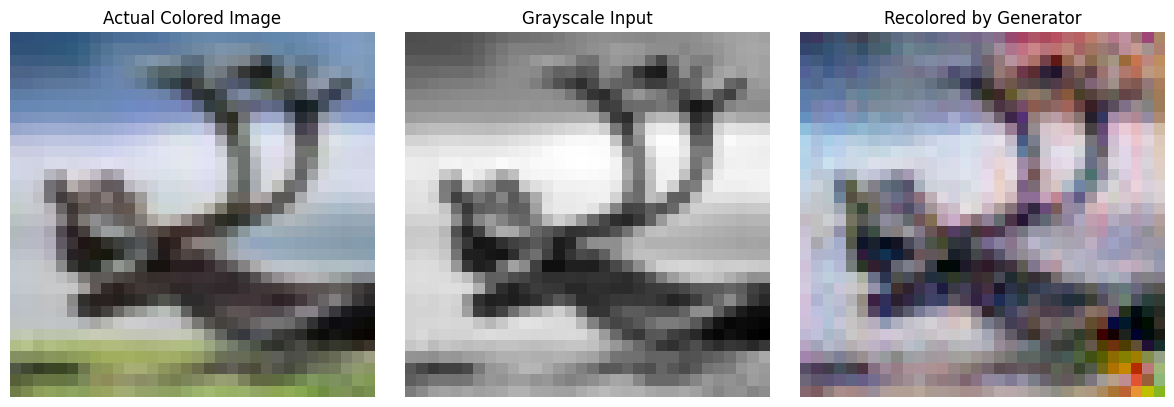

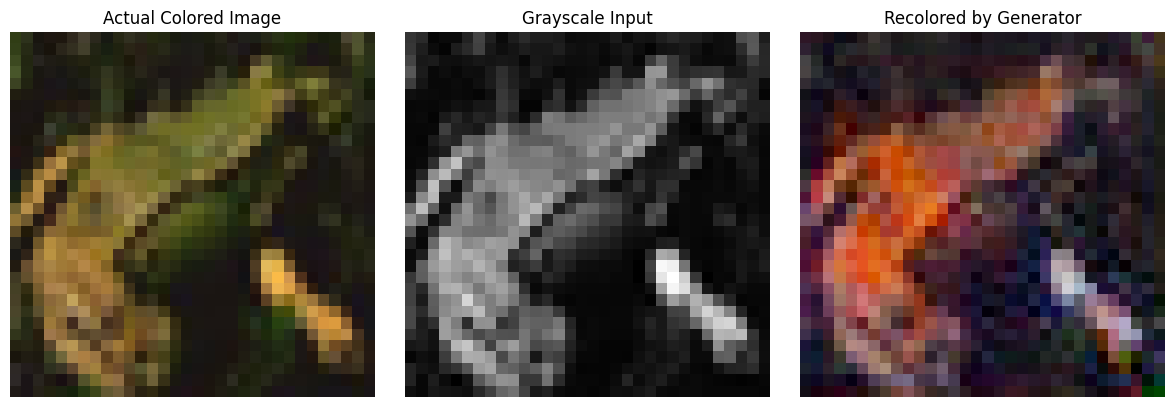

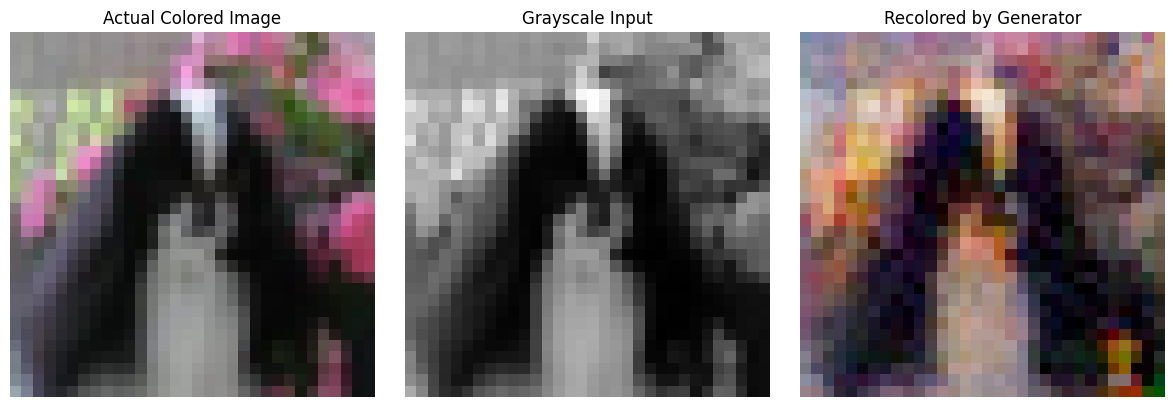

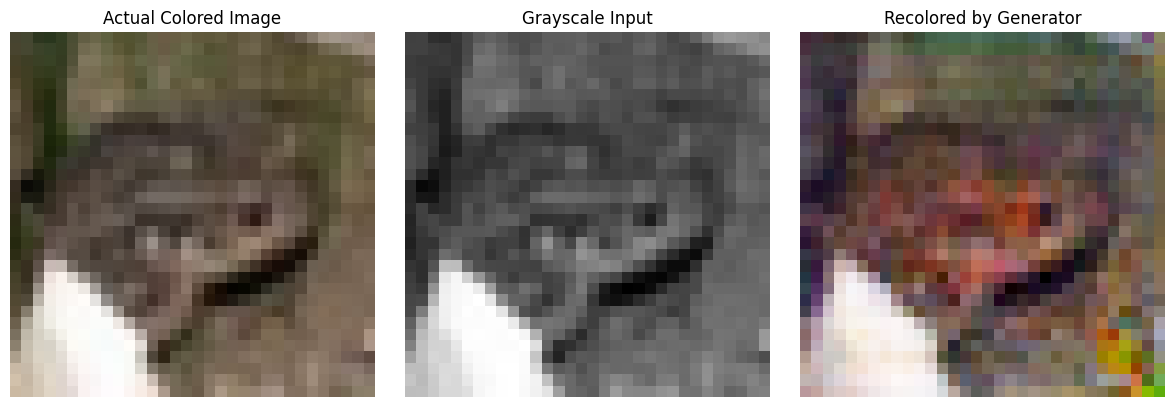

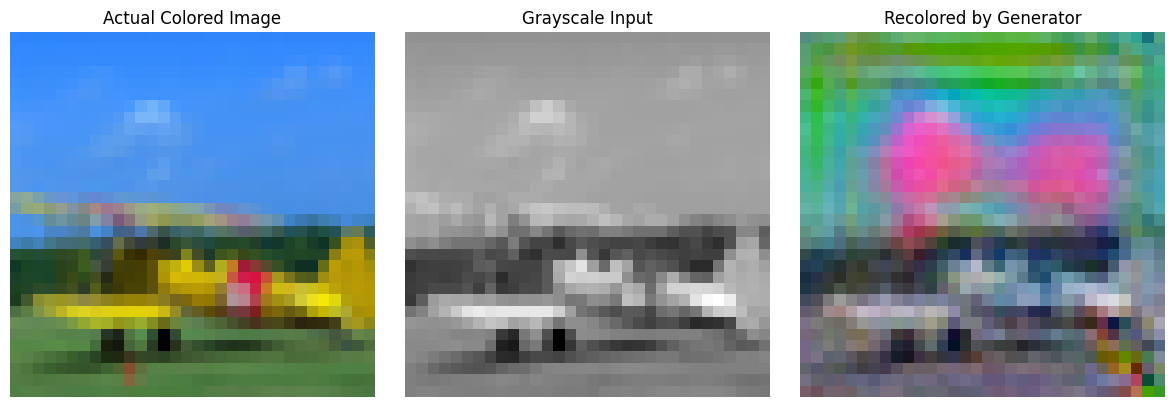

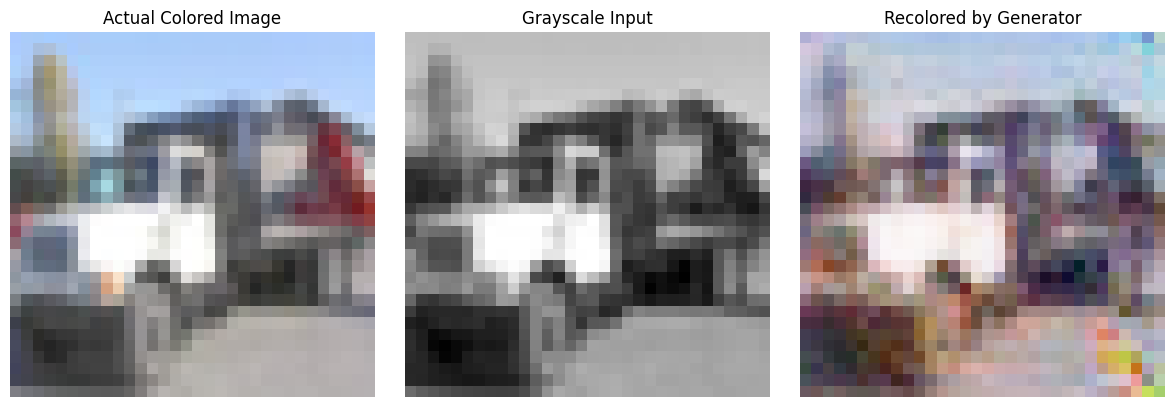

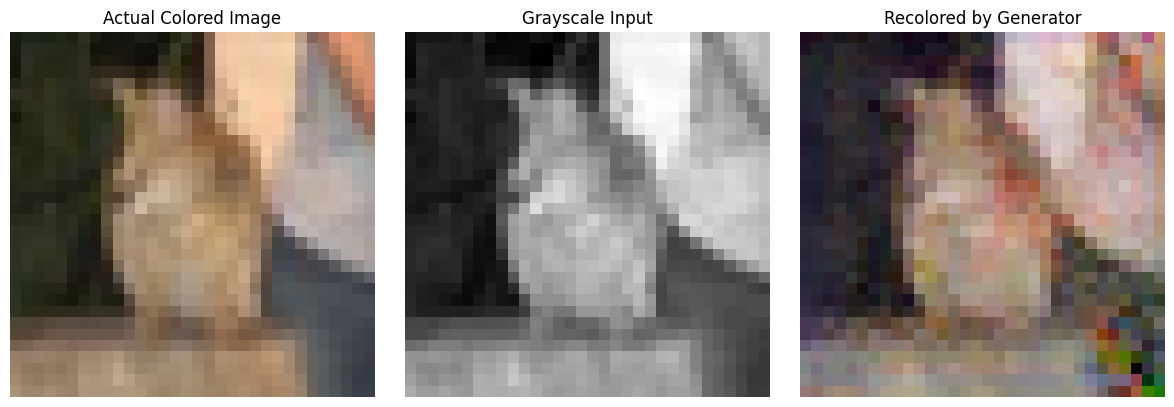

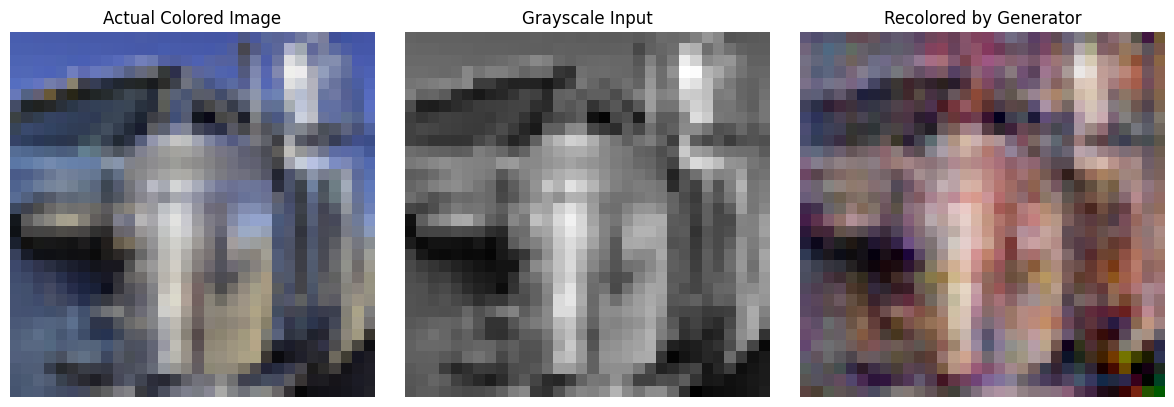

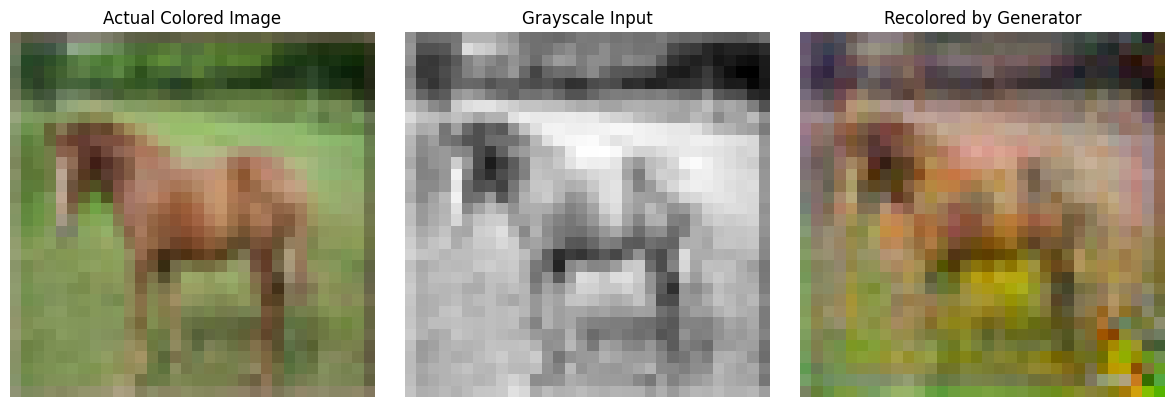

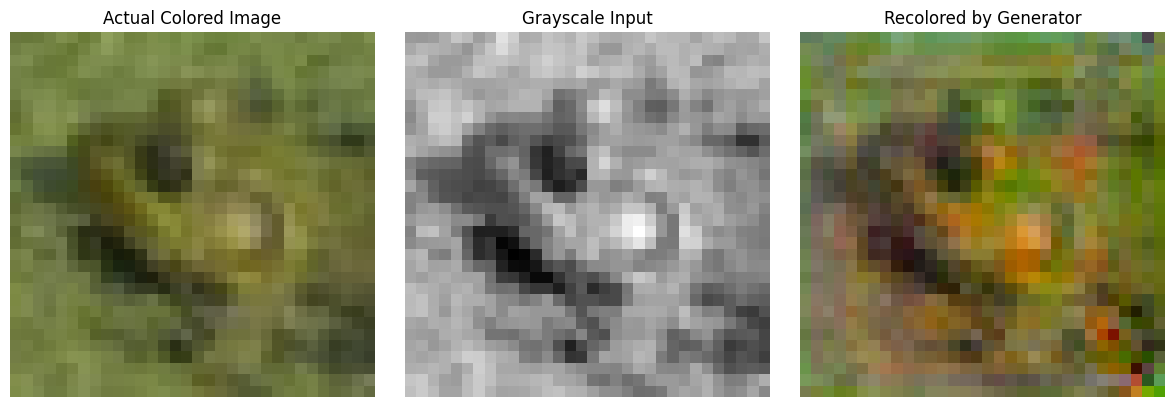

In [8]:
visualize_recolor_samples(generator, train_loader, test_loader, use_train=False, num_samples=50, device=device)


In [9]:
# Save locally
torch.save(generator.state_dict(), f'generator_epoch{epoch+1}.pth')
torch.save(discriminator.state_dict(), f'discriminator_epoch{epoch+1}.pth')
from google.colab import files

# Download to local machine
files.download(f'generator_epoch{epoch+1}.pth')
files.download(f'discriminator_epoch{epoch+1}.pth')
# Save checkpoint
torch.save({
    'epoch': epoch+1,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_g_state_dict': optimizer_g.state_dict(),
    'optimizer_d_state_dict': optimizer_d.state_dict(),
}, f'model_checkpoint_epoch{epoch+1}.pth')

# Download
files.download(f'model_checkpoint_epoch{epoch+1}.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch [101/200] Progress: 100.00%

=== Epoch [1/100] Summary ===
Discriminator Loss: 0.0847
Generator GAN Loss: 5.6466
Generator L1 Loss : 0.0571
Generator Total Loss (GAN + L1): 19.9216


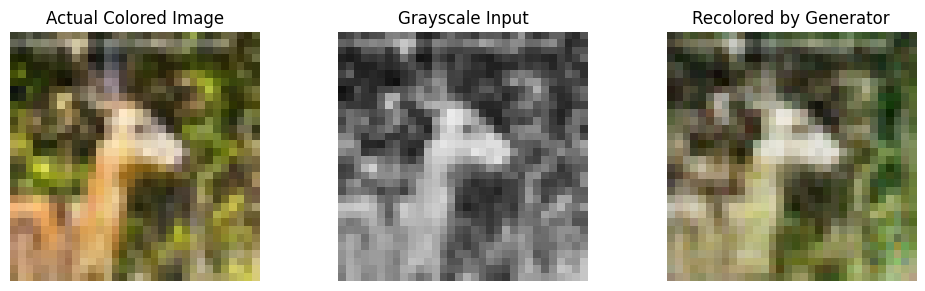

Epoch [102/200] Progress: 100.00%

=== Epoch [2/100] Summary ===
Discriminator Loss: 0.1689
Generator GAN Loss: 3.2049
Generator L1 Loss : 0.0580
Generator Total Loss (GAN + L1): 17.7020


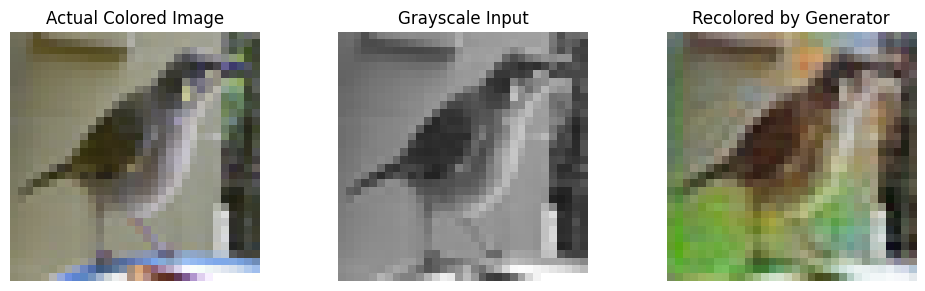

Epoch [103/200] Progress: 100.00%

=== Epoch [3/100] Summary ===
Discriminator Loss: 0.1013
Generator GAN Loss: 4.0737
Generator L1 Loss : 0.0618
Generator Total Loss (GAN + L1): 19.5318


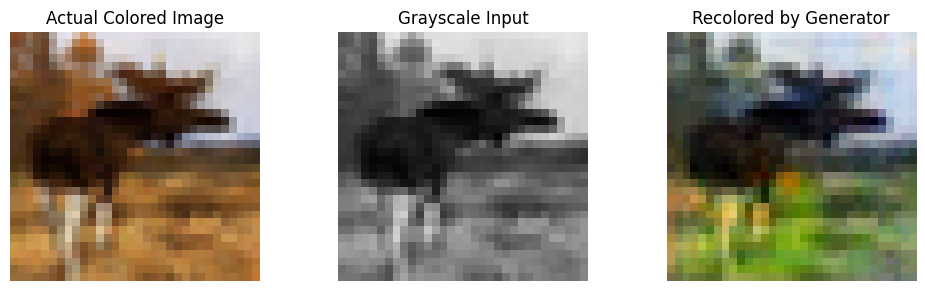

Epoch [104/200] Progress: 100.00%

=== Epoch [4/100] Summary ===
Discriminator Loss: 0.0942
Generator GAN Loss: 4.5645
Generator L1 Loss : 0.0602
Generator Total Loss (GAN + L1): 19.6171


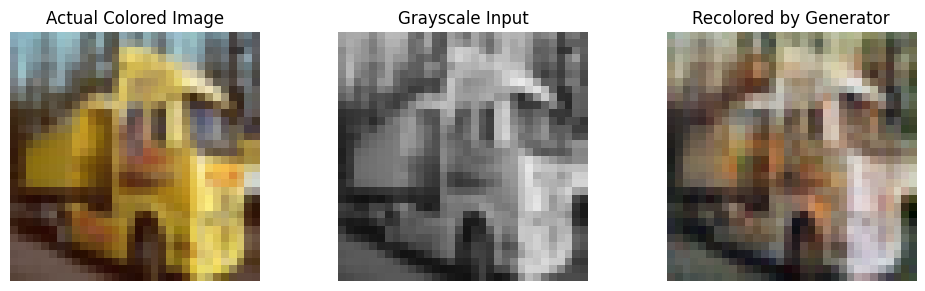

Epoch [105/200] Progress: 100.00%

=== Epoch [5/100] Summary ===
Discriminator Loss: 0.0848
Generator GAN Loss: 5.4815
Generator L1 Loss : 0.0588
Generator Total Loss (GAN + L1): 20.1912


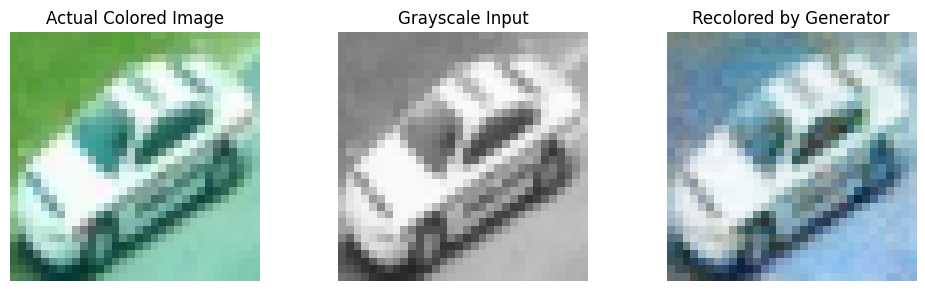

Epoch [106/200] Progress: 100.00%

=== Epoch [6/100] Summary ===
Discriminator Loss: 0.0835
Generator GAN Loss: 5.8020
Generator L1 Loss : 0.0571
Generator Total Loss (GAN + L1): 20.0748


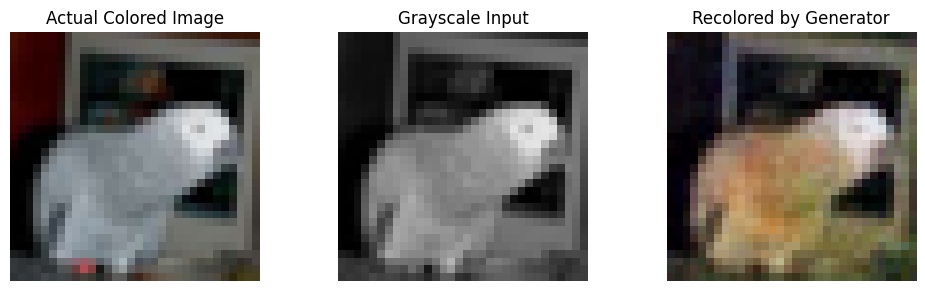

Epoch [107/200] Progress: 100.00%

=== Epoch [7/100] Summary ===
Discriminator Loss: 0.1071
Generator GAN Loss: 4.5924
Generator L1 Loss : 0.0582
Generator Total Loss (GAN + L1): 19.1503


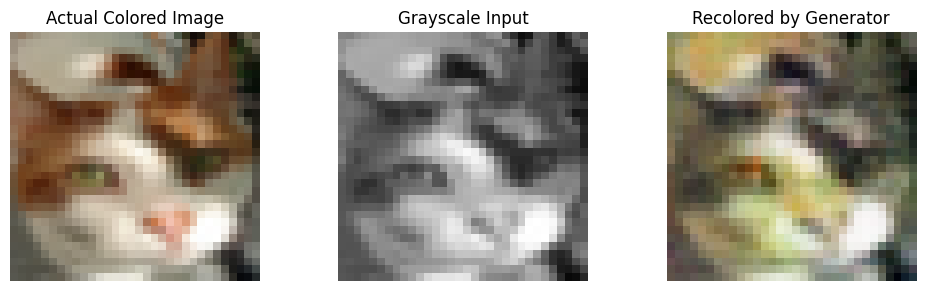

Epoch [108/200] Progress: 100.00%

=== Epoch [8/100] Summary ===
Discriminator Loss: 0.0946
Generator GAN Loss: 4.5344
Generator L1 Loss : 0.0604
Generator Total Loss (GAN + L1): 19.6337


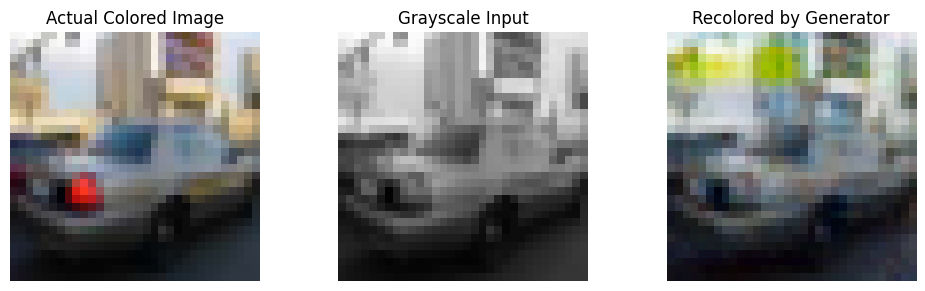

Epoch [109/200] Progress: 100.00%

=== Epoch [9/100] Summary ===
Discriminator Loss: 0.0843
Generator GAN Loss: 5.7350
Generator L1 Loss : 0.0587
Generator Total Loss (GAN + L1): 20.3984


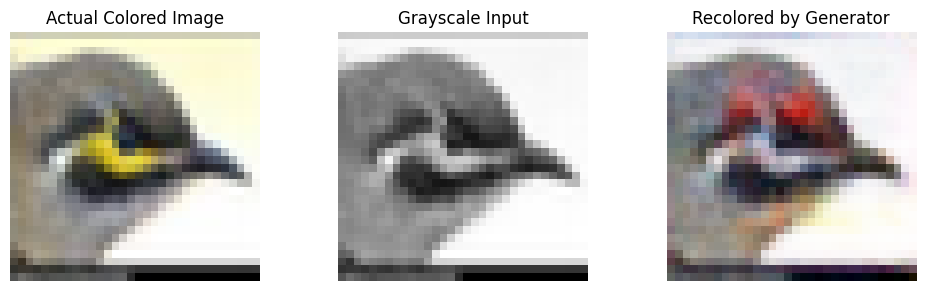

Epoch [110/200] Progress: 100.00%

=== Epoch [10/100] Summary ===
Discriminator Loss: 0.0833
Generator GAN Loss: 6.0595
Generator L1 Loss : 0.0571
Generator Total Loss (GAN + L1): 20.3362


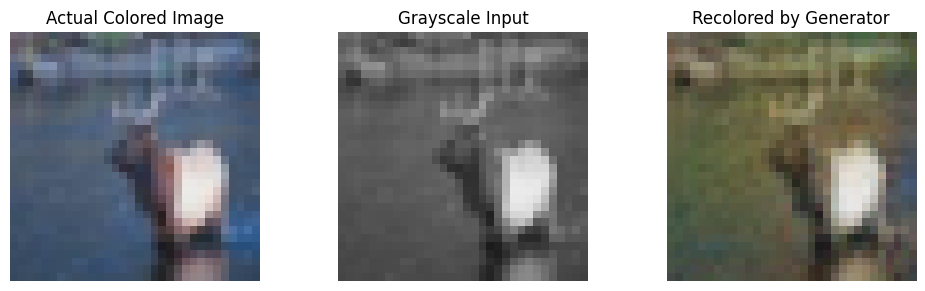

Epoch [111/200] Progress: 100.00%

=== Epoch [11/100] Summary ===
Discriminator Loss: 0.0828
Generator GAN Loss: 6.1955
Generator L1 Loss : 0.0562
Generator Total Loss (GAN + L1): 20.2391


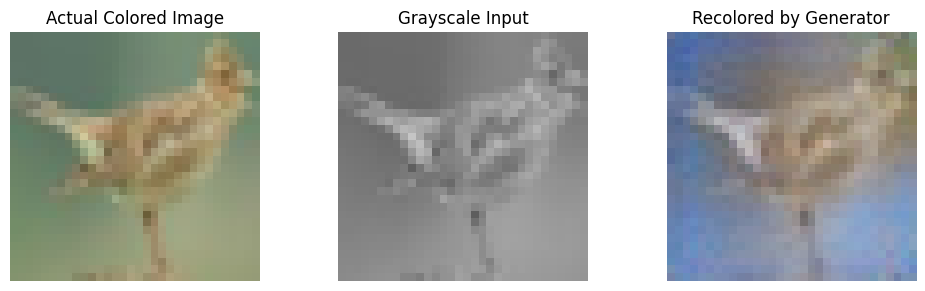

Epoch [112/200] Progress: 100.00%

=== Epoch [12/100] Summary ===
Discriminator Loss: 0.1278
Generator GAN Loss: 5.0935
Generator L1 Loss : 0.0561
Generator Total Loss (GAN + L1): 19.1176


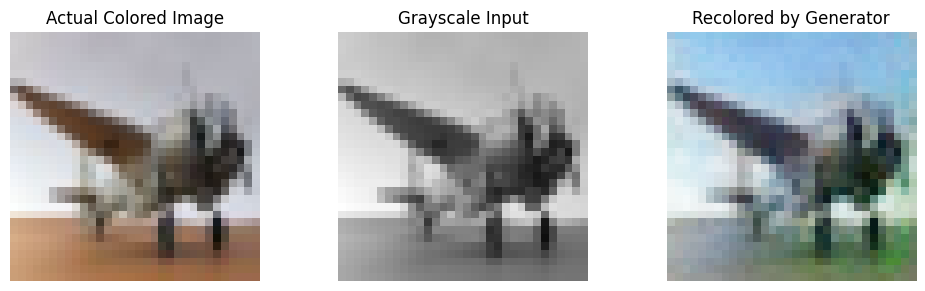

Epoch [113/200] Progress: 100.00%

=== Epoch [13/100] Summary ===
Discriminator Loss: 0.1409
Generator GAN Loss: 3.4780
Generator L1 Loss : 0.0597
Generator Total Loss (GAN + L1): 18.4083


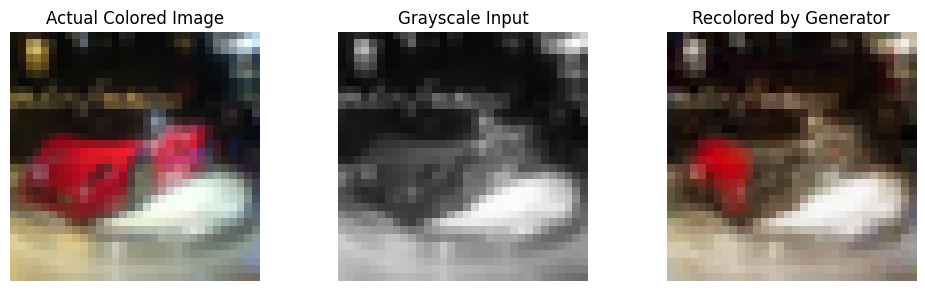

Epoch [114/200] Progress: 100.00%

=== Epoch [14/100] Summary ===
Discriminator Loss: 0.0857
Generator GAN Loss: 5.6515
Generator L1 Loss : 0.0576
Generator Total Loss (GAN + L1): 20.0577


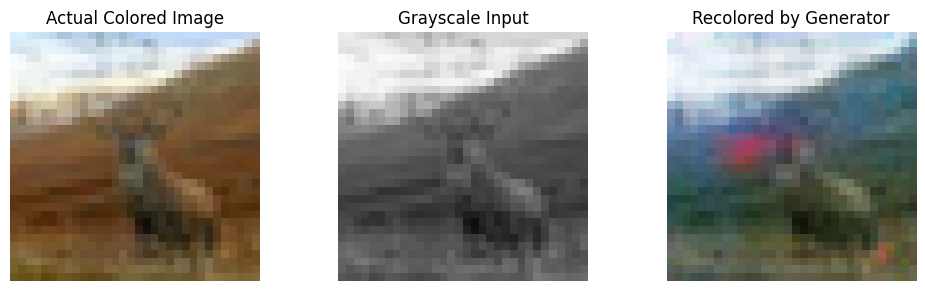

Epoch [115/200] Progress: 100.00%

=== Epoch [15/100] Summary ===
Discriminator Loss: 0.0833
Generator GAN Loss: 6.3264
Generator L1 Loss : 0.0548
Generator Total Loss (GAN + L1): 20.0288


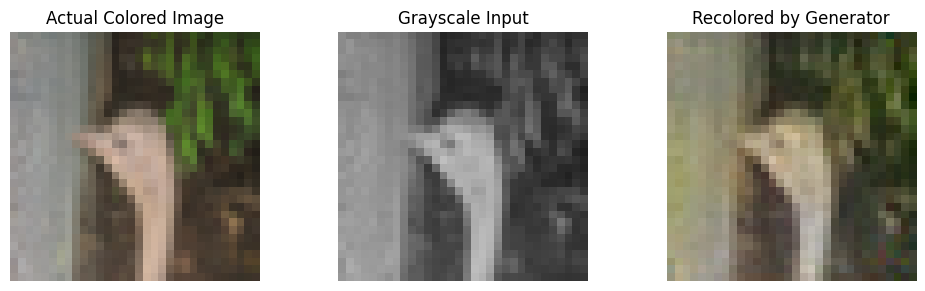

Epoch [116/200] Progress: 100.00%

=== Epoch [16/100] Summary ===
Discriminator Loss: 0.0946
Generator GAN Loss: 6.6325
Generator L1 Loss : 0.0534
Generator Total Loss (GAN + L1): 19.9857


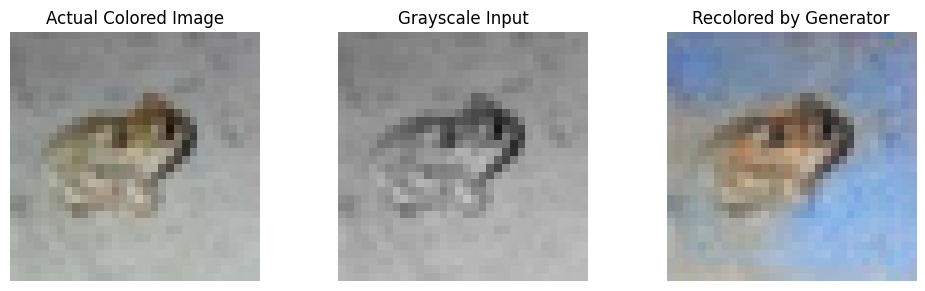

Epoch [117/200] Progress: 100.00%

=== Epoch [17/100] Summary ===
Discriminator Loss: 0.1178
Generator GAN Loss: 3.5007
Generator L1 Loss : 0.0600
Generator Total Loss (GAN + L1): 18.5051


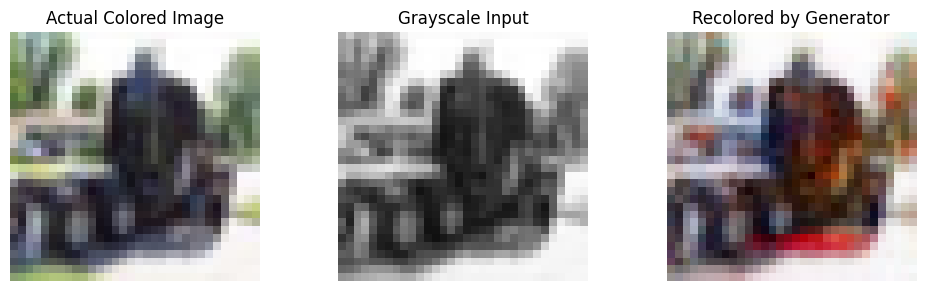

Epoch [118/200] Progress: 100.00%

=== Epoch [18/100] Summary ===
Discriminator Loss: 0.0858
Generator GAN Loss: 5.1364
Generator L1 Loss : 0.0594
Generator Total Loss (GAN + L1): 19.9974


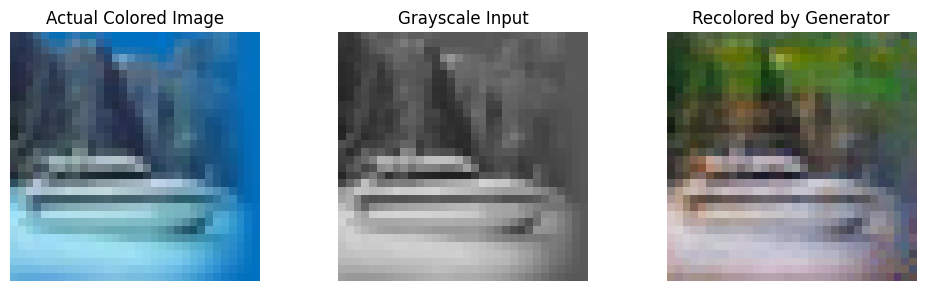

Epoch [119/200] Progress: 100.00%

=== Epoch [19/100] Summary ===
Discriminator Loss: 0.0933
Generator GAN Loss: 5.7560
Generator L1 Loss : 0.0576
Generator Total Loss (GAN + L1): 20.1668


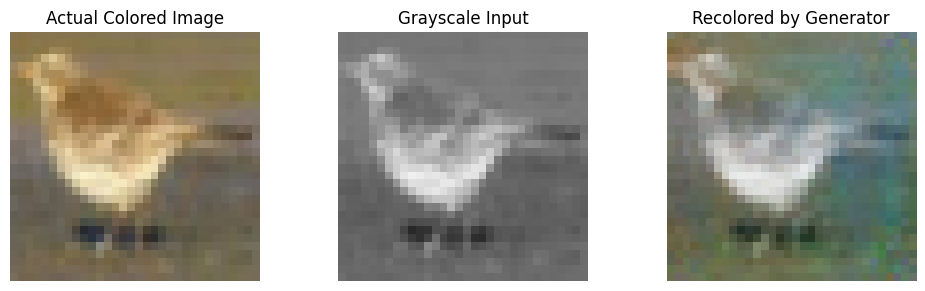

Epoch [120/200] Progress: 100.00%

=== Epoch [20/100] Summary ===
Discriminator Loss: 0.0893
Generator GAN Loss: 5.2254
Generator L1 Loss : 0.0585
Generator Total Loss (GAN + L1): 19.8623


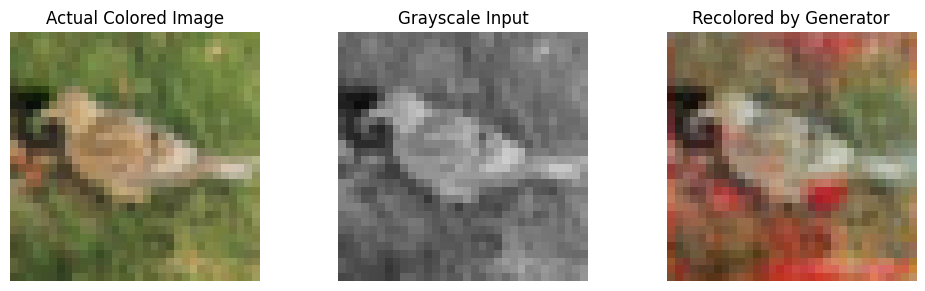

Epoch [121/200] Progress: 100.00%

=== Epoch [21/100] Summary ===
Discriminator Loss: 0.0828
Generator GAN Loss: 6.6530
Generator L1 Loss : 0.0564
Generator Total Loss (GAN + L1): 20.7495


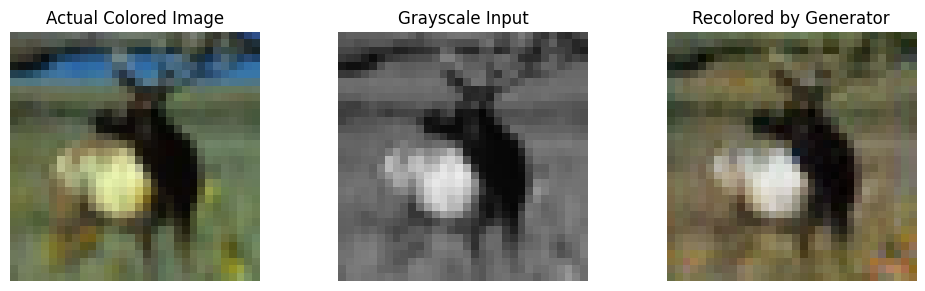

Epoch [122/200] Progress: 100.00%

=== Epoch [22/100] Summary ===
Discriminator Loss: 0.0823
Generator GAN Loss: 7.0554
Generator L1 Loss : 0.0553
Generator Total Loss (GAN + L1): 20.8698


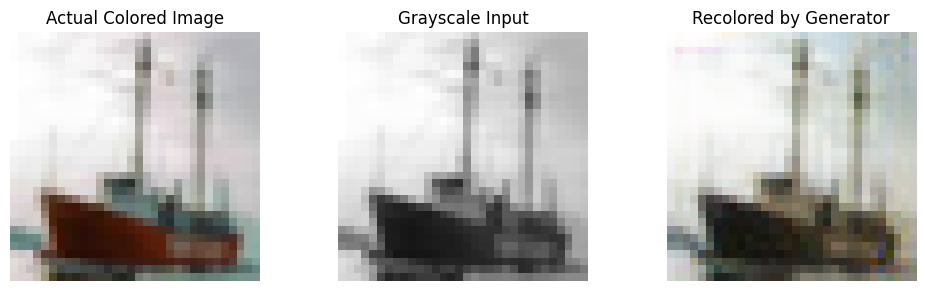

Epoch [123/200] Progress: 100.00%

=== Epoch [23/100] Summary ===
Discriminator Loss: 0.1246
Generator GAN Loss: 5.9299
Generator L1 Loss : 0.0547
Generator Total Loss (GAN + L1): 19.6090


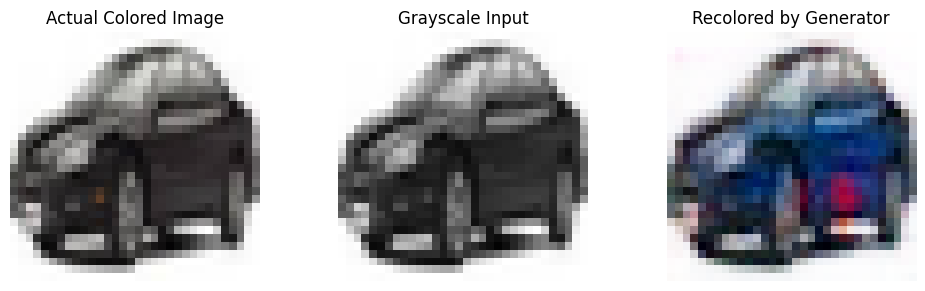

Epoch [124/200] Progress: 100.00%

=== Epoch [24/100] Summary ===
Discriminator Loss: 0.1230
Generator GAN Loss: 3.6544
Generator L1 Loss : 0.0598
Generator Total Loss (GAN + L1): 18.6054


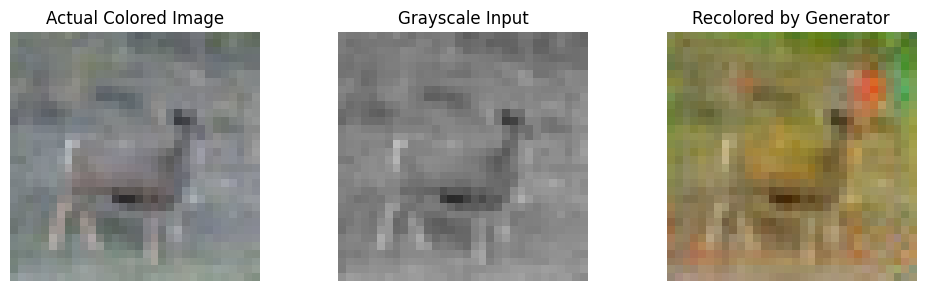

Epoch [125/200] Progress: 100.00%

=== Epoch [25/100] Summary ===
Discriminator Loss: 0.0905
Generator GAN Loss: 5.0251
Generator L1 Loss : 0.0604
Generator Total Loss (GAN + L1): 20.1210


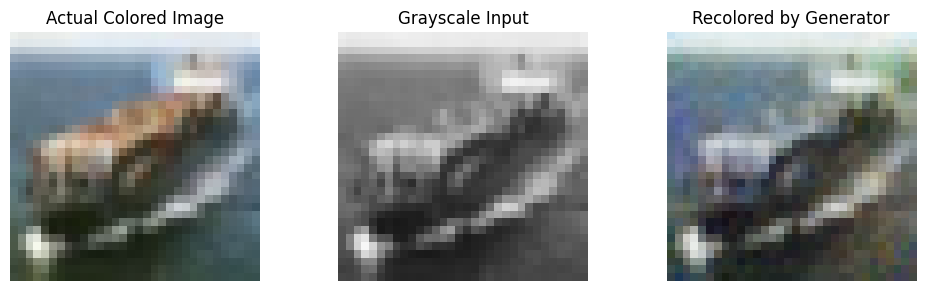

Epoch [126/200] Progress: 100.00%

=== Epoch [26/100] Summary ===
Discriminator Loss: 0.0835
Generator GAN Loss: 6.1637
Generator L1 Loss : 0.0589
Generator Total Loss (GAN + L1): 20.8959


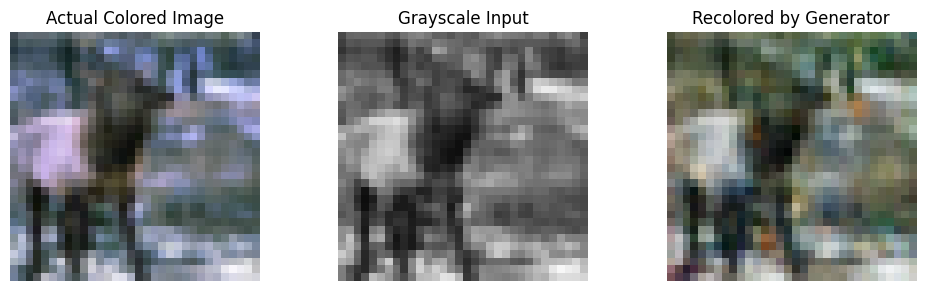

Epoch [127/200] Progress: 100.00%

=== Epoch [27/100] Summary ===
Discriminator Loss: 0.0828
Generator GAN Loss: 6.5499
Generator L1 Loss : 0.0567
Generator Total Loss (GAN + L1): 20.7356


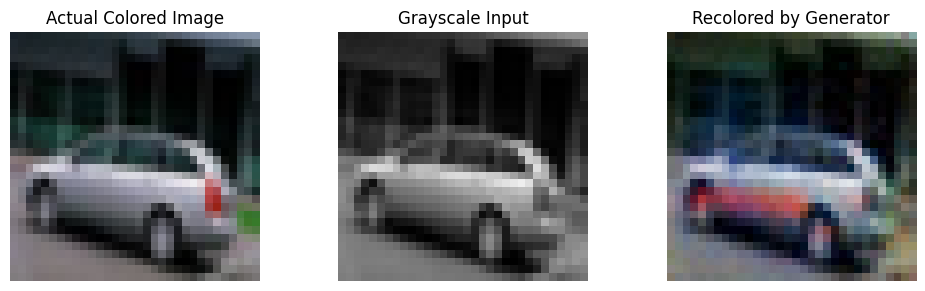

Epoch [128/200] Progress: 100.00%

=== Epoch [28/100] Summary ===
Discriminator Loss: 0.0825
Generator GAN Loss: 6.6545
Generator L1 Loss : 0.0553
Generator Total Loss (GAN + L1): 20.4918


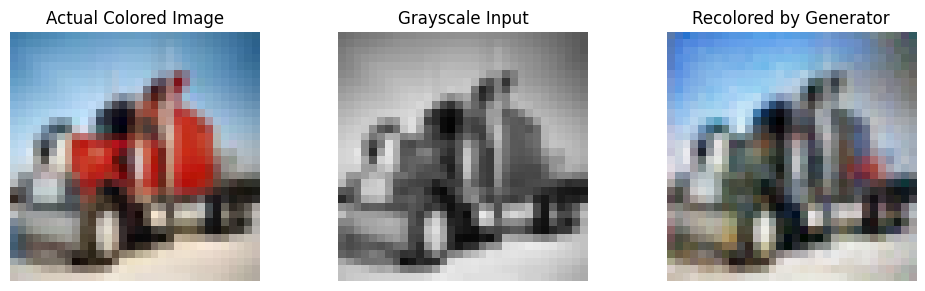

Epoch [129/200] Progress: 100.00%

=== Epoch [29/100] Summary ===
Discriminator Loss: 0.0825
Generator GAN Loss: 6.7158
Generator L1 Loss : 0.0547
Generator Total Loss (GAN + L1): 20.3925


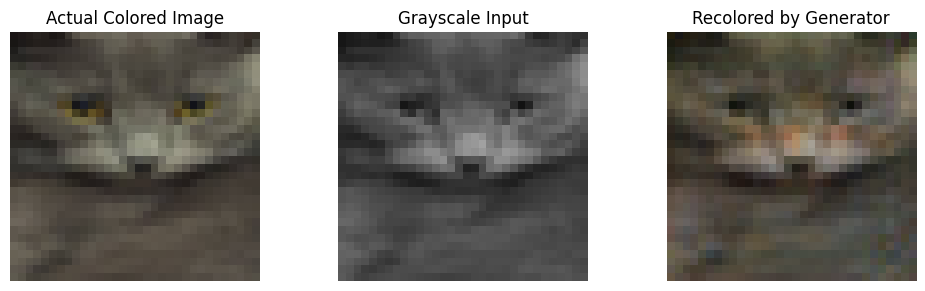

Epoch [130/200] Progress: 100.00%

=== Epoch [30/100] Summary ===
Discriminator Loss: 0.0826
Generator GAN Loss: 6.7019
Generator L1 Loss : 0.0543
Generator Total Loss (GAN + L1): 20.2791


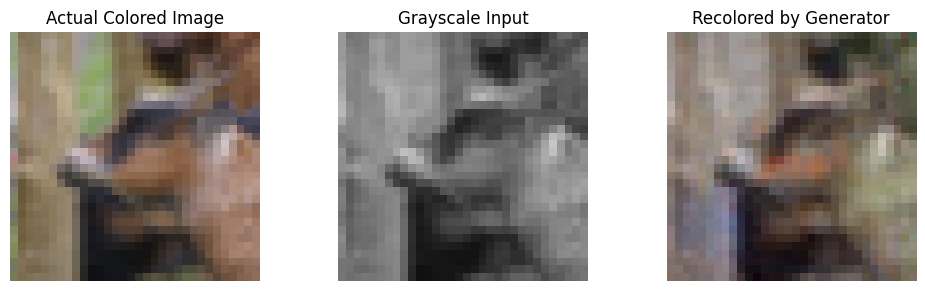

Epoch [131/200] Progress: 100.00%

=== Epoch [31/100] Summary ===
Discriminator Loss: 0.1523
Generator GAN Loss: 4.7165
Generator L1 Loss : 0.0554
Generator Total Loss (GAN + L1): 18.5782


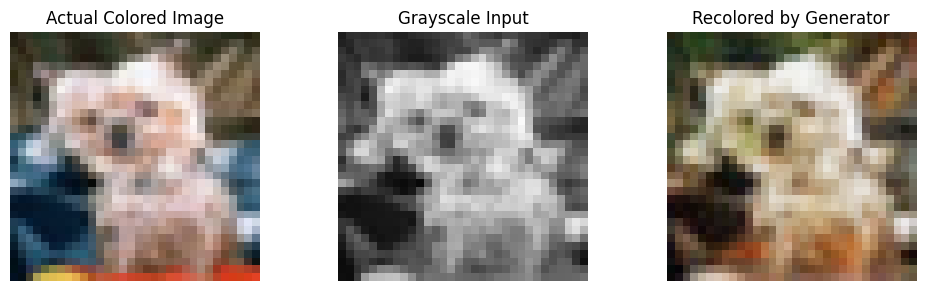

Epoch [132/200] Progress: 100.00%

=== Epoch [32/100] Summary ===
Discriminator Loss: 0.1340
Generator GAN Loss: 3.2405
Generator L1 Loss : 0.0600
Generator Total Loss (GAN + L1): 18.2432


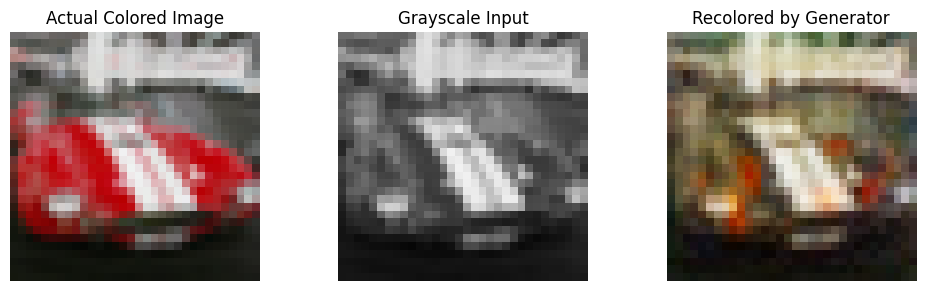

Epoch [133/200] Progress: 100.00%

=== Epoch [33/100] Summary ===
Discriminator Loss: 0.0847
Generator GAN Loss: 5.6992
Generator L1 Loss : 0.0593
Generator Total Loss (GAN + L1): 20.5276


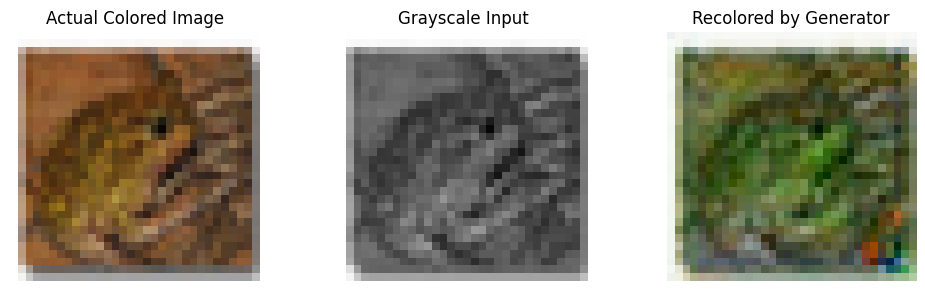

Epoch [134/200] Progress: 100.00%

=== Epoch [34/100] Summary ===
Discriminator Loss: 0.1103
Generator GAN Loss: 4.2264
Generator L1 Loss : 0.0601
Generator Total Loss (GAN + L1): 19.2609


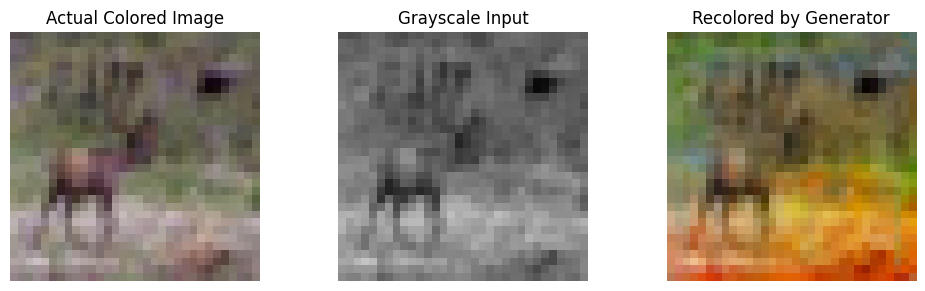

Epoch [135/200] Progress: 100.00%

=== Epoch [35/100] Summary ===
Discriminator Loss: 0.0853
Generator GAN Loss: 5.6124
Generator L1 Loss : 0.0587
Generator Total Loss (GAN + L1): 20.2977


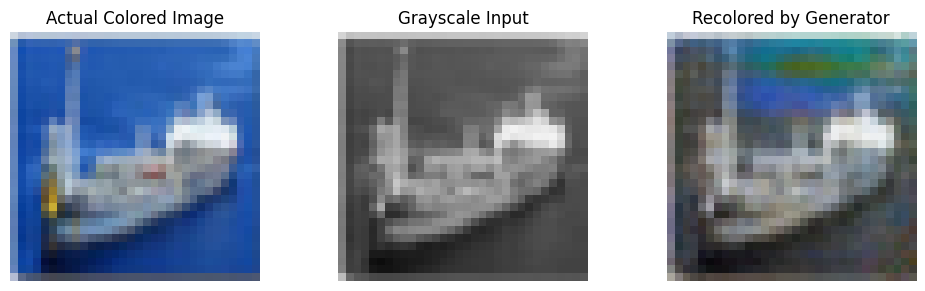

Epoch [136/200] Progress: 100.00%

=== Epoch [36/100] Summary ===
Discriminator Loss: 0.0830
Generator GAN Loss: 6.4165
Generator L1 Loss : 0.0573
Generator Total Loss (GAN + L1): 20.7333


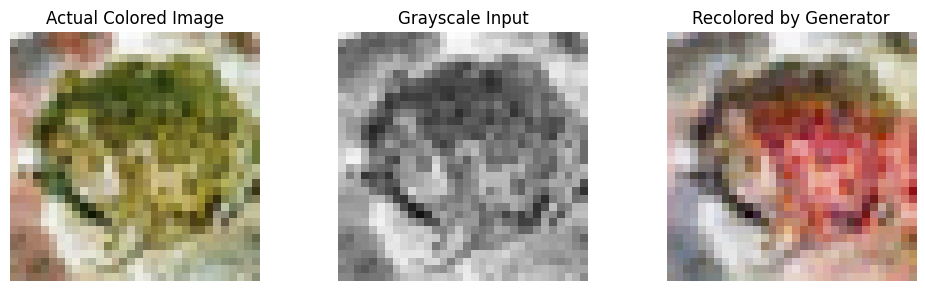

Epoch [137/200] Progress: 100.00%

=== Epoch [37/100] Summary ===
Discriminator Loss: 0.1047
Generator GAN Loss: 4.8380
Generator L1 Loss : 0.0589
Generator Total Loss (GAN + L1): 19.5701


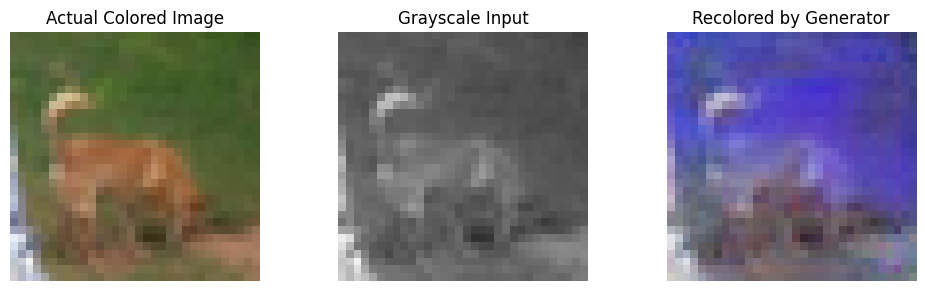

Epoch [138/200] Progress: 100.00%

=== Epoch [38/100] Summary ===
Discriminator Loss: 0.0836
Generator GAN Loss: 6.1986
Generator L1 Loss : 0.0585
Generator Total Loss (GAN + L1): 20.8258


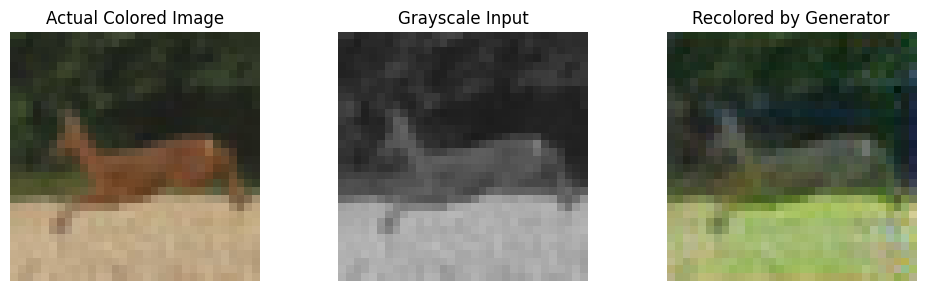

Epoch [139/200] Progress: 100.00%

=== Epoch [39/100] Summary ===
Discriminator Loss: 0.0825
Generator GAN Loss: 6.8073
Generator L1 Loss : 0.0563
Generator Total Loss (GAN + L1): 20.8908


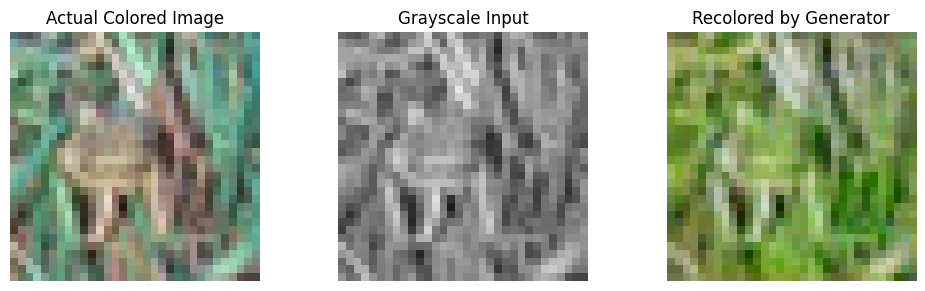

Epoch [140/200] Progress: 100.00%

=== Epoch [40/100] Summary ===
Discriminator Loss: 0.0824
Generator GAN Loss: 6.9773
Generator L1 Loss : 0.0547
Generator Total Loss (GAN + L1): 20.6641


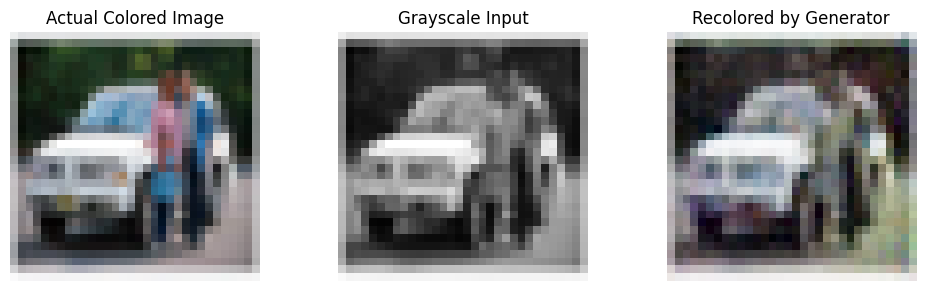

Epoch [141/200] Progress: 100.00%

=== Epoch [41/100] Summary ===
Discriminator Loss: 0.1209
Generator GAN Loss: 4.2134
Generator L1 Loss : 0.0576
Generator Total Loss (GAN + L1): 18.6103


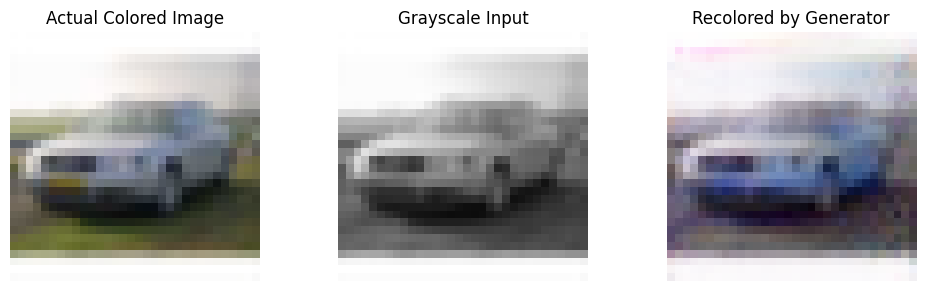

Epoch [142/200] Progress: 100.00%

=== Epoch [42/100] Summary ===
Discriminator Loss: 0.0840
Generator GAN Loss: 5.6908
Generator L1 Loss : 0.0593
Generator Total Loss (GAN + L1): 20.5256


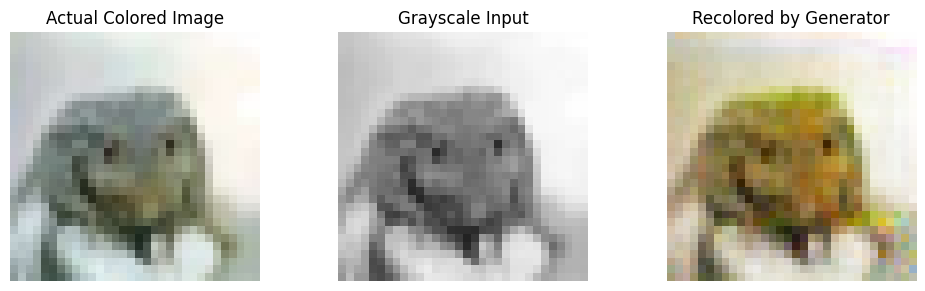

Epoch [143/200] Progress: 100.00%

=== Epoch [43/100] Summary ===
Discriminator Loss: 0.0826
Generator GAN Loss: 6.6534
Generator L1 Loss : 0.0591
Generator Total Loss (GAN + L1): 21.4174


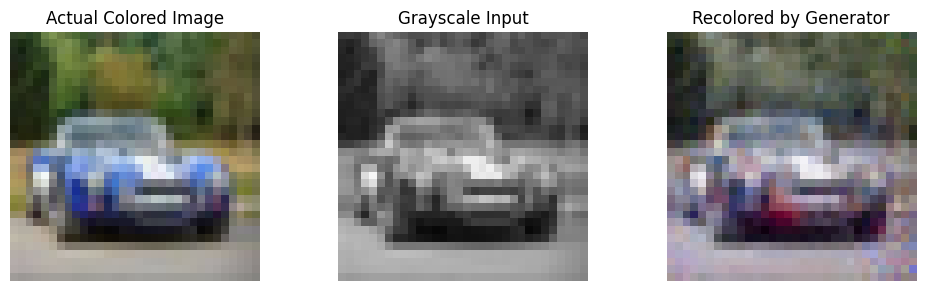

Epoch [144/200] Progress: 100.00%

=== Epoch [44/100] Summary ===
Discriminator Loss: 0.0823
Generator GAN Loss: 6.9436
Generator L1 Loss : 0.0566
Generator Total Loss (GAN + L1): 21.0849


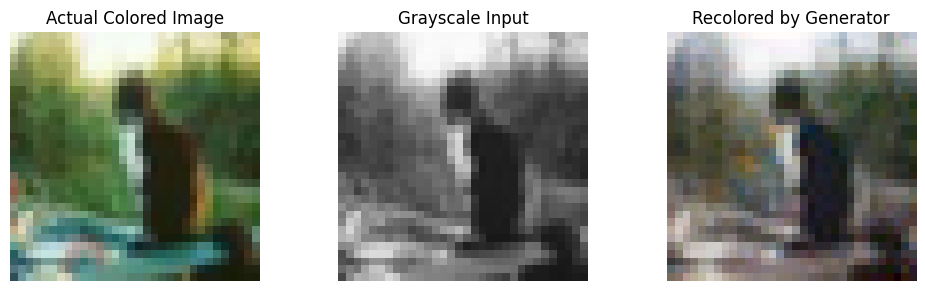

Epoch [145/200] Progress: 100.00%

=== Epoch [45/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.2717
Generator L1 Loss : 0.0547
Generator Total Loss (GAN + L1): 20.9572


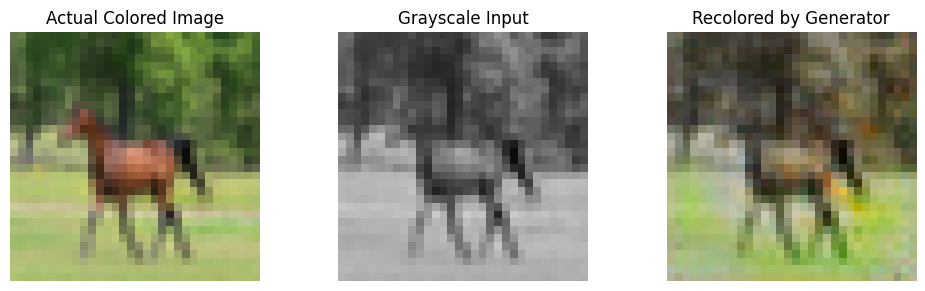

Epoch [146/200] Progress: 100.00%

=== Epoch [46/100] Summary ===
Discriminator Loss: 0.1100
Generator GAN Loss: 5.3316
Generator L1 Loss : 0.0563
Generator Total Loss (GAN + L1): 19.4065


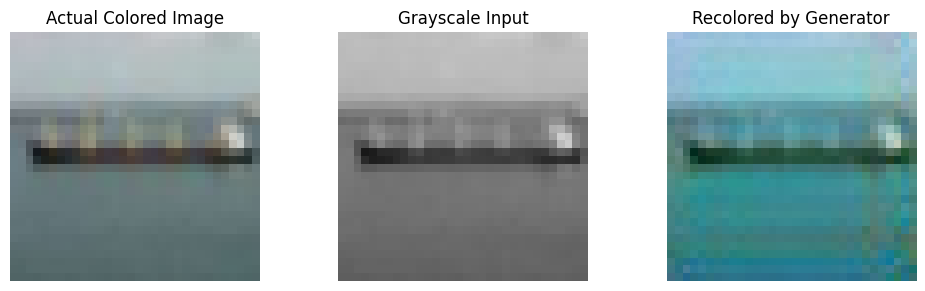

Epoch [147/200] Progress: 100.00%

=== Epoch [47/100] Summary ===
Discriminator Loss: 0.0838
Generator GAN Loss: 5.8575
Generator L1 Loss : 0.0593
Generator Total Loss (GAN + L1): 20.6881


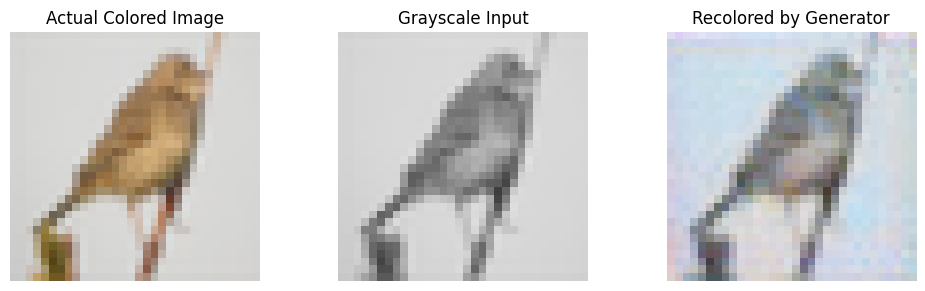

Epoch [148/200] Progress: 100.00%

=== Epoch [48/100] Summary ===
Discriminator Loss: 0.0824
Generator GAN Loss: 6.8371
Generator L1 Loss : 0.0578
Generator Total Loss (GAN + L1): 21.2829


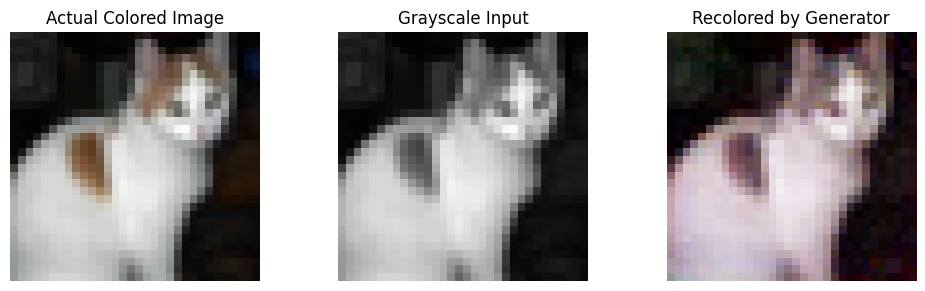

Epoch [149/200] Progress: 100.00%

=== Epoch [49/100] Summary ===
Discriminator Loss: 0.0822
Generator GAN Loss: 7.0308
Generator L1 Loss : 0.0564
Generator Total Loss (GAN + L1): 21.1375


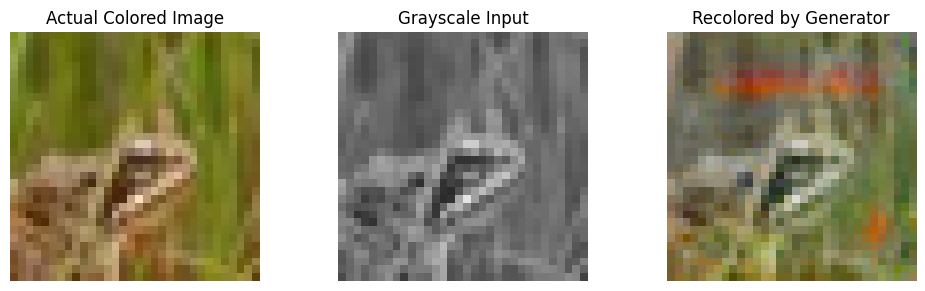

Epoch [150/200] Progress: 100.00%

=== Epoch [50/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.3784
Generator L1 Loss : 0.0553
Generator Total Loss (GAN + L1): 21.2156


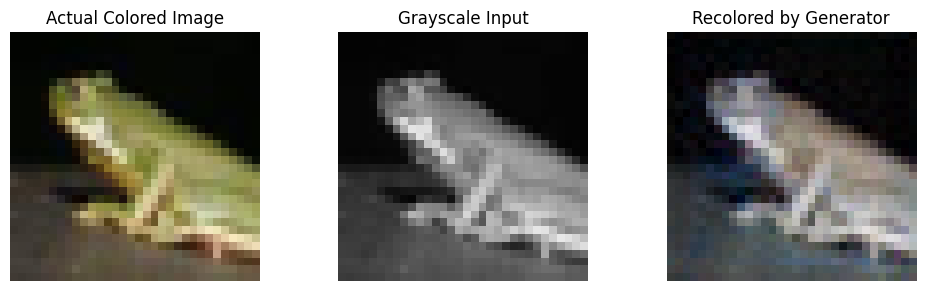

Epoch [151/200] Progress: 100.00%

=== Epoch [51/100] Summary ===
Discriminator Loss: 0.1396
Generator GAN Loss: 4.7498
Generator L1 Loss : 0.0561
Generator Total Loss (GAN + L1): 18.7729


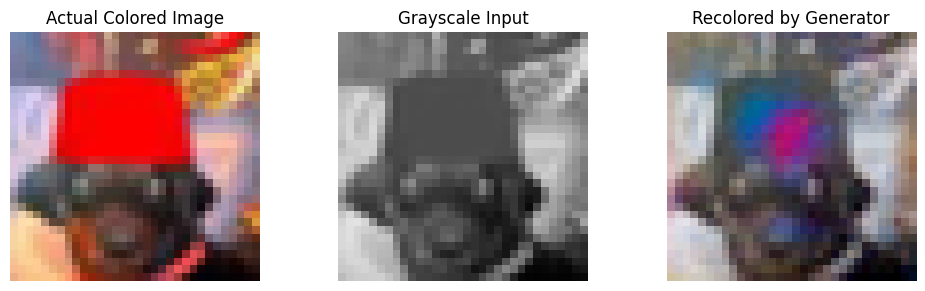

Epoch [152/200] Progress: 100.00%

=== Epoch [52/100] Summary ===
Discriminator Loss: 0.0924
Generator GAN Loss: 4.8959
Generator L1 Loss : 0.0598
Generator Total Loss (GAN + L1): 19.8346


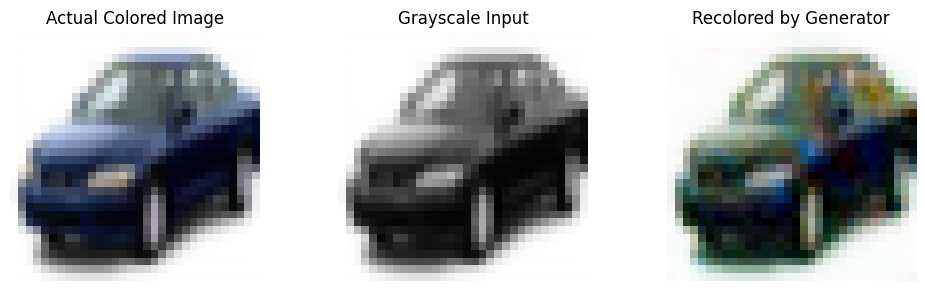

Epoch [153/200] Progress: 100.00%

=== Epoch [53/100] Summary ===
Discriminator Loss: 0.0826
Generator GAN Loss: 6.5379
Generator L1 Loss : 0.0595
Generator Total Loss (GAN + L1): 21.4177


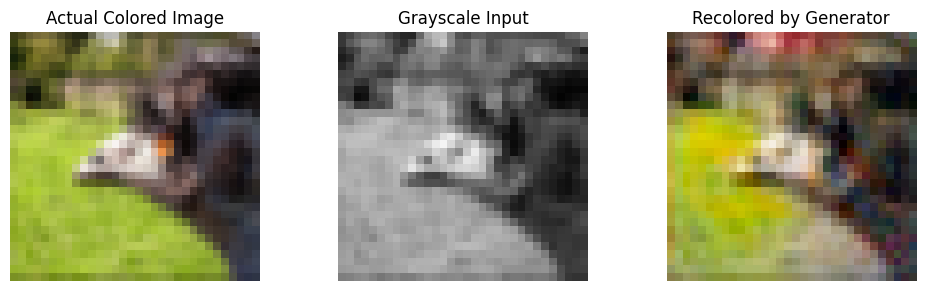

Epoch [154/200] Progress: 100.00%

=== Epoch [54/100] Summary ===
Discriminator Loss: 0.0822
Generator GAN Loss: 7.0525
Generator L1 Loss : 0.0575
Generator Total Loss (GAN + L1): 21.4386


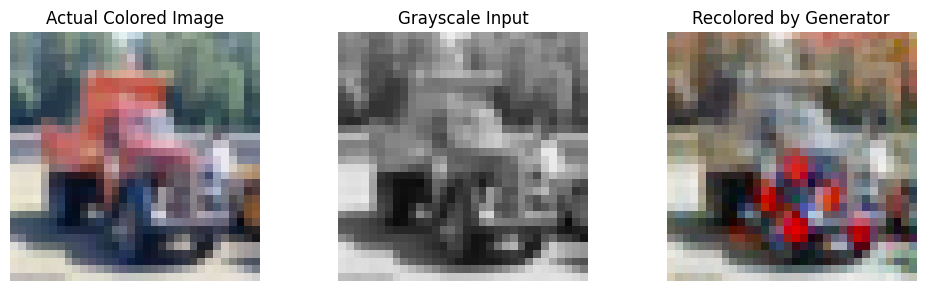

Epoch [155/200] Progress: 100.00%

=== Epoch [55/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.1847
Generator L1 Loss : 0.0571
Generator Total Loss (GAN + L1): 21.4602


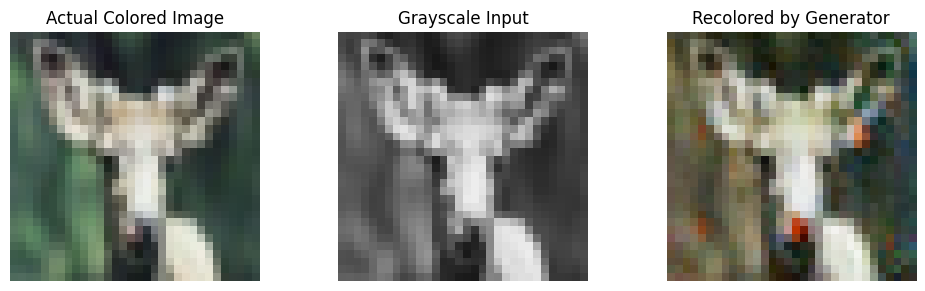

Epoch [156/200] Progress: 100.00%

=== Epoch [56/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.5364
Generator L1 Loss : 0.0554
Generator Total Loss (GAN + L1): 21.3989


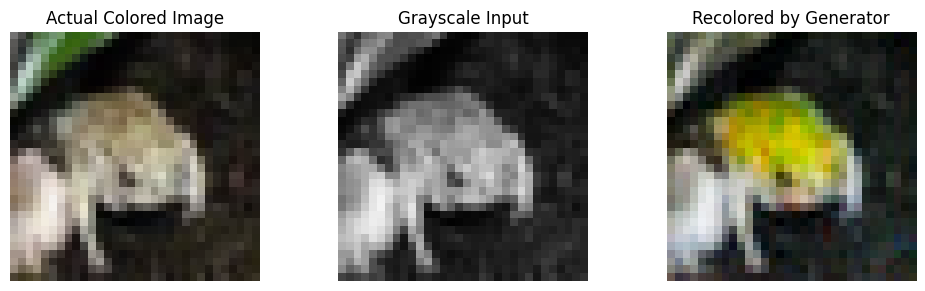

Epoch [157/200] Progress: 100.00%

=== Epoch [57/100] Summary ===
Discriminator Loss: 0.1464
Generator GAN Loss: 3.6693
Generator L1 Loss : 0.0576
Generator Total Loss (GAN + L1): 18.0640


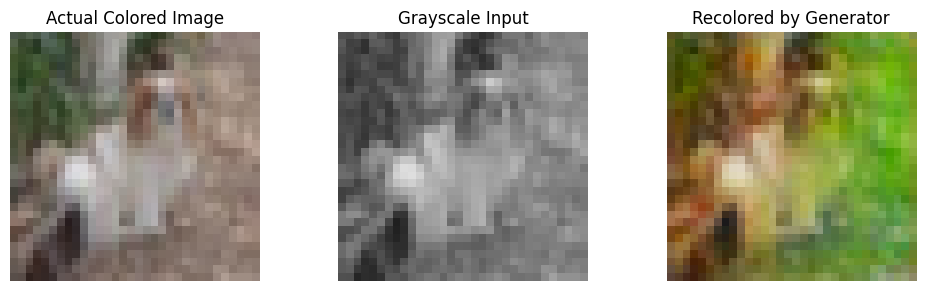

Epoch [158/200] Progress: 100.00%

=== Epoch [58/100] Summary ===
Discriminator Loss: 0.0925
Generator GAN Loss: 5.1718
Generator L1 Loss : 0.0609
Generator Total Loss (GAN + L1): 20.4001


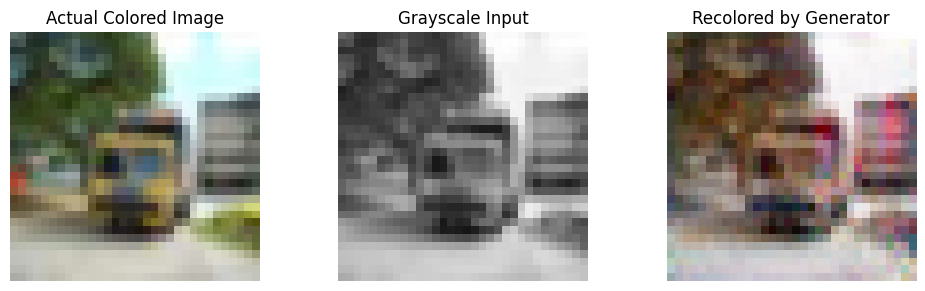

Epoch [159/200] Progress: 100.00%

=== Epoch [59/100] Summary ===
Discriminator Loss: 0.0898
Generator GAN Loss: 6.3743
Generator L1 Loss : 0.0639
Generator Total Loss (GAN + L1): 22.3401


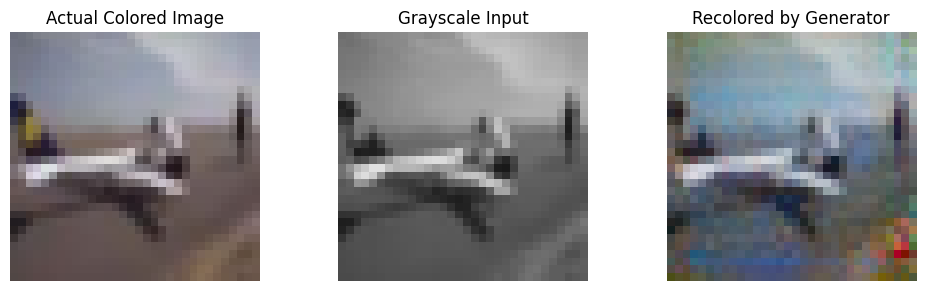

Epoch [160/200] Progress: 100.00%

=== Epoch [60/100] Summary ===
Discriminator Loss: 0.0868
Generator GAN Loss: 5.4595
Generator L1 Loss : 0.0602
Generator Total Loss (GAN + L1): 20.5046


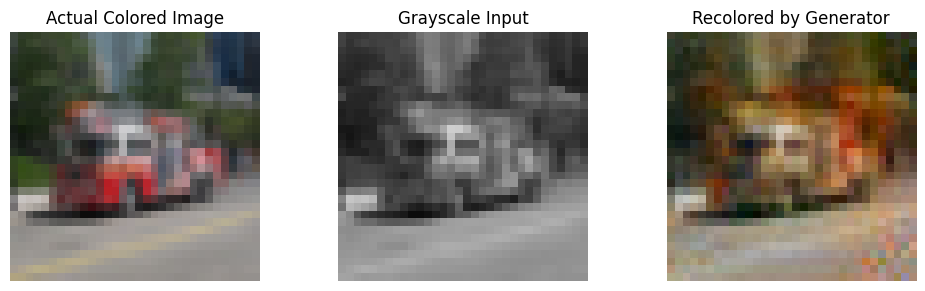

Epoch [161/200] Progress: 100.00%

=== Epoch [61/100] Summary ===
Discriminator Loss: 0.0824
Generator GAN Loss: 6.9075
Generator L1 Loss : 0.0598
Generator Total Loss (GAN + L1): 21.8647


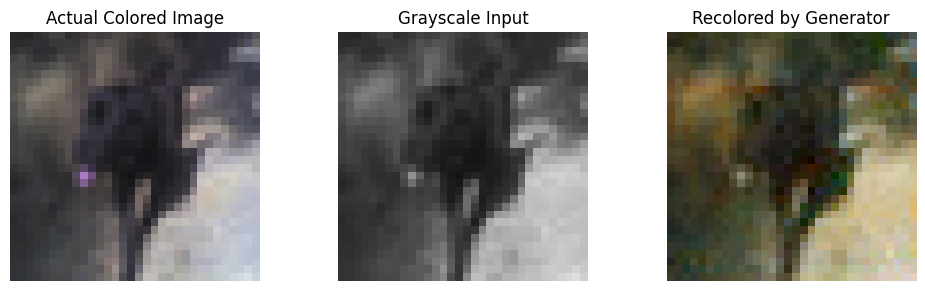

Epoch [162/200] Progress: 100.00%

=== Epoch [62/100] Summary ===
Discriminator Loss: 0.1107
Generator GAN Loss: 5.0696
Generator L1 Loss : 0.0589
Generator Total Loss (GAN + L1): 19.7959


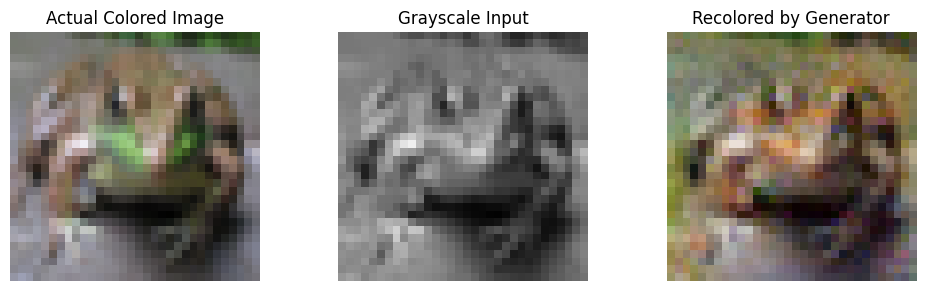

Epoch [163/200] Progress: 100.00%

=== Epoch [63/100] Summary ===
Discriminator Loss: 0.1014
Generator GAN Loss: 4.7568
Generator L1 Loss : 0.0583
Generator Total Loss (GAN + L1): 19.3433


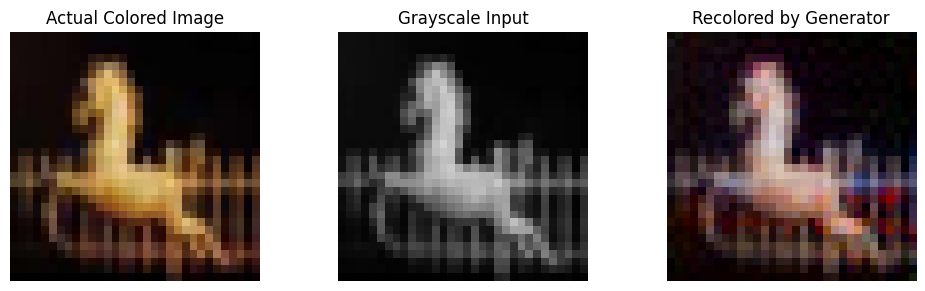

Epoch [164/200] Progress: 100.00%

=== Epoch [64/100] Summary ===
Discriminator Loss: 0.0831
Generator GAN Loss: 6.2533
Generator L1 Loss : 0.0567
Generator Total Loss (GAN + L1): 20.4308


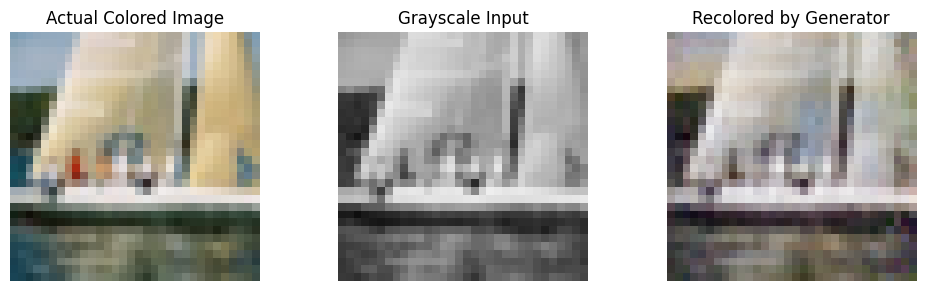

Epoch [165/200] Progress: 100.00%

=== Epoch [65/100] Summary ===
Discriminator Loss: 0.1095
Generator GAN Loss: 5.4137
Generator L1 Loss : 0.0567
Generator Total Loss (GAN + L1): 19.5983


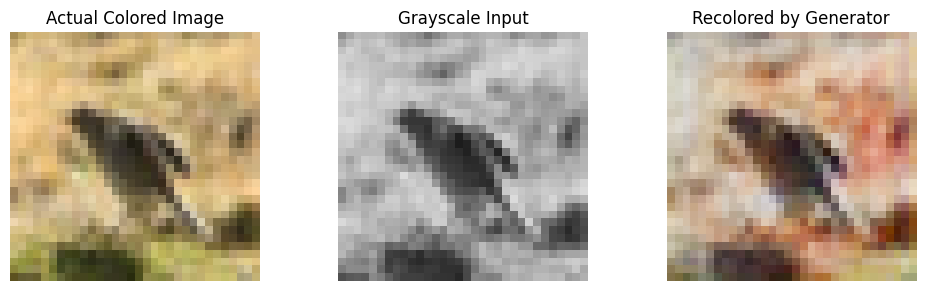

Epoch [166/200] Progress: 100.00%

=== Epoch [66/100] Summary ===
Discriminator Loss: 0.0836
Generator GAN Loss: 5.9104
Generator L1 Loss : 0.0590
Generator Total Loss (GAN + L1): 20.6677


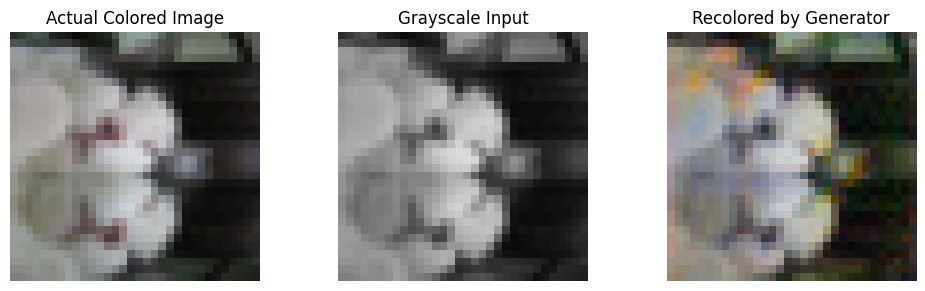

Epoch [167/200] Progress: 100.00%

=== Epoch [67/100] Summary ===
Discriminator Loss: 0.0822
Generator GAN Loss: 7.0868
Generator L1 Loss : 0.0583
Generator Total Loss (GAN + L1): 21.6633


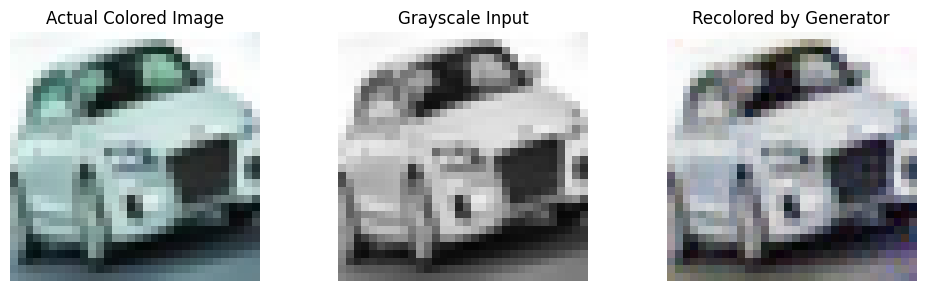

Epoch [168/200] Progress: 100.00%

=== Epoch [68/100] Summary ===
Discriminator Loss: 0.1119
Generator GAN Loss: 6.2550
Generator L1 Loss : 0.0562
Generator Total Loss (GAN + L1): 20.3113


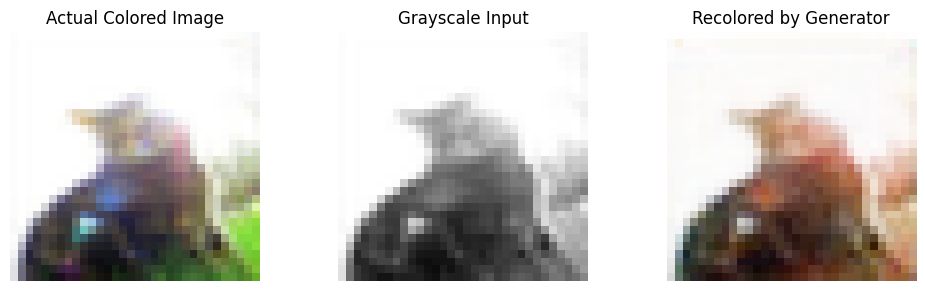

Epoch [169/200] Progress: 100.00%

=== Epoch [69/100] Summary ===
Discriminator Loss: 0.1011
Generator GAN Loss: 4.7814
Generator L1 Loss : 0.0569
Generator Total Loss (GAN + L1): 19.0028


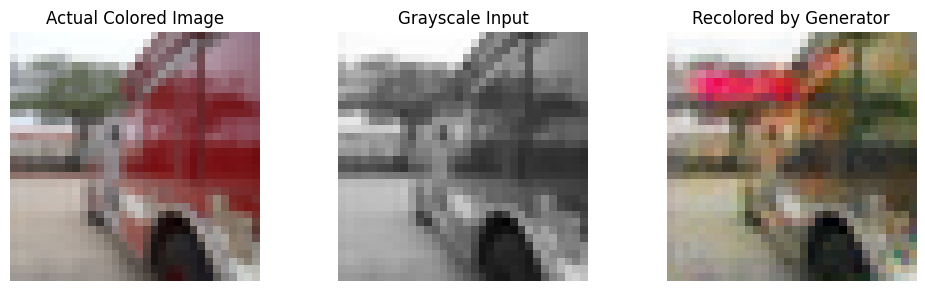

Epoch [170/200] Progress: 100.00%

=== Epoch [70/100] Summary ===
Discriminator Loss: 0.0879
Generator GAN Loss: 5.5553
Generator L1 Loss : 0.0573
Generator Total Loss (GAN + L1): 19.8694


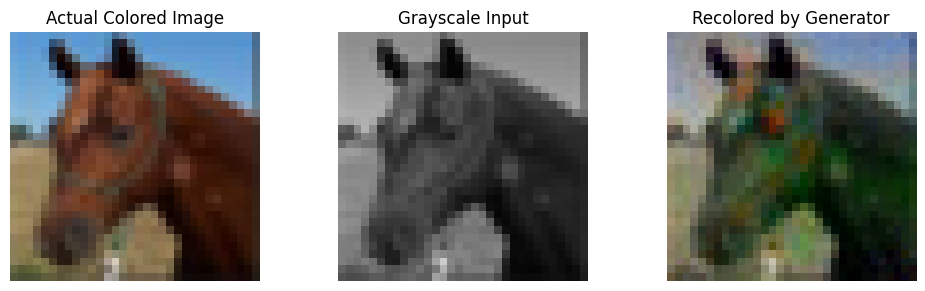

Epoch [171/200] Progress: 100.00%

=== Epoch [71/100] Summary ===
Discriminator Loss: 0.0824
Generator GAN Loss: 6.7953
Generator L1 Loss : 0.0615
Generator Total Loss (GAN + L1): 22.1618


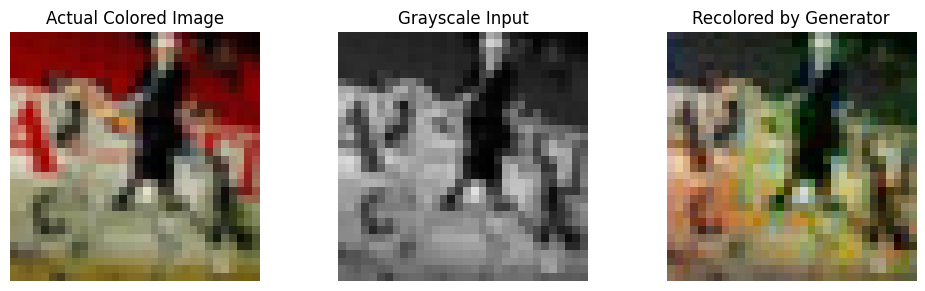

Epoch [172/200] Progress: 100.00%

=== Epoch [72/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.4937
Generator L1 Loss : 0.0540
Generator Total Loss (GAN + L1): 20.9936


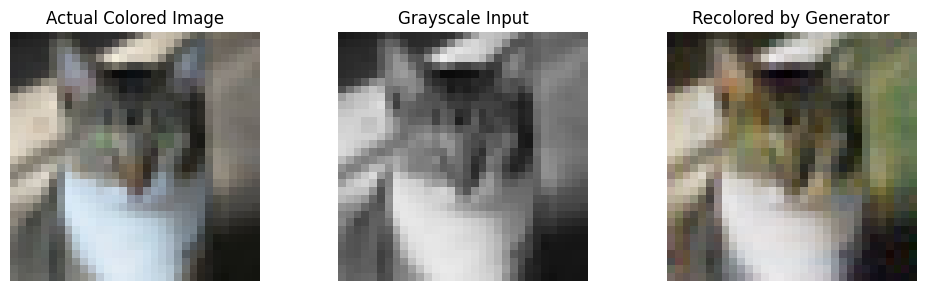

Epoch [173/200] Progress: 100.00%

=== Epoch [73/100] Summary ===
Discriminator Loss: 0.0819
Generator GAN Loss: 7.6691
Generator L1 Loss : 0.0532
Generator Total Loss (GAN + L1): 20.9767


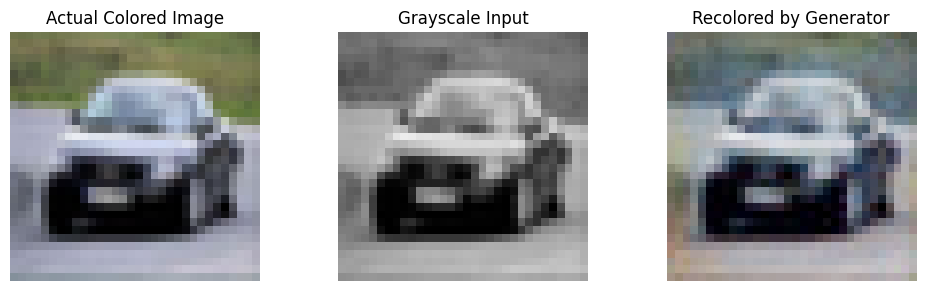

Epoch [174/200] Progress: 100.00%

=== Epoch [74/100] Summary ===
Discriminator Loss: 0.0819
Generator GAN Loss: 7.6556
Generator L1 Loss : 0.0530
Generator Total Loss (GAN + L1): 20.8968


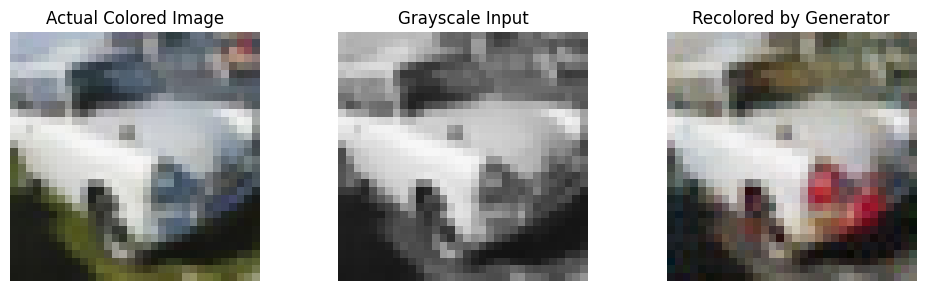

Epoch [175/200] Progress: 100.00%

=== Epoch [75/100] Summary ===
Discriminator Loss: 0.0818
Generator GAN Loss: 7.8866
Generator L1 Loss : 0.0527
Generator Total Loss (GAN + L1): 21.0570


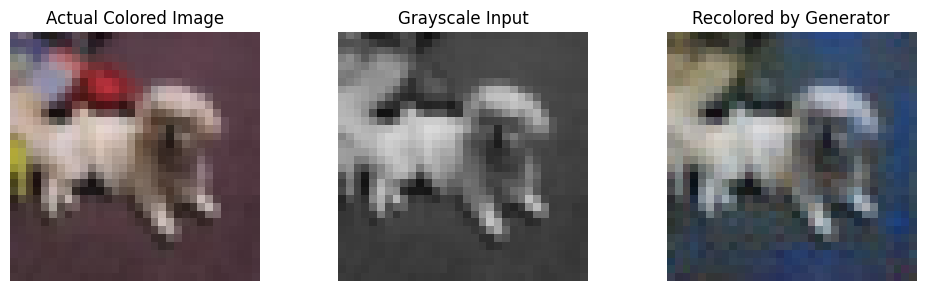

Epoch [176/200] Progress: 100.00%

=== Epoch [76/100] Summary ===
Discriminator Loss: 0.1119
Generator GAN Loss: 6.5492
Generator L1 Loss : 0.0534
Generator Total Loss (GAN + L1): 19.9024


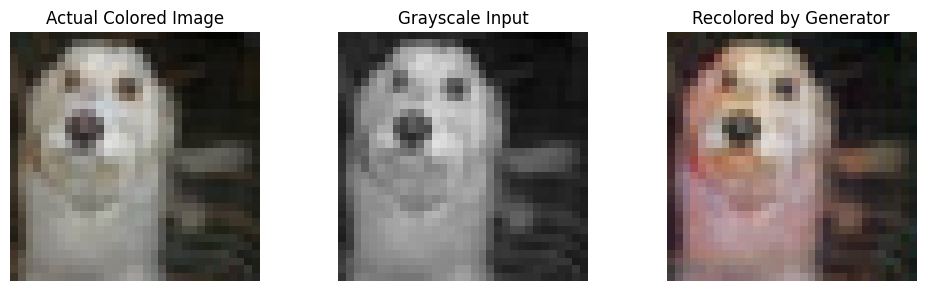

Epoch [177/200] Progress: 100.00%

=== Epoch [77/100] Summary ===
Discriminator Loss: 0.0965
Generator GAN Loss: 4.9067
Generator L1 Loss : 0.0593
Generator Total Loss (GAN + L1): 19.7312


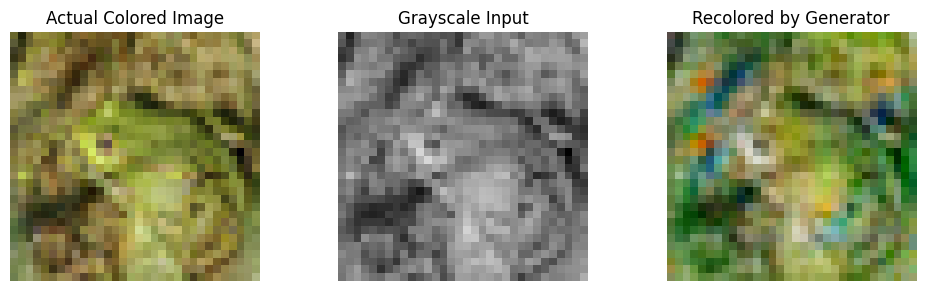

Epoch [178/200] Progress: 100.00%

=== Epoch [78/100] Summary ===
Discriminator Loss: 0.0824
Generator GAN Loss: 6.7066
Generator L1 Loss : 0.0589
Generator Total Loss (GAN + L1): 21.4401


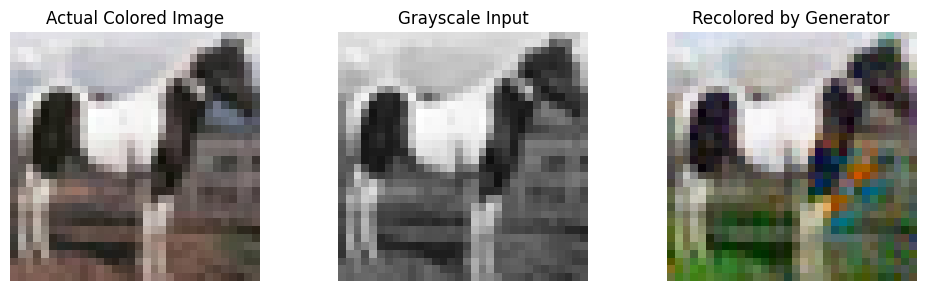

Epoch [179/200] Progress: 100.00%

=== Epoch [79/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.3384
Generator L1 Loss : 0.0572
Generator Total Loss (GAN + L1): 21.6417


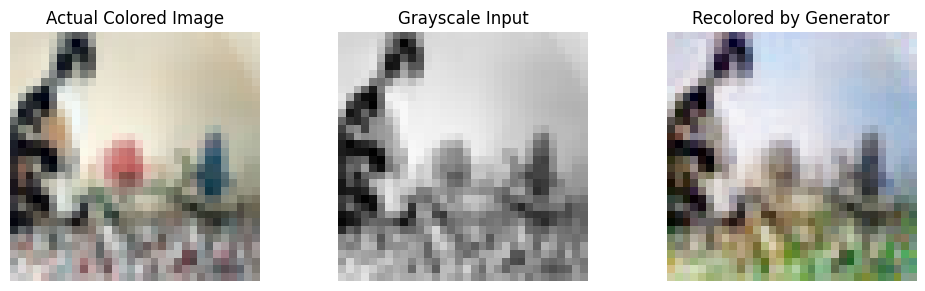

Epoch [180/200] Progress: 100.00%

=== Epoch [80/100] Summary ===
Discriminator Loss: 0.1065
Generator GAN Loss: 5.3778
Generator L1 Loss : 0.0578
Generator Total Loss (GAN + L1): 19.8391


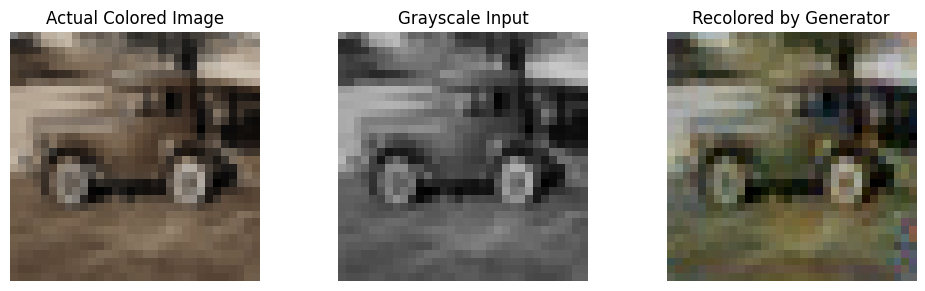

Epoch [181/200] Progress: 100.00%

=== Epoch [81/100] Summary ===
Discriminator Loss: 0.0828
Generator GAN Loss: 6.1932
Generator L1 Loss : 0.0590
Generator Total Loss (GAN + L1): 20.9505


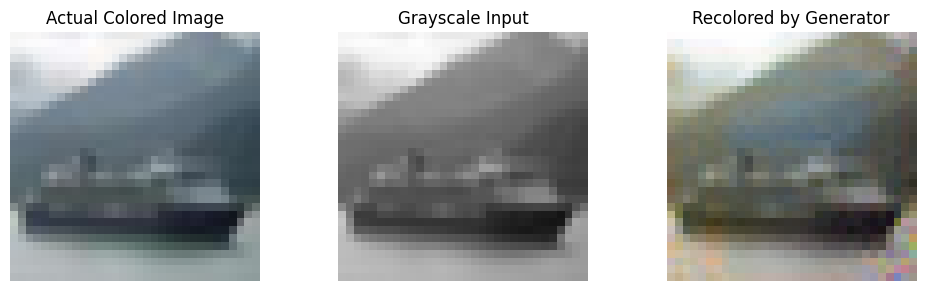

Epoch [182/200] Progress: 100.00%

=== Epoch [82/100] Summary ===
Discriminator Loss: 0.0969
Generator GAN Loss: 6.3658
Generator L1 Loss : 0.0590
Generator Total Loss (GAN + L1): 21.1276


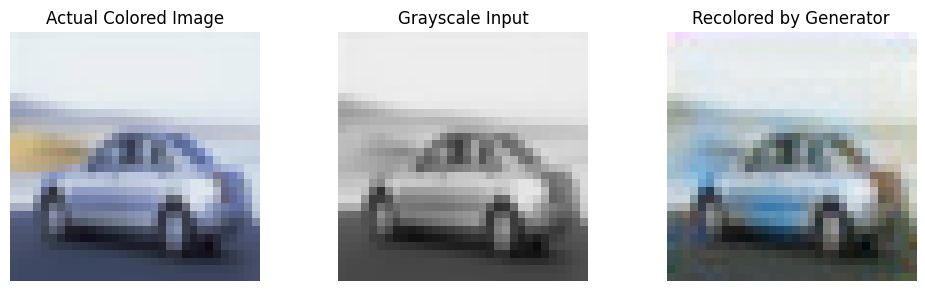

Epoch [183/200] Progress: 100.00%

=== Epoch [83/100] Summary ===
Discriminator Loss: 0.1089
Generator GAN Loss: 3.8659
Generator L1 Loss : 0.0599
Generator Total Loss (GAN + L1): 18.8374


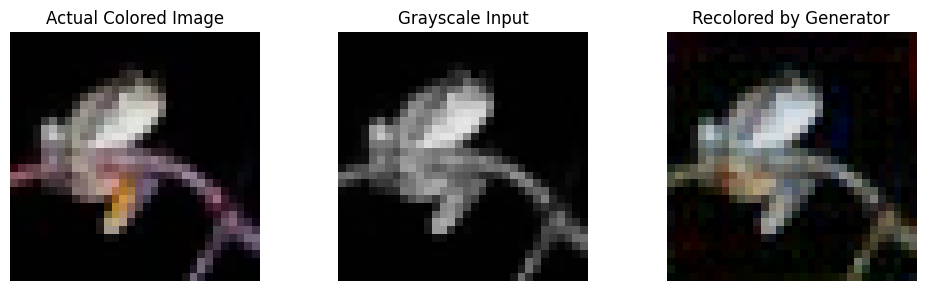

Epoch [184/200] Progress: 100.00%

=== Epoch [84/100] Summary ===
Discriminator Loss: 0.0835
Generator GAN Loss: 6.3312
Generator L1 Loss : 0.0583
Generator Total Loss (GAN + L1): 20.9057


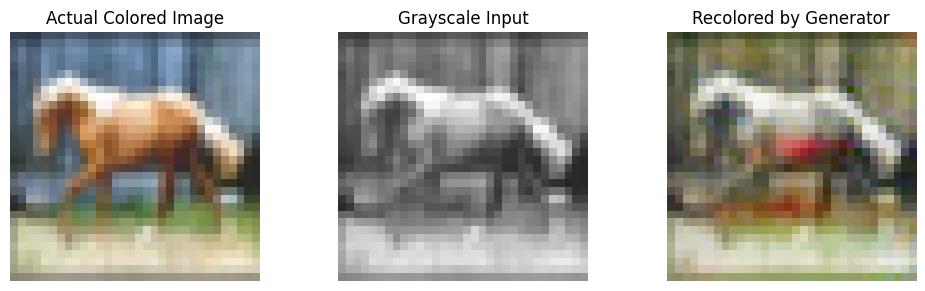

Epoch [185/200] Progress: 100.00%

=== Epoch [85/100] Summary ===
Discriminator Loss: 0.0823
Generator GAN Loss: 7.0935
Generator L1 Loss : 0.0576
Generator Total Loss (GAN + L1): 21.4861


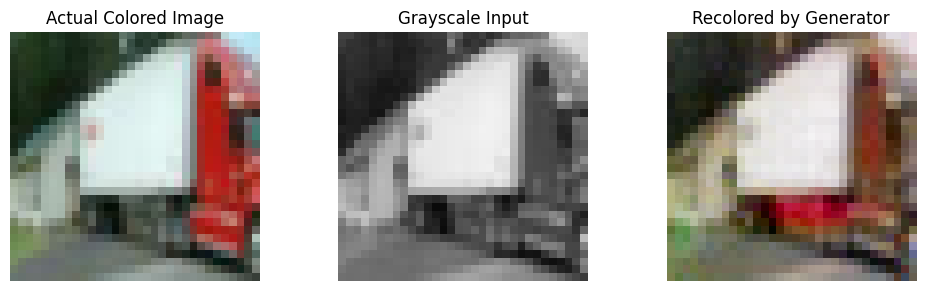

Epoch [186/200] Progress: 100.00%

=== Epoch [86/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.4149
Generator L1 Loss : 0.0568
Generator Total Loss (GAN + L1): 21.6039


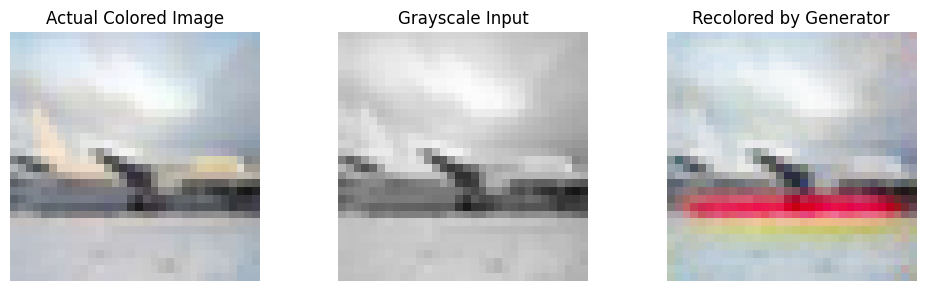

Epoch [187/200] Progress: 100.00%

=== Epoch [87/100] Summary ===
Discriminator Loss: 0.0819
Generator GAN Loss: 7.6322
Generator L1 Loss : 0.0563
Generator Total Loss (GAN + L1): 21.7041


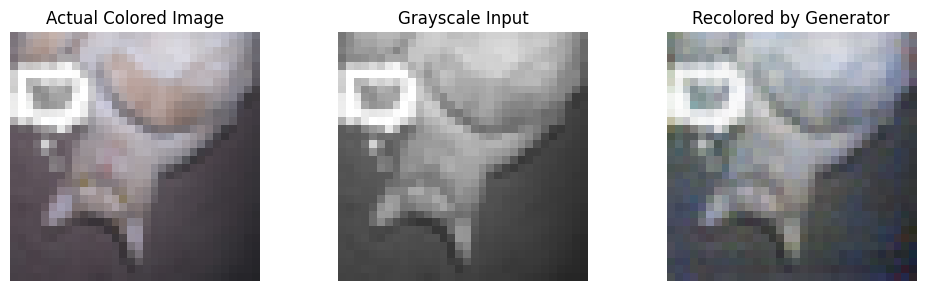

Epoch [188/200] Progress: 100.00%

=== Epoch [88/100] Summary ===
Discriminator Loss: 0.0818
Generator GAN Loss: 7.8865
Generator L1 Loss : 0.0554
Generator Total Loss (GAN + L1): 21.7273


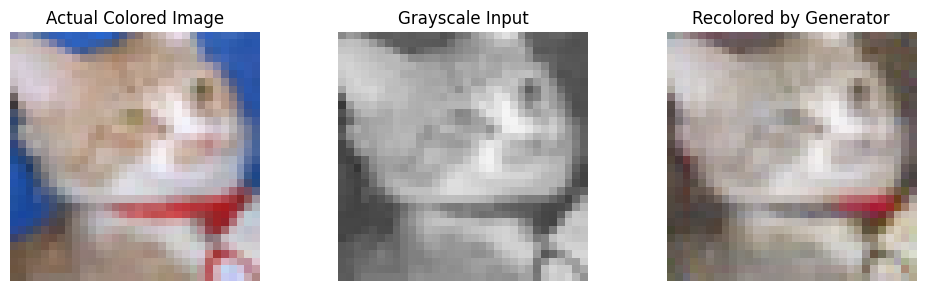

Epoch [189/200] Progress: 100.00%

=== Epoch [89/100] Summary ===
Discriminator Loss: 0.0818
Generator GAN Loss: 8.0744
Generator L1 Loss : 0.0545
Generator Total Loss (GAN + L1): 21.6870


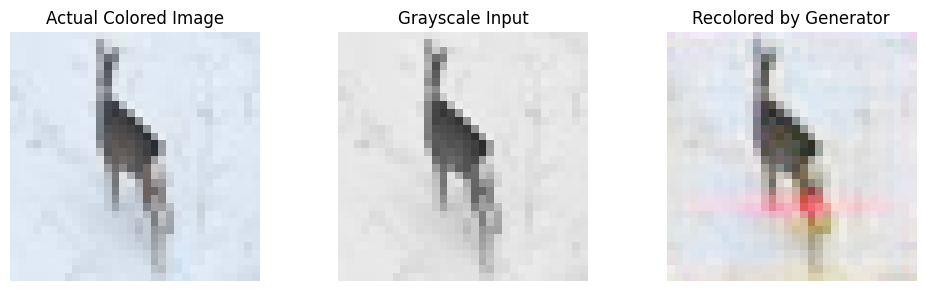

Epoch [190/200] Progress: 100.00%

=== Epoch [90/100] Summary ===
Discriminator Loss: 0.1498
Generator GAN Loss: 3.0717
Generator L1 Loss : 0.0581
Generator Total Loss (GAN + L1): 17.6032


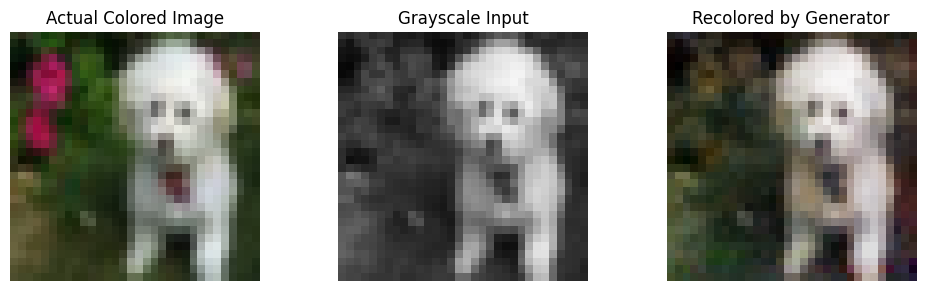

Epoch [191/200] Progress: 100.00%

=== Epoch [91/100] Summary ===
Discriminator Loss: 0.0838
Generator GAN Loss: 5.7787
Generator L1 Loss : 0.0624
Generator Total Loss (GAN + L1): 21.3848


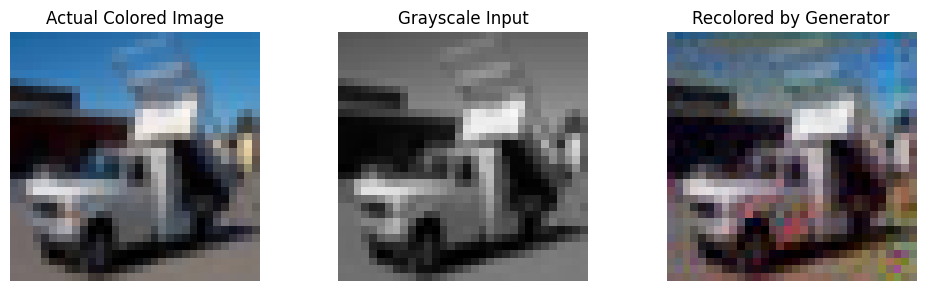

Epoch [192/200] Progress: 100.00%

=== Epoch [92/100] Summary ===
Discriminator Loss: 0.0827
Generator GAN Loss: 6.4899
Generator L1 Loss : 0.0587
Generator Total Loss (GAN + L1): 21.1713


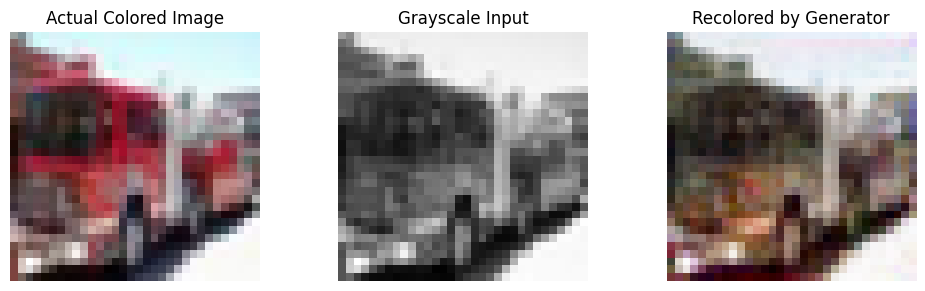

Epoch [193/200] Progress: 100.00%

=== Epoch [93/100] Summary ===
Discriminator Loss: 0.1024
Generator GAN Loss: 5.8678
Generator L1 Loss : 0.0578
Generator Total Loss (GAN + L1): 20.3240


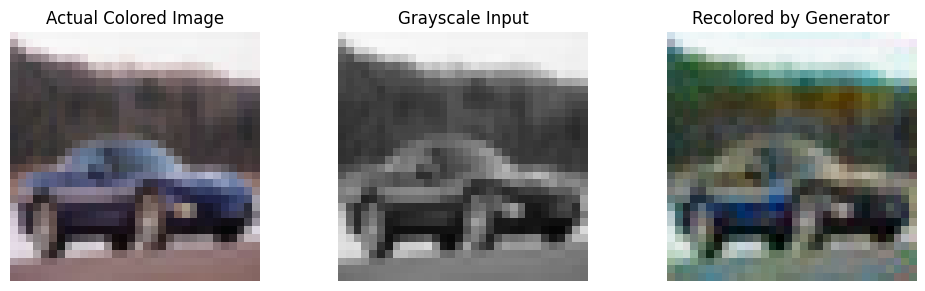

Epoch [194/200] Progress: 100.00%

=== Epoch [94/100] Summary ===
Discriminator Loss: 0.0837
Generator GAN Loss: 6.0208
Generator L1 Loss : 0.0585
Generator Total Loss (GAN + L1): 20.6449


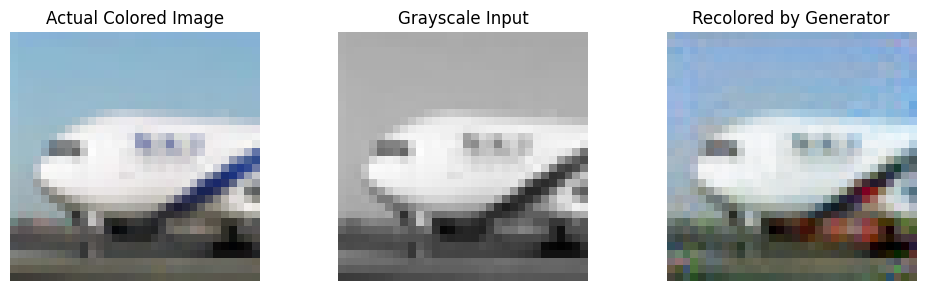

Epoch [195/200] Progress: 100.00%

=== Epoch [95/100] Summary ===
Discriminator Loss: 0.0822
Generator GAN Loss: 7.0664
Generator L1 Loss : 0.0571
Generator Total Loss (GAN + L1): 21.3476


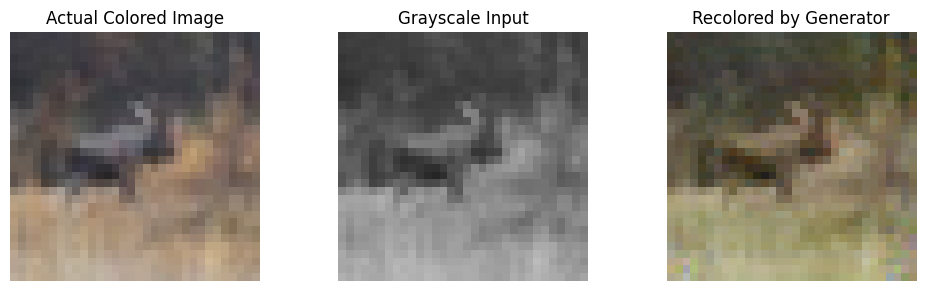

Epoch [196/200] Progress: 100.00%

=== Epoch [96/100] Summary ===
Discriminator Loss: 0.1174
Generator GAN Loss: 4.0553
Generator L1 Loss : 0.0586
Generator Total Loss (GAN + L1): 18.7162


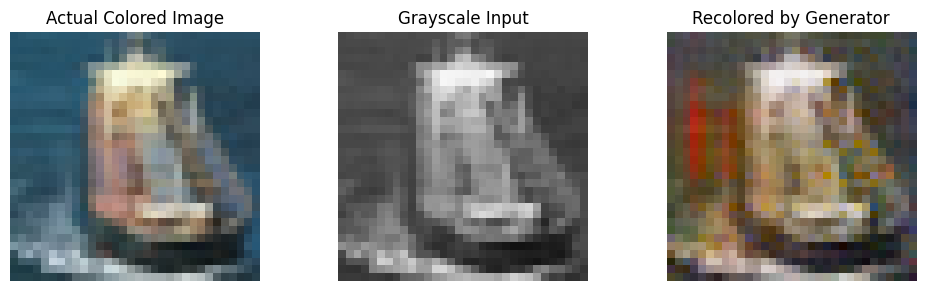

Epoch [197/200] Progress: 100.00%

=== Epoch [97/100] Summary ===
Discriminator Loss: 0.0828
Generator GAN Loss: 6.3463
Generator L1 Loss : 0.0652
Generator Total Loss (GAN + L1): 22.6547


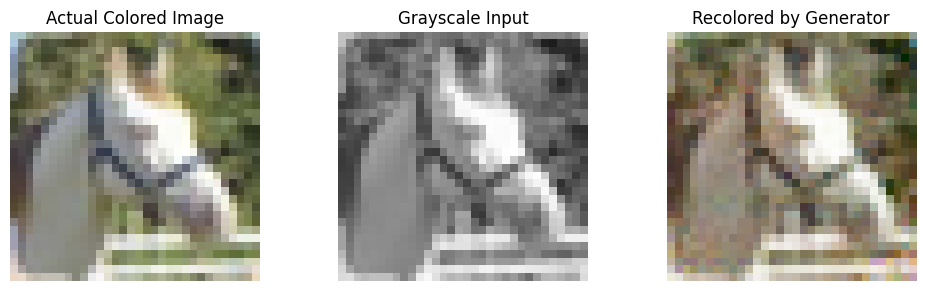

Epoch [198/200] Progress: 100.00%

=== Epoch [98/100] Summary ===
Discriminator Loss: 0.0820
Generator GAN Loss: 7.2729
Generator L1 Loss : 0.0636
Generator Total Loss (GAN + L1): 23.1711


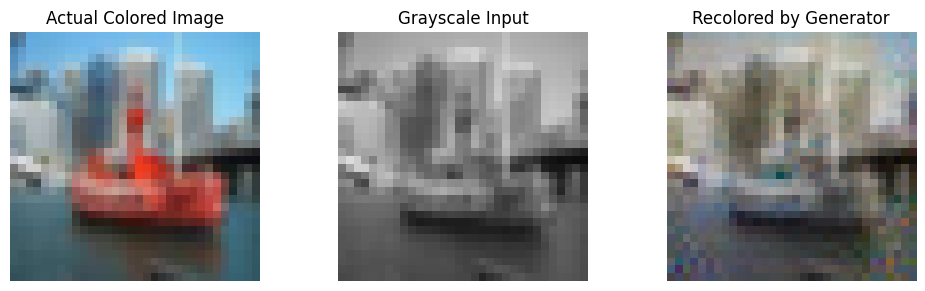

Epoch [199/200] Progress: 100.00%

=== Epoch [99/100] Summary ===
Discriminator Loss: 0.0819
Generator GAN Loss: 7.7454
Generator L1 Loss : 0.0567
Generator Total Loss (GAN + L1): 21.9254


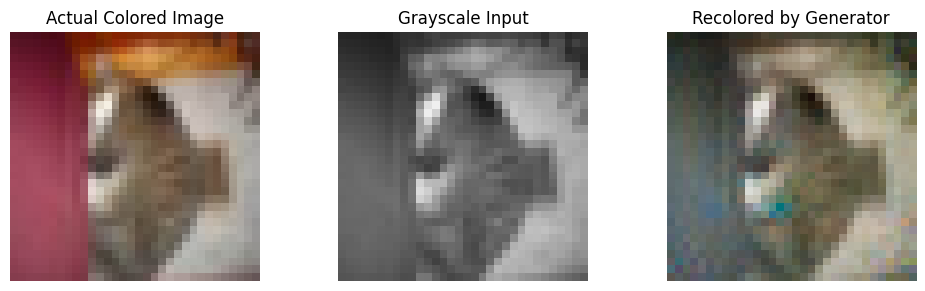

Epoch [200/200] Progress: 100.00%

=== Epoch [100/100] Summary ===
Discriminator Loss: 0.1092
Generator GAN Loss: 4.4226
Generator L1 Loss : 0.0587
Generator Total Loss (GAN + L1): 19.0968


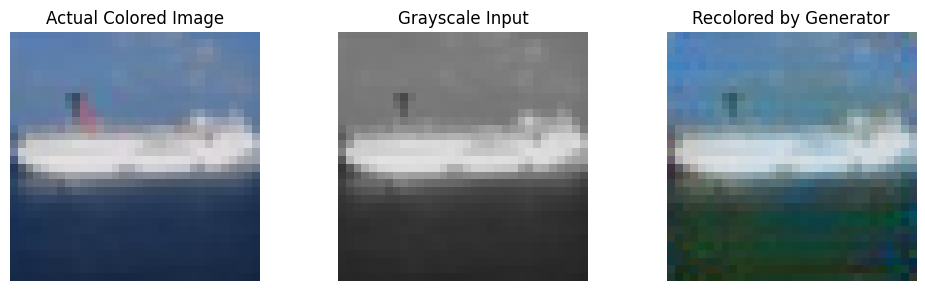

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 100
# criterion_gan = nn.BCELoss()   #uncomment if running from scratch
# criterion_l1 = nn.L1Loss()

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
lambda_l1 = 250

#generator = Generator().to(device)
#discriminator = Discriminator().to(device)

#optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
#optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

for epoch in range(num_epochs):
    g_gan_loss_epoch = 0.0
    g_l1_loss_epoch = 0.0
    g_total_loss_epoch = 0.0
    d_loss_epoch = 0.0

    for batch_idx, (gray, color) in enumerate(train_loader):
        gray = gray.to(device)
        color = color.to(device)

        real_labels = torch.full((gray.size(0), 1), 0.9, device=device)  # Label smoothing
        fake_labels = torch.zeros((gray.size(0), 1), device=device)

        # --- Train Discriminator every alternate step ---
        if batch_idx % 2 == 0:
            optimizer_d.zero_grad()
            with torch.no_grad():
                fake_color = generator(gray)

            real_output = discriminator(gray, color)
            fake_output = discriminator(gray, fake_color)

            d_loss_real = criterion_gan(real_output, real_labels)
            d_loss_fake = criterion_gan(fake_output, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_d.step()
        else:
            d_loss = torch.tensor(0.0)

        # --- Train Generator (twice per batch) ---
        g_gan_loss = g_l1_loss = g_total_loss = 0.0
        for _ in range(2):
            optimizer_g.zero_grad()
            fake_color = generator(gray)
            output = discriminator(gray, fake_color)

            g_gan = criterion_gan(output, real_labels)
            g_l1 = criterion_l1(fake_color, color)
            g_total = g_gan + lambda_l1 * g_l1

            g_total.backward()
            optimizer_g.step()

            g_gan_loss += g_gan.item()
            g_l1_loss += g_l1.item()
            g_total_loss += g_total.item()

        g_gan_loss_epoch += g_gan_loss / 2
        g_l1_loss_epoch += g_l1_loss / 2
        g_total_loss_epoch += g_total_loss / 2
        d_loss_epoch += d_loss.item()

        # --- Print percentage progress ---
        percent = 100 * (batch_idx + 1) / len(train_loader)
        print(f"\rEpoch [{epoch+101}/{num_epochs+100}] Progress: {percent:.2f}%", end='', flush=True)

    # --- Epoch Summary ---
    avg_d = d_loss_epoch / len(train_loader)
    avg_gg = g_gan_loss_epoch / len(train_loader)
    avg_l1 = g_l1_loss_epoch / len(train_loader)
    avg_gtotal = g_total_loss_epoch / len(train_loader)

    print(f"\n\n=== Epoch [{epoch+1}/{num_epochs}] Summary ===")
    print(f"Discriminator Loss: {avg_d:.4f}")
    print(f"Generator GAN Loss: {avg_gg:.4f}")
    print(f"Generator L1 Loss : {avg_l1:.4f}")
    print(f"Generator Total Loss (GAN + L1): {avg_gtotal:.4f}")
    print("=============================================")

    # --- Visualize Samples ---
    generator.eval()
    with torch.no_grad():
        sample_gray = gray[0].unsqueeze(0).to(device)
        sample_real_color = color[0].cpu()
        sample_fake_color = generator(sample_gray).squeeze(0).cpu()

        sample_gray_show = sample_gray.squeeze(0).repeat(3, 1, 1).cpu()

        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(sample_real_color.permute(1, 2, 0))
        axs[0].set_title("Actual Colored Image")
        axs[0].axis('off')

        axs[1].imshow(sample_gray_show.permute(1, 2, 0), cmap='gray')
        axs[1].set_title("Grayscale Input")
        axs[1].axis('off')

        axs[2].imshow(sample_fake_color.permute(1, 2, 0).clip(0, 1))
        axs[2].set_title("Recolored by Generator")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()
    generator.train()

In [11]:
# Save locally
torch.save(generator.state_dict(), f'generator_epoch{epoch+1}.pth')
torch.save(discriminator.state_dict(), f'discriminator_epoch{epoch+1}.pth')
from google.colab import files

# Download to local machine
files.download(f'generator_epoch{epoch+1}.pth')
files.download(f'discriminator_epoch{epoch+1}.pth')
# Save checkpoint
torch.save({
    'epoch': epoch+1,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_g_state_dict': optimizer_g.state_dict(),
    'optimizer_d_state_dict': optimizer_d.state_dict(),
}, f'model_checkpoint_epoch{epoch+1}.pth')

# Download
files.download(f'model_checkpoint_epoch{epoch+1}.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>